# 1. Autonomous Feature Selection

## 1.1 RFE: Feature Selection from 22 Baseline Variables

### 1.1.1 Logistic Regression

In [27]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from joblib import Parallel, delayed
import joblib

# set seed
RANDOM_STATE = 42

model_name = 'logistic_regression'

data = pd.read_csv('C:/path/baseline_xixi.csv')
external_data1 = pd.read_csv('C:/path/baseline_ditan.csv')
external_data2 = pd.read_csv('C:/path/baseline_youan.csv')

X = data.drop(columns=['NID', 'time1', 'IIR_3revi'])
y = data['IIR_3revi']

# feature selection using Recursive Feature Elimination (RFE)
def select_features(X, y, model, n_features):
    selector = RFE(estimator=model, n_features_to_select=n_features, step=1)
    selector.fit(X, y)
    return X.columns[selector.get_support(indices=True)]

selected_features = select_features(X, y, LogisticRegression(max_iter=10000), 8)
X_selected = X[selected_features]

# hyperparameter tuning and 10-fold cross-validation
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
logistic_regression = LogisticRegression(max_iter=10000)
grid_search = GridSearchCV(estimator=logistic_regression, param_grid=param_grid, cv=10, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_selected, y)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
best_features_list = selected_features.tolist()

pd.DataFrame([best_params]).to_csv(f'{model_name}_best_params.csv', index=False)
pd.DataFrame(best_features_list, columns=['Best Features']).to_csv(f'{model_name}_best_features.csv', index=False)

best_model_data = data[['NID', 'time1', 'IIR_3revi'] + best_features_list]
best_model_data.to_csv(f'{model_name}_best_model_data.csv', index=False)

# overall evaluation metrics
y_pred = best_model.predict(X_selected)
y_prob = best_model.predict_proba(X_selected)[:, 1]

accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
auc = roc_auc_score(y, y_prob)
tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
specificity = tn / (tn + fp)
sensitivity = recall

overall_metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'AUC': auc,
    'Specificity': specificity,
    'Sensitivity': sensitivity
}
pd.DataFrame([overall_metrics]).to_csv(f'{model_name}_overall_metrics.csv', index=False)

# evaluate metrics at specific time points
def calculate_metrics_at_time(time_point, data, best_features_list, best_model):
    subset = data[data['time1'] > time_point]
    X_subset = subset[best_features_list]
    y_subset = subset['IIR_3revi']
    
    y_pred_subset = best_model.predict(X_subset)
    y_prob_subset = best_model.predict_proba(X_subset)[:, 1]
    
    accuracy = accuracy_score(y_subset, y_pred_subset)
    precision = precision_score(y_subset, y_pred_subset)
    recall = recall_score(y_subset, y_pred_subset)
    f1 = f1_score(y_subset, y_pred_subset)
    auc = roc_auc_score(y_subset, y_prob_subset)
    tn, fp, fn, tp = confusion_matrix(y_subset, y_pred_subset).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall
    
    return {
        'Time Point': time_point,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }

time_points = [5, 6, 7]
metrics_at_times = Parallel(n_jobs=8)(delayed(calculate_metrics_at_time)(tp, data, best_features_list, best_model) for tp in time_points)
pd.DataFrame(metrics_at_times).to_csv(f'{model_name}_metrics_at_times.csv', index=False)

# evaluate on external datasets
def evaluate_external_data(external_data, best_features_list, best_model, model_name):
    X_external = external_data[best_features_list]
    y_external = external_data['IIR_3revi']
    
    y_pred_external = best_model.predict(X_external)
    y_prob_external = best_model.predict_proba(X_external)[:, 1]
    
    accuracy = accuracy_score(y_external, y_pred_external)
    precision = precision_score(y_external, y_pred_external)
    recall = recall_score(y_external, y_pred_external)
    f1 = f1_score(y_external, y_pred_external)
    auc = roc_auc_score(y_external, y_prob_external)
    tn, fp, fn, tp = confusion_matrix(y_external, y_pred_external).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall
    
    overall_metrics_external = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }
    pd.DataFrame([overall_metrics_external]).to_csv(f'{model_name}_external_overall_metrics.csv', index=False)
    
    metrics_at_times_external = Parallel(n_jobs=8)(delayed(calculate_metrics_at_time)(tp, external_data, best_features_list, best_model) for tp in time_points)
    pd.DataFrame(metrics_at_times_external).to_csv(f'{model_name}_external_metrics_at_times.csv', index=False)

evaluate_external_data(external_data1, best_features_list, best_model, f'{model_name}_ditan')
evaluate_external_data(external_data2, best_features_list, best_model, f'{model_name}_youan')

### 1.1.2 Support Vector Machine

In [ ]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from joblib import Parallel, delayed
import joblib

# set seed
RANDOM_STATE = 42

model_name = 'svm'

data = pd.read_csv('C:/path/baseline_xixi.csv')
external_data1 = pd.read_csv('C:/path/baseline_ditan.csv')
external_data2 = pd.read_csv('C:/path/baseline_youan.csv')

X = data.drop(columns=['NID', 'time1', 'IIR_3revi'])
y = data['IIR_3revi']

# feature selection using Recursive Feature Elimination (RFE)
def select_features(X, y, model, n_features):
    selector = RFE(estimator=model, n_features_to_select=n_features, step=1)
    selector.fit(X, y)
    return X.columns[selector.get_support(indices=True)]

selected_features = select_features(X, y, SVC(kernel='linear'), 8)
X_selected = X[selected_features]

# hyperparameter tuning and 10-fold cross-validation
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf']
}
svm = SVC(probability=True)
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=10, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_selected, y)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
best_features_list = selected_features.tolist()

pd.DataFrame([best_params]).to_csv(f'{model_name}_best_params.csv', index=False)
pd.DataFrame(best_features_list, columns=['Best Features']).to_csv(f'{model_name}_best_features.csv', index=False)

best_model_data = data[['NID', 'time1', 'IIR_3revi'] + best_features_list]
best_model_data.to_csv(f'{model_name}_best_model_data.csv', index=False)

# overall evaluation metrics
y_pred = best_model.predict(X_selected)
y_prob = best_model.predict_proba(X_selected)[:, 1]

accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
auc = roc_auc_score(y, y_prob)
tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
specificity = tn / (tn + fp)
sensitivity = recall

overall_metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'AUC': auc,
    'Specificity': specificity,
    'Sensitivity': sensitivity
}
pd.DataFrame([overall_metrics]).to_csv(f'{model_name}_overall_metrics.csv', index=False)

# evaluate metrics at specific time points
def calculate_metrics_at_time(time_point, data, best_features_list, best_model):
    subset = data[data['time1'] > time_point]
    X_subset = subset[best_features_list]
    y_subset = subset['IIR_3revi']
    
    y_pred_subset = best_model.predict(X_subset)
    y_prob_subset = best_model.predict_proba(X_subset)[:, 1]
    
    accuracy = accuracy_score(y_subset, y_pred_subset)
    precision = precision_score(y_subset, y_pred_subset)
    recall = recall_score(y_subset, y_pred_subset)
    f1 = f1_score(y_subset, y_pred_subset)
    auc = roc_auc_score(y_subset, y_prob_subset)
    tn, fp, fn, tp = confusion_matrix(y_subset, y_pred_subset).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall
    
    return {
        'Time Point': time_point,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }

time_points = [5, 6, 7]
metrics_at_times = Parallel(n_jobs=8)(delayed(calculate_metrics_at_time)(tp, data, best_features_list, best_model) for tp in time_points)
pd.DataFrame(metrics_at_times).to_csv(f'{model_name}_metrics_at_times.csv', index=False)

# evaluate on external datasets
def evaluate_external_data(external_data, best_features_list, best_model, model_name):
    X_external = external_data[best_features_list]
    y_external = external_data['IIR_3revi']
    
    y_pred_external = best_model.predict(X_external)
    y_prob_external = best_model.predict_proba(X_external)[:, 1]
    
    accuracy = accuracy_score(y_external, y_pred_external)
    precision = precision_score(y_external, y_pred_external)
    recall = recall_score(y_external, y_pred_external)
    f1 = f1_score(y_external, y_pred_external)
    auc = roc_auc_score(y_external, y_prob_external)
    tn, fp, fn, tp = confusion_matrix(y_external, y_pred_external).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall
    
    overall_metrics_external = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }
    pd.DataFrame([overall_metrics_external]).to_csv(f'{model_name}_external_overall_metrics.csv', index=False)
    
    metrics_at_times_external = Parallel(n_jobs=8)(delayed(calculate_metrics_at_time)(tp, external_data, best_features_list, best_model) for tp in time_points)
    pd.DataFrame(metrics_at_times_external).to_csv(f'{model_name}_external_metrics_at_times.csv', index=False)

evaluate_external_data(external_data1, best_features_list, best_model, f'{model_name}_ditan')
evaluate_external_data(external_data2, best_features_list, best_model, f'{model_name}_youan')

### 1.1.3 K-Nearest Neighbors

In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from joblib import Parallel, delayed
import joblib

# set seed
RANDOM_STATE = 42

model_name = 'knn'

data = pd.read_csv('C:/path/baseline_xixi.csv')
external_data1 = pd.read_csv('C:/path/baseline_ditan.csv')
external_data2 = pd.read_csv('C:/path/baseline_youan.csv')

X = data.drop(columns=['NID', 'time1', 'IIR_3revi'])
y = data['IIR_3revi']

# feature selection using Recursive Feature Elimination (RFE)
def select_features(X, y, model, n_features):
    selector = RFE(estimator=model, n_features_to_select=n_features, step=1)
    selector.fit(X, y)
    return X.columns[selector.get_support(indices=True)]

logistic_model = LogisticRegression(max_iter=1000)
selected_features = select_features(X, y, logistic_model, 8)
X_selected = X[selected_features]

# hyperparameter tuning and 10-fold cross-validation
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=10, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_selected, y)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
best_features_list = selected_features.tolist()

pd.DataFrame([best_params]).to_csv(f'{model_name}_best_params.csv', index=False)
pd.DataFrame(best_features_list, columns=['Best Features']).to_csv(f'{model_name}_best_features.csv', index=False)

best_model_data = data[['NID', 'time1', 'IIR_3revi'] + best_features_list]
best_model_data.to_csv(f'{model_name}_best_model_data.csv', index=False)

# overall evaluation metrics
y_pred = best_model.predict(X_selected)
y_prob = best_model.predict_proba(X_selected)[:, 1]

accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
auc = roc_auc_score(y, y_prob)
tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
specificity = tn / (tn + fp)
sensitivity = recall

overall_metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'AUC': auc,
    'Specificity': specificity,
    'Sensitivity': sensitivity
}
pd.DataFrame([overall_metrics]).to_csv(f'{model_name}_overall_metrics.csv', index=False)

# evaluate metrics at specific time points
def calculate_metrics_at_time(time_point, data, best_features_list, best_model):
    subset = data[data['time1'] > time_point]
    X_subset = subset[best_features_list]
    y_subset = subset['IIR_3revi']
    
    y_pred_subset = best_model.predict(X_subset)
    y_prob_subset = best_model.predict_proba(X_subset)[:, 1]
    
    accuracy = accuracy_score(y_subset, y_pred_subset)
    precision = precision_score(y_subset, y_pred_subset)
    recall = recall_score(y_subset, y_pred_subset)
    f1 = f1_score(y_subset, y_pred_subset)
    auc = roc_auc_score(y_subset, y_prob_subset)
    tn, fp, fn, tp = confusion_matrix(y_subset, y_pred_subset).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall
    
    return {
        'Time Point': time_point,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }

time_points = [5, 6, 7]
metrics_at_times = Parallel(n_jobs=8)(delayed(calculate_metrics_at_time)(tp, data, best_features_list, best_model) for tp in time_points)
pd.DataFrame(metrics_at_times).to_csv(f'{model_name}_metrics_at_times.csv', index=False)

# evaluate on external datasets
def evaluate_external_data(external_data, best_features_list, best_model, model_name):
    X_external = external_data[best_features_list]
    y_external = external_data['IIR_3revi']
    
    y_pred_external = best_model.predict(X_external)
    y_prob_external = best_model.predict_proba(X_external)[:, 1]
    
    accuracy = accuracy_score(y_external, y_pred_external)
    precision = precision_score(y_external, y_pred_external)
    recall = recall_score(y_external, y_pred_external)
    f1 = f1_score(y_external, y_pred_external)
    auc = roc_auc_score(y_external, y_prob_external)
    tn, fp, fn, tp = confusion_matrix(y_external, y_pred_external).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall
    
    overall_metrics_external = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }
    pd.DataFrame([overall_metrics_external]).to_csv(f'{model_name}_external_overall_metrics.csv', index=False)
    
    metrics_at_times_external = Parallel(n_jobs=8)(delayed(calculate_metrics_at_time)(tp, external_data, best_features_list, best_model) for tp in time_points)
    pd.DataFrame(metrics_at_times_external).to_csv(f'{model_name}_external_metrics_at_times.csv', index=False)

evaluate_external_data(external_data1, best_features_list, best_model, f'{model_name}_ditan')
evaluate_external_data(external_data2, best_features_list, best_model, f'{model_name}_youan')

### 1.1.4 Naive Bayes

In [ ]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from joblib import Parallel, delayed
import joblib

# set seed
RANDOM_STATE = 42

model_name = 'naive_bayes'

data = pd.read_csv('C:/path/baseline_xixi.csv')
external_data1 = pd.read_csv('C:/path/baseline_ditan.csv')
external_data2 = pd.read_csv('C:/path/baseline_youan.csv')

X = data.drop(columns=['NID', 'time1', 'IIR_3revi'])
y = data['IIR_3revi']

# feature selection using Recursive Feature Elimination (RFE)
def select_features(X, y, model, n_features):
    selector = RFE(estimator=model, n_features_to_select=n_features, step=1)
    selector.fit(X, y)
    return X.columns[selector.get_support(indices=True)]

logistic_model = LogisticRegression(max_iter=1000)
selected_features = select_features(X, y, logistic_model, 8)
X_selected = X[selected_features]

# hyperparameter tuning and 10-fold cross-validation
param_grid = {
    'var_smoothing': np.logspace(0, -9, num=100)
}
naive_bayes = GaussianNB()
grid_search = GridSearchCV(estimator=naive_bayes, param_grid=param_grid, cv=10, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_selected, y)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
best_features_list = selected_features.tolist()

pd.DataFrame([best_params]).to_csv(f'{model_name}_best_params.csv', index=False)
pd.DataFrame(best_features_list, columns=['Best Features']).to_csv(f'{model_name}_best_features.csv', index=False)

best_model_data = data[['NID', 'time1', 'IIR_3revi'] + best_features_list]
best_model_data.to_csv(f'{model_name}_best_model_data.csv', index=False)

# overall evaluation metrics
y_pred = best_model.predict(X_selected)
y_prob = best_model.predict_proba(X_selected)[:, 1]

accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
auc = roc_auc_score(y, y_prob)
tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
specificity = tn / (tn + fp)
sensitivity = recall

overall_metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'AUC': auc,
    'Specificity': specificity,
    'Sensitivity': sensitivity
}
pd.DataFrame([overall_metrics]).to_csv(f'{model_name}_overall_metrics.csv', index=False)

# evaluate metrics at specific time points
def calculate_metrics_at_time(time_point, data, best_features_list, best_model):
    subset = data[data['time1'] > time_point]
    X_subset = subset[best_features_list]
    y_subset = subset['IIR_3revi']
    
    y_pred_subset = best_model.predict(X_subset)
    y_prob_subset = best_model.predict_proba(X_subset)[:, 1]
    
    accuracy = accuracy_score(y_subset, y_pred_subset)
    precision = precision_score(y_subset, y_pred_subset)
    recall = recall_score(y_subset, y_pred_subset)
    f1 = f1_score(y_subset, y_pred_subset)
    auc = roc_auc_score(y_subset, y_prob_subset)
    tn, fp, fn, tp = confusion_matrix(y_subset, y_pred_subset).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall
    
    return {
        'Time Point': time_point,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }

time_points = [5, 6, 7]
metrics_at_times = Parallel(n_jobs=8)(delayed(calculate_metrics_at_time)(tp, data, best_features_list, best_model) for tp in time_points)
pd.DataFrame(metrics_at_times).to_csv(f'{model_name}_metrics_at_times.csv', index=False)

# Evaluate on external datasets
def evaluate_external_data(external_data, best_features_list, best_model, model_name):
    X_external = external_data[best_features_list]
    y_external = external_data['IIR_3revi']
    
    y_pred_external = best_model.predict(X_external)
    y_prob_external = best_model.predict_proba(X_external)[:, 1]
    
    accuracy = accuracy_score(y_external, y_pred_external)
    precision = precision_score(y_external, y_pred_external)
    recall = recall_score(y_external, y_pred_external)
    f1 = f1_score(y_external, y_pred_external)
    auc = roc_auc_score(y_external, y_prob_external)
    tn, fp, fn, tp = confusion_matrix(y_external, y_pred_external).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall
    
    overall_metrics_external = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }
    pd.DataFrame([overall_metrics_external]).to_csv(f'{model_name}_external_overall_metrics.csv', index=False)
    
    metrics_at_times_external = Parallel(n_jobs=8)(delayed(calculate_metrics_at_time)(tp, external_data, best_features_list, best_model) for tp in time_points)
    pd.DataFrame(metrics_at_times_external).to_csv(f'{model_name}_external_metrics_at_times.csv', index=False)

evaluate_external_data(external_data1, best_features_list, best_model, f'{model_name}_ditan')
evaluate_external_data(external_data2, best_features_list, best_model, f'{model_name}_youan')

### 1.1.5 Linear Discriminant Analysis

In [ ]:
import pandas as pd
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from joblib import Parallel, delayed
import joblib

# set seed
RANDOM_STATE = 42

model_name = 'lda'

data = pd.read_csv('C:/path/baseline_xixi.csv')
external_data1 = pd.read_csv('C:/path/baseline_ditan.csv')
external_data2 = pd.read_csv('C:/path/baseline_youan.csv')

X = data.drop(columns=['NID', 'time1', 'IIR_3revi'])
y = data['IIR_3revi']

# feature selection using Recursive Feature Elimination (RFE)
def select_features(X, y, model, n_features):
    selector = RFE(estimator=model, n_features_to_select=n_features, step=1)
    selector.fit(X, y)
    return X.columns[selector.get_support(indices=True)]

selected_features = select_features(X, y, LinearDiscriminantAnalysis(), 8)
X_selected = X[selected_features]

# hyperparameter tuning and 10-fold cross-validation
param_grid = {
    'solver': ['svd', 'lsqr', 'eigen'],
    'shrinkage': [None, 'auto'] + list(np.linspace(0, 1, 20))  # 仅在'shrinkage'为'lsqr'或'eigen'时有效
}
lda = LinearDiscriminantAnalysis()
grid_search = GridSearchCV(estimator=lda, param_grid=param_grid, cv=10, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_selected, y)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
best_features_list = selected_features.tolist()

pd.DataFrame([best_params]).to_csv(f'{model_name}_best_params.csv', index=False)
pd.DataFrame(best_features_list, columns=['Best Features']).to_csv(f'{model_name}_best_features.csv', index=False)

best_model_data = data[['NID', 'time1', 'IIR_3revi'] + best_features_list]
best_model_data.to_csv(f'{model_name}_best_model_data.csv', index=False)

# overall evaluation metrics
y_pred = best_model.predict(X_selected)
y_prob = best_model.predict_proba(X_selected)[:, 1]

accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
auc = roc_auc_score(y, y_prob)
tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
specificity = tn / (tn + fp)
sensitivity = recall

overall_metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'AUC': auc,
    'Specificity': specificity,
    'Sensitivity': sensitivity
}
pd.DataFrame([overall_metrics]).to_csv(f'{model_name}_overall_metrics.csv', index=False)

# evaluate metrics at specific time points
def calculate_metrics_at_time(time_point, data, best_features_list, best_model):
    subset = data[data['time1'] > time_point]
    X_subset = subset[best_features_list]
    y_subset = subset['IIR_3revi']
    
    y_pred_subset = best_model.predict(X_subset)
    y_prob_subset = best_model.predict_proba(X_subset)[:, 1]
    
    accuracy = accuracy_score(y_subset, y_pred_subset)
    precision = precision_score(y_subset, y_pred_subset)
    recall = recall_score(y_subset, y_pred_subset)
    f1 = f1_score(y_subset, y_pred_subset)
    auc = roc_auc_score(y_subset, y_prob_subset)
    tn, fp, fn, tp = confusion_matrix(y_subset, y_pred_subset).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall
    
    return {
        'Time Point': time_point,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }

time_points = [5, 6, 7]
metrics_at_times = Parallel(n_jobs=8)(delayed(calculate_metrics_at_time)(tp, data, best_features_list, best_model) for tp in time_points)
pd.DataFrame(metrics_at_times).to_csv(f'{model_name}_metrics_at_times.csv', index=False)

# evaluate on external datasets
def evaluate_external_data(external_data, best_features_list, best_model, model_name):
    X_external = external_data[best_features_list]
    y_external = external_data['IIR_3revi']
    
    y_pred_external = best_model.predict(X_external)
    y_prob_external = best_model.predict_proba(X_external)[:, 1]
    
    accuracy = accuracy_score(y_external, y_pred_external)
    precision = precision_score(y_external, y_pred_external)
    recall = recall_score(y_external, y_pred_external)
    f1 = f1_score(y_external, y_pred_external)
    auc = roc_auc_score(y_external, y_prob_external)
    tn, fp, fn, tp = confusion_matrix(y_external, y_pred_external).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall
    
    overall_metrics_external = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }
    pd.DataFrame([overall_metrics_external]).to_csv(f'{model_name}_external_overall_metrics.csv', index=False)
    
    metrics_at_times_external = Parallel(n_jobs=8)(delayed(calculate_metrics_at_time)(tp, external_data, best_features_list, best_model) for tp in time_points)
    pd.DataFrame(metrics_at_times_external).to_csv(f'{model_name}_external_metrics_at_times.csv', index=False)

evaluate_external_data(external_data1, best_features_list, best_model, f'{model_name}_ditan')
evaluate_external_data(external_data2, best_features_list, best_model, f'{model_name}_youan')

### 1.1.6 Quadratic Discriminant Analysis

In [ ]:
import pandas as pd
import numpy as np
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from joblib import Parallel, delayed
import joblib

# set seed
RANDOM_STATE = 42

model_name = 'qda'

data = pd.read_csv('C:/path/baseline_xixi.csv')
external_data1 = pd.read_csv('C:/path/baseline_ditan.csv')
external_data2 = pd.read_csv('C:/path/baseline_youan.csv')

X = data.drop(columns=['NID', 'time1', 'IIR_3revi'])
y = data['IIR_3revi']

# feature selection using Recursive Feature Elimination (RFE)
def select_features(X, y, model, n_features):
    selector = RFE(estimator=model, n_features_to_select=n_features, step=1)
    selector.fit(X, y)
    return X.columns[selector.get_support(indices=True)]

logistic_model = LogisticRegression(max_iter=1000)
selected_features = select_features(X, y, logistic_model, 8)
X_selected = X[selected_features]

# hyperparameter tuning and 10-fold cross-validation
param_grid = {
    'reg_param': np.linspace(0, 1, 20)
}
qda = QuadraticDiscriminantAnalysis()
grid_search = GridSearchCV(estimator=qda, param_grid=param_grid, cv=10, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_selected, y)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
best_features_list = selected_features.tolist()

pd.DataFrame([best_params]).to_csv(f'{model_name}_best_params.csv', index=False)
pd.DataFrame(best_features_list, columns=['Best Features']).to_csv(f'{model_name}_best_features.csv', index=False)

best_model_data = data[['NID', 'time1', 'IIR_3revi'] + best_features_list]
best_model_data.to_csv(f'{model_name}_best_model_data.csv', index=False)

# overall evaluation metrics
y_pred = best_model.predict(X_selected)
y_prob = best_model.predict_proba(X_selected)[:, 1]

accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
auc = roc_auc_score(y, y_prob)
tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
specificity = tn / (tn + fp)
sensitivity = recall

overall_metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'AUC': auc,
    'Specificity': specificity,
    'Sensitivity': sensitivity
}
pd.DataFrame([overall_metrics]).to_csv(f'{model_name}_overall_metrics.csv', index=False)

# evaluate metrics at specific time points
def calculate_metrics_at_time(time_point, data, best_features_list, best_model):
    subset = data[data['time1'] > time_point]
    X_subset = subset[best_features_list]
    y_subset = subset['IIR_3revi']
    
    y_pred_subset = best_model.predict(X_subset)
    y_prob_subset = best_model.predict_proba(X_subset)[:, 1]
    
    accuracy = accuracy_score(y_subset, y_pred_subset)
    precision = precision_score(y_subset, y_pred_subset)
    recall = recall_score(y_subset, y_pred_subset)
    f1 = f1_score(y_subset, y_pred_subset)
    auc = roc_auc_score(y_subset, y_prob_subset)
    tn, fp, fn, tp = confusion_matrix(y_subset, y_pred_subset).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall
    
    return {
        'Time Point': time_point,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }

time_points = [5, 6, 7]
metrics_at_times = Parallel(n_jobs=8)(delayed(calculate_metrics_at_time)(tp, data, best_features_list, best_model) for tp in time_points)
pd.DataFrame(metrics_at_times).to_csv(f'{model_name}_metrics_at_times.csv', index=False)

# evaluate on external datasets
def evaluate_external_data(external_data, best_features_list, best_model, model_name):
    X_external = external_data[best_features_list]
    y_external = external_data['IIR_3revi']
    
    y_pred_external = best_model.predict(X_external)
    y_prob_external = best_model.predict_proba(X_external)[:, 1]
    
    accuracy = accuracy_score(y_external, y_pred_external)
    precision = precision_score(y_external, y_pred_external)
    recall = recall_score(y_external, y_pred_external)
    f1 = f1_score(y_external, y_pred_external)
    auc = roc_auc_score(y_external, y_prob_external)
    tn, fp, fn, tp = confusion_matrix(y_external, y_pred_external).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall
    
    overall_metrics_external = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }
    pd.DataFrame([overall_metrics_external]).to_csv(f'{model_name}_external_overall_metrics.csv', index=False)
    
    metrics_at_times_external = Parallel(n_jobs=8)(delayed(calculate_metrics_at_time)(tp, external_data, best_features_list, best_model) for tp in time_points)
    pd.DataFrame(metrics_at_times_external).to_csv(f'{model_name}_external_metrics_at_times.csv', index=False)

evaluate_external_data(external_data1, best_features_list, best_model, f'{model_name}_ditan')
evaluate_external_data(external_data2, best_features_list, best_model, f'{model_name}_youan')

### 1.1.7 K-Means

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from joblib import Parallel, delayed
import joblib

# set seed
RANDOM_STATE = 42

model_name = 'kmeans'

data = pd.read_csv('C:/path/baseline_xixi.csv')
external_data1 = pd.read_csv('C:/path/baseline_ditan.csv')
external_data2 = pd.read_csv('C:/path/baseline_youan.csv')

X = data.drop(columns=['NID', 'time1', 'IIR_3revi'])
y = data['IIR_3revi']

# feature selection using Recursive Feature Elimination (RFE)
def select_features(X, y, model, n_features):
    selector = RFE(estimator=model, n_features_to_select=n_features, step=1)
    selector.fit(X, y)
    return X.columns[selector.get_support(indices=True)]

logistic_model = LogisticRegression(max_iter=1000)
selected_features = select_features(X, y, logistic_model, 8)
X_selected = X[selected_features]

# hyperparameter tuning and 10-fold cross-validation
param_grid = {
    'n_clusters': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'init': ['k-means++', 'random'],
    'n_init': [10, 20, 30],
    'max_iter': [300, 600, 900]
}
kmeans = KMeans()
grid_search = GridSearchCV(estimator=kmeans, param_grid=param_grid, cv=10, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_selected, y)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
best_features_list = selected_features.tolist()

pd.DataFrame([best_params]).to_csv(f'{model_name}_best_params.csv', index=False)
pd.DataFrame(best_features_list, columns=['Best Features']).to_csv(f'{model_name}_best_features.csv', index=False)

best_model_data = data[['NID', 'time1', 'IIR_3revi'] + best_features_list]
best_model_data.to_csv(f'{model_name}_best_model_data.csv', index=False)

# overall evaluation metrics
y_pred = best_model.predict(X_selected)
y_prob = best_model.transform(X_selected).min(axis=1) 

accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
auc = roc_auc_score(y, y_prob)
tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
specificity = tn / (tn + fp)
sensitivity = recall

overall_metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'AUC': auc,
    'Specificity': specificity,
    'Sensitivity': sensitivity
}
pd.DataFrame([overall_metrics]).to_csv(f'{model_name}_overall_metrics.csv', index=False)

# evaluate metrics at specific time points
def calculate_metrics_at_time(time_point, data, best_features_list, best_model):
    subset = data[data['time1'] > time_point]
    X_subset = subset[best_features_list]
    y_subset = subset['IIR_3revi']
    
    y_pred_subset = best_model.predict(X_subset)
    y_prob_subset = best_model.transform(X_subset).min(axis=1)
    
    accuracy = accuracy_score(y_subset, y_pred_subset)
    precision = precision_score(y_subset, y_pred_subset)
    recall = recall_score(y_subset, y_pred_subset)
    f1 = f1_score(y_subset, y_pred_subset)
    auc = roc_auc_score(y_subset, y_prob_subset)
    tn, fp, fn, tp = confusion_matrix(y_subset, y_pred_subset).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall
    
    return {
        'Time Point': time_point,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }

time_points = [5, 6, 7]
metrics_at_times = Parallel(n_jobs=8)(delayed(calculate_metrics_at_time)(tp, data, best_features_list, best_model) for tp in time_points)
pd.DataFrame(metrics_at_times).to_csv(f'{model_name}_metrics_at_times.csv', index=False)

# evaluate on external datasets
def evaluate_external_data(external_data, best_features_list, best_model, model_name):
    X_external = external_data[best_features_list]
    y_external = external_data['IIR_3revi']
    
    y_pred_external = best_model.predict(X_external)
    y_prob_external = best_model.transform(X_external).min(axis=1)
    
    accuracy = accuracy_score(y_external, y_pred_external)
    precision = precision_score(y_external, y_pred_external)
    recall = recall_score(y_external, y_pred_external)
    f1 = f1_score(y_external, y_pred_external)
    auc = roc_auc_score(y_external, y_prob_external)
    tn, fp, fn, tp = confusion_matrix(y_external, y_pred_external).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall
    
    overall_metrics_external = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }
    pd.DataFrame([overall_metrics_external]).to_csv(f'{model_name}_external_overall_metrics.csv', index=False)
    
    metrics_at_times_external = Parallel(n_jobs=8)(delayed(calculate_metrics_at_time)(tp, external_data, best_features_list, best_model) for tp in time_points)
    pd.DataFrame(metrics_at_times_external).to_csv(f'{model_name}_external_metrics_at_times.csv', index=False)

evaluate_external_data(external_data1, best_features_list, best_model, f'{model_name}_ditan')
evaluate_external_data(external_data2, best_features_list, best_model, f'{model_name}_youan')

### 1.1.8 Linear Regression

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from joblib import Parallel, delayed
import joblib

# set seed
RANDOM_STATE = 42

model_name = 'linear_regression'

data = pd.read_csv('C:/path/baseline_xixi.csv')
external_data1 = pd.read_csv('C:/path/baseline_ditan.csv')
external_data2 = pd.read_csv('C:/path/baseline_youan.csv')

X = data.drop(columns=['NID', 'time1', 'IIR_3revi'])
y = data['IIR_3revi']

# feature selection using Recursive Feature Elimination (RFE)
def select_features(X, y, model, n_features):
    selector = RFE(estimator=model, n_features_to_select=n_features, step=1)
    selector.fit(X, y)
    return X.columns[selector.get_support(indices=True)]

linear_model = LinearRegression()
selected_features = select_features(X, y, linear_model, 8)
X_selected = X[selected_features]

# hyperparameter tuning and 10-fold cross-validation
param_grid = {
    'fit_intercept': [True, False],
    'copy_X': [True, False]
}
grid_search = GridSearchCV(estimator=linear_model, param_grid=param_grid, cv=10, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_selected, y)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
best_features_list = selected_features.tolist()

pd.DataFrame([best_params]).to_csv(f'{model_name}_best_params.csv', index=False)
pd.DataFrame(best_features_list, columns=['Best Features']).to_csv(f'{model_name}_best_features.csv', index=False)

best_model_data = data[['NID', 'time1', 'IIR_3revi'] + best_features_list]
best_model_data.to_csv(f'{model_name}_best_model_data.csv', index=False)

# overall evaluation metrics
y_pred = cross_val_predict(best_model, X_selected, y, cv=10)
y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y, y_pred_binary)
precision = precision_score(y, y_pred_binary)
recall = recall_score(y, y_pred_binary)
f1 = f1_score(y, y_pred_binary)
auc = roc_auc_score(y, y_pred)
tn, fp, fn, tp = confusion_matrix(y, y_pred_binary).ravel()
specificity = tn / (tn + fp)
sensitivity = recall

overall_metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'AUC': auc,
    'Specificity': specificity,
    'Sensitivity': sensitivity
}
pd.DataFrame([overall_metrics]).to_csv(f'{model_name}_overall_metrics.csv', index=False)

# evaluate metrics at specific time points
def calculate_metrics_at_time(time_point, data, best_features_list, best_model):
    subset = data[data['time1'] > time_point]
    X_subset = subset[best_features_list]
    y_subset = subset['IIR_3revi']
    
    y_pred_subset = cross_val_predict(best_model, X_subset, y_subset, cv=10)
    y_pred_binary_subset = (y_pred_subset > 0.5).astype(int)
    
    accuracy = accuracy_score(y_subset, y_pred_binary_subset)
    precision = precision_score(y_subset, y_pred_binary_subset)
    recall = recall_score(y_subset, y_pred_binary_subset)
    f1 = f1_score(y_subset, y_pred_binary_subset)
    auc = roc_auc_score(y_subset, y_pred_subset)
    tn, fp, fn, tp = confusion_matrix(y_subset, y_pred_binary_subset).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall
    
    return {
        'Time Point': time_point,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }

time_points = [5, 6, 7]
metrics_at_times = Parallel(n_jobs=8)(delayed(calculate_metrics_at_time)(tp, data, best_features_list, best_model) for tp in time_points)
pd.DataFrame(metrics_at_times).to_csv(f'{model_name}_metrics_at_times.csv', index=False)

# evaluate on external datasets
def evaluate_external_data(external_data, best_features_list, best_model, model_name):
    X_external = external_data[best_features_list]
    y_external = external_data['IIR_3revi']
    
    y_pred_external = best_model.predict(X_external)
    y_pred_binary_external = (y_pred_external > 0.5).astype(int)
    
    accuracy = accuracy_score(y_external, y_pred_binary_external)
    precision = precision_score(y_external, y_pred_binary_external)
    recall = recall_score(y_external, y_pred_binary_external)
    f1 = f1_score(y_external, y_pred_binary_external)
    auc = roc_auc_score(y_external, y_pred_external)
    tn, fp, fn, tp = confusion_matrix(y_external, y_pred_binary_external).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall
    
    overall_metrics_external = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }
    pd.DataFrame([overall_metrics_external]).to_csv(f'{model_name}_external_overall_metrics.csv', index=False)
    
    metrics_at_times_external = Parallel(n_jobs=8)(delayed(calculate_metrics_at_time)(tp, external_data, best_features_list, best_model) for tp in time_points)
    pd.DataFrame(metrics_at_times_external).to_csv(f'{model_name}_external_metrics_at_times.csv', index=False)

evaluate_external_data(external_data1, best_features_list, best_model, f'{model_name}_ditan')
evaluate_external_data(external_data2, best_features_list, best_model, f'{model_name}_youan')

### 1.1.9 Ridge Regression

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from joblib import Parallel, delayed
import joblib

# set seed
RANDOM_STATE = 42

model_name = 'ridge_regression'

data = pd.read_csv('C:/path/baseline_xixi.csv')
external_data1 = pd.read_csv('C:/path/baseline_ditan.csv')
external_data2 = pd.read_csv('C:/path/baseline_youan.csv')

X = data.drop(columns=['NID', 'time1', 'IIR_3revi'])
y = data['IIR_3revi']

# feature selection using Recursive Feature Elimination (RFE)
def select_features(X, y, model, n_features):
    selector = RFE(estimator=model, n_features_to_select=n_features, step=1)
    selector.fit(X, y)
    return X.columns[selector.get_support(indices=True)]

ridge_model = Ridge()
selected_features = select_features(X, y, ridge_model, 8)
X_selected = X[selected_features]

# hyperparameter tuning and 10-fold cross-validation
param_grid = {
    'alpha': [0.1, 1.0, 10.0, 100.0]
}
grid_search = GridSearchCV(estimator=ridge_model, param_grid=param_grid, cv=10, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_selected, y)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
best_features_list = selected_features.tolist()

pd.DataFrame([best_params]).to_csv(f'{model_name}_best_params.csv', index=False)
pd.DataFrame(best_features_list, columns=['Best Features']).to_csv(f'{model_name}_best_features.csv', index=False)

best_model_data = data[['NID', 'time1', 'IIR_3revi'] + best_features_list]
best_model_data.to_csv(f'{model_name}_best_model_data.csv', index=False)

# overall evaluation metrics
y_pred = cross_val_predict(best_model, X_selected, y, cv=10)
y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y, y_pred_binary)
precision = precision_score(y, y_pred_binary)
recall = recall_score(y, y_pred_binary)
f1 = f1_score(y, y_pred_binary)
auc = roc_auc_score(y, y_pred)
tn, fp, fn, tp = confusion_matrix(y, y_pred_binary).ravel()
specificity = tn / (tn + fp)
sensitivity = recall

overall_metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'AUC': auc,
    'Specificity': specificity,
    'Sensitivity': sensitivity
}
pd.DataFrame([overall_metrics]).to_csv(f'{model_name}_overall_metrics.csv', index=False)

# evaluate metrics at specific time points
def calculate_metrics_at_time(time_point, data, best_features_list, best_model):
    subset = data[data['time1'] > time_point]
    X_subset = subset[best_features_list]
    y_subset = subset['IIR_3revi']
    
    y_pred_subset = cross_val_predict(best_model, X_subset, y_subset, cv=10)
    y_pred_binary_subset = (y_pred_subset > 0.5).astype(int)
    
    accuracy = accuracy_score(y_subset, y_pred_binary_subset)
    precision = precision_score(y_subset, y_pred_binary_subset)
    recall = recall_score(y_subset, y_pred_binary_subset)
    f1 = f1_score(y_subset, y_pred_binary_subset)
    auc = roc_auc_score(y_subset, y_pred_subset)
    tn, fp, fn, tp = confusion_matrix(y_subset, y_pred_binary_subset).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall
    
    return {
        'Time Point': time_point,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }

time_points = [5, 6, 7]
metrics_at_times = Parallel(n_jobs=8)(delayed(calculate_metrics_at_time)(tp, data, best_features_list, best_model) for tp in time_points)
pd.DataFrame(metrics_at_times).to_csv(f'{model_name}_metrics_at_times.csv', index=False)

# evaluate on external datasets
def evaluate_external_data(external_data, best_features_list, best_model, model_name):
    X_external = external_data[best_features_list]
    y_external = external_data['IIR_3revi']
    
    y_pred_external = best_model.predict(X_external)
    y_pred_binary_external = (y_pred_external > 0.5).astype(int)
    
    accuracy = accuracy_score(y_external, y_pred_binary_external)
    precision = precision_score(y_external, y_pred_binary_external)
    recall = recall_score(y_external, y_pred_binary_external)
    f1 = f1_score(y_external, y_pred_binary_external)
    auc = roc_auc_score(y_external, y_pred_external)
    tn, fp, fn, tp = confusion_matrix(y_external, y_pred_binary_external).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall
    
    overall_metrics_external = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }
    pd.DataFrame([overall_metrics_external]).to_csv(f'{model_name}_external_overall_metrics.csv', index=False)
    
    metrics_at_times_external = Parallel(n_jobs=8)(delayed(calculate_metrics_at_time)(tp, external_data, best_features_list, best_model) for tp in time_points)
    pd.DataFrame(metrics_at_times_external).to_csv(f'{model_name}_external_metrics_at_times.csv', index=False)

evaluate_external_data(external_data1, best_features_list, best_model, f'{model_name}_ditan')
evaluate_external_data(external_data2, best_features_list, best_model, f'{model_name}_youan')

### 1.1.10  Multilayer Perceptron

In [5]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import joblib
from joblib import Parallel, delayed

# set seed
RANDOM_STATE = 42

model_name = 'mlp_classifier'

data = pd.read_csv('C:/path/baseline_xixi.csv')
external_data1 = pd.read_csv('C:/path/baseline_ditan.csv')
external_data2 = pd.read_csv('C:/path/baseline_youan.csv')

X = data.drop(columns=['NID', 'time1', 'IIR_3revi'])
y = data['IIR_3revi']

# feature selection using Recursive Feature Elimination (RFE)
def select_features(X, y, model, n_features):
    selector = RFE(estimator=model, n_features_to_select=n_features, step=1)
    selector.fit(X, y)
    return X.columns[selector.get_support(indices=True)]

logistic_model = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
selected_features = select_features(X, y, logistic_model, 8)
X_selected = X[selected_features]

# hyperparameter tuning and 10-fold cross-validation
param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

mlp_model = MLPClassifier(max_iter=1000, random_state=RANDOM_STATE)
grid_search = GridSearchCV(estimator=mlp_model, param_grid=param_grid, cv=10, n_jobs=8)
grid_search.fit(X_selected, y)
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

pd.DataFrame([best_params]).to_csv(f'{model_name}_best_params.csv', index=False)
pd.DataFrame(list(selected_features), columns=['Best Features']).to_csv(f'{model_name}_best_features.csv', index=False)

best_model_data = data[['NID', 'time1', 'IIR_3revi'] + list(selected_features)]
best_model_data.to_csv(f'{model_name}_best_model_data.csv', index=False)

# overall evaluation metrics
y_pred = cross_val_predict(
    best_model, X_selected, y, cv=10, 
    method='predict_proba'
)[:,1]
y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y, y_pred_binary)
precision = precision_score(y, y_pred_binary)
recall = recall_score(y, y_pred_binary)
f1 = f1_score(y, y_pred_binary)
auc = roc_auc_score(y, y_pred)
tn, fp, fn, tp = confusion_matrix(y, y_pred_binary).ravel()
specificity = tn / (tn + fp)
sensitivity = recall

overall_metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'AUC': auc,
    'Specificity': specificity,
    'Sensitivity': sensitivity
}
pd.DataFrame([overall_metrics]).to_csv(f'{model_name}_overall_metrics.csv', index=False)

# evaluate metrics at specific time points
def calculate_metrics_at_time(time_point, data, selected_features, model):
    subset = data[data['time1'] > time_point]
    if len(subset) == 0:
        return {'Time Point': time_point}
    X_subset = subset[selected_features]
    y_subset = subset['IIR_3revi']
    
    y_pred_subset = cross_val_predict(
        model, X_subset, y_subset, cv=10, 
        method='predict_proba'
    )[:,1]
    y_pred_binary_subset = (y_pred_subset > 0.5).astype(int)
    
    accuracy = accuracy_score(y_subset, y_pred_binary_subset)
    precision = precision_score(y_subset, y_pred_binary_subset)
    recall = recall_score(y_subset, y_pred_binary_subset)
    f1 = f1_score(y_subset, y_pred_binary_subset)
    auc = roc_auc_score(y_subset, y_pred_subset)
    tn, fp, fn, tp = confusion_matrix(y_subset, y_pred_binary_subset).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall
    
    return {
        'Time Point': time_point,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }

time_points = [5, 6, 7]
metrics_at_times = Parallel(n_jobs=8)(delayed(calculate_metrics_at_time)(tp, data, list(selected_features), best_model) for tp in time_points)
pd.DataFrame(metrics_at_times).to_csv(f'{model_name}_metrics_at_times.csv', index=False)

# evaluate on external datasets

def evaluate_external_data(external_data, selected_features, model, model_name):
    X_external = external_data[selected_features]
    y_external = external_data['IIR_3revi']

    y_pred_external = model.predict_proba(X_external)[:,1]
    y_pred_binary_external = (y_pred_external > 0.5).astype(int)

    accuracy = accuracy_score(y_external, y_pred_binary_external)
    precision = precision_score(y_external, y_pred_binary_external)
    recall = recall_score(y_external, y_pred_binary_external)
    f1 = f1_score(y_external, y_pred_binary_external)
    auc = roc_auc_score(y_external, y_pred_external)
    tn, fp, fn, tp = confusion_matrix(y_external, y_pred_binary_external).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall

    overall_metrics_external = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }
    pd.DataFrame([overall_metrics_external]).to_csv(f'{model_name}_external_overall_metrics.csv', index=False)

    # evaluate metrics at specific time points
    metrics_at_times_external = []
    for tp in time_points:
        subset = external_data[external_data['time1'] > tp]
        if len(subset) == 0:
            continue
        X_subset = subset[selected_features]
        y_subset = subset['IIR_3revi']
        y_pred_subset = model.predict_proba(X_subset)[:,1]
        y_pred_binary_subset = (y_pred_subset > 0.5).astype(int)
        accuracy = accuracy_score(y_subset, y_pred_binary_subset)
        precision = precision_score(y_subset, y_pred_binary_subset)
        recall = recall_score(y_subset, y_pred_binary_subset)
        f1 = f1_score(y_subset, y_pred_binary_subset)
        auc = roc_auc_score(y_subset, y_pred_subset)
        tn, fp, fn, tp_cn = confusion_matrix(y_subset, y_pred_binary_subset).ravel()
        specificity = tn / (tn + fp)
        sensitivity = recall
        metrics_at_times_external.append({
            'Time Point': tp,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'AUC': auc,
            'Specificity': specificity,
            'Sensitivity': sensitivity
        })
    pd.DataFrame(metrics_at_times_external).to_csv(f'{model_name}_external_metrics_at_times.csv', index=False)

evaluate_external_data(external_data1, list(selected_features), best_model, f'{model_name}_ditan')
evaluate_external_data(external_data2, list(selected_features), best_model, f'{model_name}_youan')

c:\ProgramData\Anaconda3\envs\lf_1\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\Anaconda3\envs\lf_1\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

## 1.2 Autonomous Feature Selection

### 1.2.1 Decision Tree

In [ ]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from joblib import Parallel, delayed
import joblib

# set seed
RANDOM_STATE = 42

model_name = 'decision_tree_classifier'

data = pd.read_csv('C:/path/baseline_xixi.csv')
external_data1 = pd.read_csv('C:/path/baseline_ditan.csv')
external_data2 = pd.read_csv('C:/path/baseline_youan.csv')

X = data.drop(columns=['NID', 'time1', 'IIR_3revi'])
y = data['IIR_3revi']

# feature selection using SelectFromModel with Decision Tree
def select_features(X, y, model, n_features):
    model.fit(X, y)
    selector = SelectFromModel(model, max_features=n_features, prefit=True)
    return X.columns[selector.get_support(indices=True)]

decision_tree_model = DecisionTreeClassifier(random_state=RANDOM_STATE)
selected_features = select_features(X, y, decision_tree_model, 8)
X_selected = X[selected_features]

# hyperparameter tuning and 10-fold cross-validation
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=RANDOM_STATE), 
    param_grid=param_grid, 
    cv=10, 
    n_jobs=8
)
grid_search.fit(X_selected, y)
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

pd.DataFrame([best_params]).to_csv(f'{model_name}_best_params.csv', index=False)
pd.DataFrame(list(selected_features), columns=['Best Features']).to_csv(f'{model_name}_best_features.csv', index=False)

best_model_data = data[['NID', 'time1', 'IIR_3revi'] + list(selected_features)]
best_model_data.to_csv(f'{model_name}_best_model_data.csv', index=False)

# overall evaluation metrics
y_pred = cross_val_predict(best_model, X_selected, y, cv=10)
y_pred_binary = y_pred 

accuracy = accuracy_score(y, y_pred_binary)
precision = precision_score(y, y_pred_binary)
recall = recall_score(y, y_pred_binary)
f1 = f1_score(y, y_pred_binary)
auc = roc_auc_score(y, y_pred)
tn, fp, fn, tp = confusion_matrix(y, y_pred_binary).ravel()
specificity = tn / (tn + fp)
sensitivity = recall

overall_metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'AUC': auc,
    'Specificity': specificity,
    'Sensitivity': sensitivity
}
pd.DataFrame([overall_metrics]).to_csv(f'{model_name}_overall_metrics.csv', index=False)

# evaluate metrics at specific time points
def calculate_metrics_at_time(time_point, data, selected_features, model):
    subset = data[data['time1'] > time_point]
    if len(subset) == 0:
        return {'Time Point': time_point}
    X_subset = subset[selected_features]
    y_subset = subset['IIR_3revi']
    
    y_pred_subset = cross_val_predict(model, X_subset, y_subset, cv=10)
    y_pred_binary_subset = y_pred_subset 

    accuracy = accuracy_score(y_subset, y_pred_binary_subset)
    precision = precision_score(y_subset, y_pred_binary_subset)
    recall = recall_score(y_subset, y_pred_binary_subset)
    f1 = f1_score(y_subset, y_pred_binary_subset)
    auc = roc_auc_score(y_subset, y_pred_subset)
    tn, fp, fn, tp = confusion_matrix(y_subset, y_pred_binary_subset).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall

    return {
        'Time Point': time_point,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }

time_points = [5, 6, 7]
metrics_at_times = Parallel(n_jobs=8)(
    delayed(calculate_metrics_at_time)(tp, data, list(selected_features), best_model) for tp in time_points
)
pd.DataFrame(metrics_at_times).to_csv(f'{model_name}_metrics_at_times.csv', index=False)

# evaluate on external datasets

def evaluate_external_data(external_data, selected_features, model, model_name):
    X_external = external_data[selected_features]
    y_external = external_data['IIR_3revi']
    
    y_pred_external = model.predict_proba(X_external)[:, 1]
    y_pred_binary_external = (y_pred_external > 0.5).astype(int)
    
    accuracy = accuracy_score(y_external, y_pred_binary_external)
    precision = precision_score(y_external, y_pred_binary_external)
    recall = recall_score(y_external, y_pred_binary_external)
    f1 = f1_score(y_external, y_pred_binary_external)
    auc = roc_auc_score(y_external, y_pred_external)
    tn, fp, fn, tp = confusion_matrix(y_external, y_pred_binary_external).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall

    overall_metrics_external = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }
    pd.DataFrame([overall_metrics_external]).to_csv(f'{model_name}_external_overall_metrics.csv', index=False)

    # evaluate metrics at specific time points
    metrics_at_times_external = []
    for tp in time_points:
        subset = external_data[external_data['time1'] > tp]
        if len(subset) == 0:
            continue
        X_subset = subset[selected_features]
        y_subset = subset['IIR_3revi']
        y_pred_subset = model.predict_proba(X_subset)[:, 1]
        y_pred_binary_subset = (y_pred_subset > 0.5).astype(int)
        accuracy = accuracy_score(y_subset, y_pred_binary_subset)
        precision = precision_score(y_subset, y_pred_binary_subset)
        recall = recall_score(y_subset, y_pred_binary_subset)
        f1 = f1_score(y_subset, y_pred_binary_subset)
        auc = roc_auc_score(y_subset, y_pred_subset)
        tn, fp, fn, tp_ = confusion_matrix(y_subset, y_pred_binary_subset).ravel()
        specificity = tn / (tn + fp)
        sensitivity = recall
        metrics_at_times_external.append({
            'Time Point': tp,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'AUC': auc,
            'Specificity': specificity,
            'Sensitivity': sensitivity
        })
    pd.DataFrame(metrics_at_times_external).to_csv(f'{model_name}_external_metrics_at_times.csv', index=False)

evaluate_external_data(external_data1, list(selected_features), best_model, f'{model_name}_ditan')
evaluate_external_data(external_data2, list(selected_features), best_model, f'{model_name}_youan')

### 1.2.2 Random Forest

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from joblib import Parallel, delayed
import joblib

# set seed
RANDOM_STATE = 42

model_name = 'random_forest_classifier'

data = pd.read_csv('C:/path/baseline_xixi.csv')
external_data1 = pd.read_csv('C:/path/baseline_ditan.csv')
external_data2 = pd.read_csv('C:/path/baseline_youan.csv')

X = data.drop(columns=['NID', 'time1', 'IIR_3revi'])
y = data['IIR_3revi']

# feature selection using SelectFromModel with Random Forest
def select_features(X, y, model, n_features):
    model.fit(X, y)
    selector = SelectFromModel(model, max_features=n_features, prefit=True)
    return X.columns[selector.get_support(indices=True)]

random_forest_model = RandomForestClassifier(random_state=RANDOM_STATE)
selected_features = select_features(X, y, random_forest_model, 8)
X_selected = X[selected_features]

# hyperparameter tuning and 10-fold cross-validation
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=RANDOM_STATE),
    param_grid=param_grid, 
    cv=10, n_jobs=8
)
grid_search.fit(X_selected, y)
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

pd.DataFrame([best_params]).to_csv(f'{model_name}_best_params.csv', index=False)
pd.DataFrame(list(selected_features), columns=['Best Features']).to_csv(f'{model_name}_best_features.csv', index=False)

best_model_data = data[['NID', 'time1', 'IIR_3revi'] + list(selected_features)]
best_model_data.to_csv(f'{model_name}_best_model_data.csv', index=False)

# overall evaluation metrics
y_pred = cross_val_predict(best_model, X_selected, y, cv=10)
y_pred_binary = y_pred 

accuracy = accuracy_score(y, y_pred_binary)
precision = precision_score(y, y_pred_binary)
recall = recall_score(y, y_pred_binary)
f1 = f1_score(y, y_pred_binary)
auc = roc_auc_score(y, y_pred)
tn, fp, fn, tp = confusion_matrix(y, y_pred_binary).ravel()
specificity = tn / (tn + fp)
sensitivity = recall

overall_metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'AUC': auc,
    'Specificity': specificity,
    'Sensitivity': sensitivity
}
pd.DataFrame([overall_metrics]).to_csv(f'{model_name}_overall_metrics.csv', index=False)

# evaluate metrics at specific time points
def calculate_metrics_at_time(time_point, data, selected_features, model):
    subset = data[data['time1'] > time_point]
    if len(subset) == 0:
        return {'Time Point': time_point}
    X_subset = subset[selected_features]
    y_subset = subset['IIR_3revi']
    
    y_pred_subset = cross_val_predict(model, X_subset, y_subset, cv=10)
    y_pred_binary_subset = y_pred_subset 

    accuracy = accuracy_score(y_subset, y_pred_binary_subset)
    precision = precision_score(y_subset, y_pred_binary_subset)
    recall = recall_score(y_subset, y_pred_binary_subset)
    f1 = f1_score(y_subset, y_pred_binary_subset)
    auc = roc_auc_score(y_subset, y_pred_subset)
    tn, fp, fn, tp = confusion_matrix(y_subset, y_pred_binary_subset).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall
    return {
        'Time Point': time_point,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }

time_points = [5, 6, 7]
metrics_at_times = Parallel(n_jobs=8)(
    delayed(calculate_metrics_at_time)(tp, data, list(selected_features), best_model) for tp in time_points
)
pd.DataFrame(metrics_at_times).to_csv(f'{model_name}_metrics_at_times.csv', index=False)

# evaluate on external datasets

def evaluate_external_data(external_data, selected_features, model, model_name):
    X_external = external_data[selected_features]
    y_external = external_data['IIR_3revi']
    
    y_proba_external = model.predict_proba(X_external)[:,1]
    y_pred_binary_external = (y_proba_external > 0.5).astype(int)
    
    accuracy = accuracy_score(y_external, y_pred_binary_external)
    precision = precision_score(y_external, y_pred_binary_external)
    recall = recall_score(y_external, y_pred_binary_external)
    f1 = f1_score(y_external, y_pred_binary_external)
    auc = roc_auc_score(y_external, y_proba_external)
    tn, fp, fn, tp = confusion_matrix(y_external, y_pred_binary_external).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall

    overall_metrics_external = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }
    pd.DataFrame([overall_metrics_external]).to_csv(f'{model_name}_external_overall_metrics.csv', index=False)

    # evaluate metrics at specific time points
    metrics_at_times_external = []
    for tp in time_points:
        subset = external_data[external_data['time1'] > tp]
        if len(subset) == 0:
            continue
        X_subset = subset[selected_features]
        y_subset = subset['IIR_3revi']
        y_proba_subset = model.predict_proba(X_subset)[:,1]
        y_pred_binary_subset = (y_proba_subset > 0.5).astype(int)
        accuracy = accuracy_score(y_subset, y_pred_binary_subset)
        precision = precision_score(y_subset, y_pred_binary_subset)
        recall = recall_score(y_subset, y_pred_binary_subset)
        f1 = f1_score(y_subset, y_pred_binary_subset)
        auc = roc_auc_score(y_subset, y_proba_subset)
        tn, fp, fn, tp_ = confusion_matrix(y_subset, y_pred_binary_subset).ravel()
        specificity = tn / (tn + fp)
        sensitivity = recall
        metrics_at_times_external.append({
            'Time Point': tp,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'AUC': auc,
            'Specificity': specificity,
            'Sensitivity': sensitivity
        })
    pd.DataFrame(metrics_at_times_external).to_csv(f'{model_name}_external_metrics_at_times.csv', index=False)

evaluate_external_data(external_data1, list(selected_features), best_model, f'{model_name}_ditan')
evaluate_external_data(external_data2, list(selected_features), best_model, f'{model_name}_youan')

### 1.2.3 Gradient Boosting

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from joblib import Parallel, delayed
import joblib

# set seed
RANDOM_STATE = 42

model_name = 'gradient_boosting_classifier'

data = pd.read_csv('C:/path/baseline_xixi.csv')
external_data1 = pd.read_csv('C:/path/baseline_ditan.csv')
external_data2 = pd.read_csv('C:/path/baseline_youan.csv')

X = data.drop(columns=['NID', 'time1', 'IIR_3revi'])
y = data['IIR_3revi']

# feature selection using SelectFromModel with Gradient Boosting
def select_features(X, y, model, n_features):
    model.fit(X, y)
    selector = SelectFromModel(model, max_features=n_features, prefit=True)
    return X.columns[selector.get_support(indices=True)]

gradient_boosting_model = GradientBoostingClassifier(random_state=RANDOM_STATE)
selected_features = select_features(X, y, gradient_boosting_model, 8)
X_selected = X[selected_features]

# hyperparameter tuning and 10-fold cross-validation
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0]
}

grid_search = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=RANDOM_STATE),
    param_grid=param_grid,
    cv=10,
    n_jobs=8
)
grid_search.fit(X_selected, y)
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

pd.DataFrame([best_params]).to_csv(f'{model_name}_best_params.csv', index=False)
pd.DataFrame(list(selected_features), columns=['Best Features']).to_csv(f'{model_name}_best_features.csv', index=False)

best_model_data = data[['NID', 'time1', 'IIR_3revi'] + list(selected_features)]
best_model_data.to_csv(f'{model_name}_best_model_data.csv', index=False)

# overall evaluation metrics
y_pred = cross_val_predict(best_model, X_selected, y, cv=10, method='predict_proba')[:,1]
y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y, y_pred_binary)
precision = precision_score(y, y_pred_binary)
recall = recall_score(y, y_pred_binary)
f1 = f1_score(y, y_pred_binary)
auc = roc_auc_score(y, y_pred)
tn, fp, fn, tp = confusion_matrix(y, y_pred_binary).ravel()
specificity = tn / (tn + fp)
sensitivity = recall

overall_metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'AUC': auc,
    'Specificity': specificity,
    'Sensitivity': sensitivity
}
pd.DataFrame([overall_metrics]).to_csv(f'{model_name}_overall_metrics.csv', index=False)

# evaluate metrics at specific time points
def calculate_metrics_at_time(time_point, data, selected_features, model):
    subset = data[data['time1'] > time_point]
    if len(subset) == 0:
        return {'Time Point': time_point}
    X_subset = subset[selected_features]
    y_subset = subset['IIR_3revi']
    y_pred_subset = cross_val_predict(model, X_subset, y_subset, cv=10, method='predict_proba')[:,1]
    y_pred_binary_subset = (y_pred_subset > 0.5).astype(int)

    accuracy = accuracy_score(y_subset, y_pred_binary_subset)
    precision = precision_score(y_subset, y_pred_binary_subset)
    recall = recall_score(y_subset, y_pred_binary_subset)
    f1 = f1_score(y_subset, y_pred_binary_subset)
    auc = roc_auc_score(y_subset, y_pred_subset)
    tn, fp, fn, tp = confusion_matrix(y_subset, y_pred_binary_subset).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall

    return {
        'Time Point': time_point,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }

time_points = [5, 6, 7]
metrics_at_times = Parallel(n_jobs=8)(
    delayed(calculate_metrics_at_time)(tp, data, list(selected_features), best_model) for tp in time_points
)
pd.DataFrame(metrics_at_times).to_csv(f'{model_name}_metrics_at_times.csv', index=False)

# evaluate on external datasets

def evaluate_external_data(external_data, selected_features, model, model_name):
    X_external = external_data[selected_features]
    y_external = external_data['IIR_3revi']

    y_pred_external = model.predict_proba(X_external)[:, 1]
    y_pred_binary_external = (y_pred_external > 0.5).astype(int)

    accuracy = accuracy_score(y_external, y_pred_binary_external)
    precision = precision_score(y_external, y_pred_binary_external)
    recall = recall_score(y_external, y_pred_binary_external)
    f1 = f1_score(y_external, y_pred_binary_external)
    auc = roc_auc_score(y_external, y_pred_external)
    tn, fp, fn, tp = confusion_matrix(y_external, y_pred_binary_external).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall

    overall_metrics_external = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }
    pd.DataFrame([overall_metrics_external]).to_csv(f'{model_name}_external_overall_metrics.csv', index=False)

    # evaluate metrics at specific time points
    metrics_at_times_external = []
    for tp in time_points:
        subset = external_data[external_data['time1'] > tp]
        if len(subset) == 0:
            continue
        X_subset = subset[selected_features]
        y_subset = subset['IIR_3revi']
        y_pred_subset = model.predict_proba(X_subset)[:, 1]
        y_pred_binary_subset = (y_pred_subset > 0.5).astype(int)
        accuracy = accuracy_score(y_subset, y_pred_binary_subset)
        precision = precision_score(y_subset, y_pred_binary_subset)
        recall = recall_score(y_subset, y_pred_binary_subset)
        f1 = f1_score(y_subset, y_pred_binary_subset)
        auc = roc_auc_score(y_subset, y_pred_subset)
        tn, fp, fn, tp_ = confusion_matrix(y_subset, y_pred_binary_subset).ravel()
        specificity = tn / (tn + fp)
        sensitivity = recall
        metrics_at_times_external.append({
            'Time Point': tp,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'AUC': auc,
            'Specificity': specificity,
            'Sensitivity': sensitivity
        })
    pd.DataFrame(metrics_at_times_external).to_csv(f'{model_name}_external_metrics_at_times.csv', index=False)

evaluate_external_data(external_data1, list(selected_features), best_model, f'{model_name}_ditan')
evaluate_external_data(external_data2, list(selected_features), best_model, f'{model_name}_youan')

### 1.2.4 AdaBoost

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from joblib import Parallel, delayed
import joblib

# set seed
RANDOM_STATE = 42

model_name = 'adaboost_classifier'

data = pd.read_csv('C:/path/baseline_xixi.csv')
external_data1 = pd.read_csv('C:/path/baseline_ditan.csv')
external_data2 = pd.read_csv('C:/path/baseline_youan.csv')

X = data.drop(columns=['NID', 'time1', 'IIR_3revi'])
y = data['IIR_3revi']

# feature selection using SelectFromModel with AdaBoost
def select_features(X, y, model, n_features):
    model.fit(X, y)
    selector = SelectFromModel(model, max_features=n_features, prefit=True)
    return X.columns[selector.get_support(indices=True)]

base_estimator = DecisionTreeClassifier(max_depth=1, random_state=RANDOM_STATE)
adaboost_model = AdaBoostClassifier(estimator=base_estimator, random_state=RANDOM_STATE)
selected_features = select_features(X, y, adaboost_model, 8)
X_selected = X[selected_features]

# hyperparameter tuning and 10-fold cross-validation
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'estimator__max_depth': [1, 2, 3]
}

grid_search = GridSearchCV(
    estimator=adaboost_model,
    param_grid=param_grid,
    cv=10,
    n_jobs=8
)
grid_search.fit(X_selected, y)
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

pd.DataFrame([best_params]).to_csv(f'{model_name}_best_params.csv', index=False)
pd.DataFrame(list(selected_features), columns=['Best Features']).to_csv(f'{model_name}_best_features.csv', index=False)

best_model_data = data[['NID', 'time1', 'IIR_3revi'] + list(selected_features)]
best_model_data.to_csv(f'{model_name}_best_model_data.csv', index=False)

# overall evaluation metrics
y_pred = cross_val_predict(best_model, X_selected, y, cv=10, method='predict_proba')[:,1]
y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y, y_pred_binary)
precision = precision_score(y, y_pred_binary)
recall = recall_score(y, y_pred_binary)
f1 = f1_score(y, y_pred_binary)
auc = roc_auc_score(y, y_pred)
tn, fp, fn, tp = confusion_matrix(y, y_pred_binary).ravel()
specificity = tn / (tn + fp)
sensitivity = recall

overall_metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'AUC': auc,
    'Specificity': specificity,
    'Sensitivity': sensitivity
}
pd.DataFrame([overall_metrics]).to_csv(f'{model_name}_overall_metrics.csv', index=False)

# evaluate metrics at specific time points
def calculate_metrics_at_time(time_point, data, selected_features, model):
    subset = data[data['time1'] > time_point]
    if len(subset) == 0:
        return {'Time Point': time_point}
    X_subset = subset[selected_features]
    y_subset = subset['IIR_3revi']

    y_pred_subset = cross_val_predict(model, X_subset, y_subset, cv=10, method='predict_proba')[:,1]
    y_pred_binary_subset = (y_pred_subset > 0.5).astype(int)

    accuracy = accuracy_score(y_subset, y_pred_binary_subset)
    precision = precision_score(y_subset, y_pred_binary_subset)
    recall = recall_score(y_subset, y_pred_binary_subset)
    f1 = f1_score(y_subset, y_pred_binary_subset)
    auc = roc_auc_score(y_subset, y_pred_subset)
    tn, fp, fn, tp = confusion_matrix(y_subset, y_pred_binary_subset).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall

    return {
        'Time Point': time_point,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }

time_points = [5, 6, 7]
metrics_at_times = Parallel(n_jobs=8)(
    delayed(calculate_metrics_at_time)(tp, data, list(selected_features), best_model) for tp in time_points
)
pd.DataFrame(metrics_at_times).to_csv(f'{model_name}_metrics_at_times.csv', index=False)

# evaluate on external datasets

def evaluate_external_data(external_data, selected_features, model, model_name):
    X_external = external_data[selected_features]
    y_external = external_data['IIR_3revi']

    y_pred_external = model.predict_proba(X_external)[:, 1]
    y_pred_binary_external = (y_pred_external > 0.5).astype(int)

    accuracy = accuracy_score(y_external, y_pred_binary_external)
    precision = precision_score(y_external, y_pred_binary_external)
    recall = recall_score(y_external, y_pred_binary_external)
    f1 = f1_score(y_external, y_pred_binary_external)
    auc = roc_auc_score(y_external, y_pred_external)
    tn, fp, fn, tp = confusion_matrix(y_external, y_pred_binary_external).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall

    overall_metrics_external = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }
    pd.DataFrame([overall_metrics_external]).to_csv(f'{model_name}_external_overall_metrics.csv', index=False)

    # evaluate metrics at specific time points
    metrics_at_times_external = []
    for tp in time_points:
        subset = external_data[external_data['time1'] > tp]
        if len(subset) == 0:
            continue
        X_subset = subset[selected_features]
        y_subset = subset['IIR_3revi']
        y_pred_subset = model.predict_proba(X_subset)[:, 1]
        y_pred_binary_subset = (y_pred_subset > 0.5).astype(int)
        accuracy = accuracy_score(y_subset, y_pred_binary_subset)
        precision = precision_score(y_subset, y_pred_binary_subset)
        recall = recall_score(y_subset, y_pred_binary_subset)
        f1 = f1_score(y_subset, y_pred_binary_subset)
        auc = roc_auc_score(y_subset, y_pred_subset)
        tn, fp, fn, tp_ = confusion_matrix(y_subset, y_pred_binary_subset).ravel()
        specificity = tn / (tn + fp)
        sensitivity = recall
        metrics_at_times_external.append({
            'Time Point': tp,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'AUC': auc,
            'Specificity': specificity,
            'Sensitivity': sensitivity
        })
    pd.DataFrame(metrics_at_times_external).to_csv(f'{model_name}_external_metrics_at_times.csv', index=False)

evaluate_external_data(external_data1, list(selected_features), best_model, f'{model_name}_ditan')
evaluate_external_data(external_data2, list(selected_features), best_model, f'{model_name}_youan')

### 1.2.5 XGBoost

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from joblib import Parallel, delayed
import joblib

# set seed
RANDOM_STATE = 42

model_name = 'xgboost_classifier'

data = pd.read_csv('C:/path/baseline_xixi.csv')
external_data1 = pd.read_csv('C:/path/baseline_ditan.csv')
external_data2 = pd.read_csv('C:/path/baseline_youan.csv')

X = data.drop(columns=['NID', 'time1', 'IIR_3revi'])
y = data['IIR_3revi']

# feature selection using SelectFromModel with XGBoost
def select_features(X, y, model, n_features):
    model.fit(X, y)
    selector = SelectFromModel(model, max_features=n_features, prefit=True)
    return X.columns[selector.get_support(indices=True)]

xgboost_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE)
selected_features = select_features(X, y, xgboost_model, 8)
X_selected = X[selected_features]

# hyperparameter tuning and 10-fold cross-validation
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

grid_search = GridSearchCV(estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE),
                           param_grid=param_grid, cv=10, n_jobs=8)
grid_search.fit(X_selected, y)
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

pd.DataFrame([best_params]).to_csv(f'{model_name}_best_params.csv', index=False)
pd.DataFrame(list(selected_features), columns=['Best Features']).to_csv(f'{model_name}_best_features.csv', index=False)

best_model_data = data[['NID', 'time1', 'IIR_3revi'] + list(selected_features)]
best_model_data.to_csv(f'{model_name}_best_model_data.csv', index=False)

# overall evaluation metrics
y_pred = cross_val_predict(best_model, X_selected, y, cv=10, method='predict_proba')[:, 1]
y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y, y_pred_binary)
precision = precision_score(y, y_pred_binary)
recall = recall_score(y, y_pred_binary)
f1 = f1_score(y, y_pred_binary)
auc = roc_auc_score(y, y_pred)
tn, fp, fn, tp = confusion_matrix(y, y_pred_binary).ravel()
specificity = tn / (tn + fp)
sensitivity = recall

overall_metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'AUC': auc,
    'Specificity': specificity,
    'Sensitivity': sensitivity
}
pd.DataFrame([overall_metrics]).to_csv(f'{model_name}_overall_metrics.csv', index=False)

# evaluate metrics at specific time points
def calculate_metrics_at_time(time_point, data, selected_features, model):
    subset = data[data['time1'] > time_point]
    if len(subset) == 0:
        return {'Time Point': time_point}
    X_subset = subset[selected_features]
    y_subset = subset['IIR_3revi']
    y_pred_subset = cross_val_predict(model, X_subset, y_subset, cv=10, method='predict_proba')[:, 1]
    y_pred_binary_subset = (y_pred_subset > 0.5).astype(int)
    
    accuracy = accuracy_score(y_subset, y_pred_binary_subset)
    precision = precision_score(y_subset, y_pred_binary_subset)
    recall = recall_score(y_subset, y_pred_binary_subset)
    f1 = f1_score(y_subset, y_pred_binary_subset)
    auc = roc_auc_score(y_subset, y_pred_subset)
    tn, fp, fn, tp = confusion_matrix(y_subset, y_pred_binary_subset).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall
    
    return {
        'Time Point': time_point,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }

time_points = [5, 6, 7]
metrics_at_times = Parallel(n_jobs=8)(delayed(calculate_metrics_at_time)(tp, data, list(selected_features), best_model) for tp in time_points)
pd.DataFrame(metrics_at_times).to_csv(f'{model_name}_metrics_at_times.csv', index=False)

# evaluate on external datasets

def evaluate_external_data(external_data, selected_features, model, model_name):
    X_external = external_data[selected_features]
    y_external = external_data['IIR_3revi']

    y_pred_external = model.predict_proba(X_external)[:, 1]
    y_pred_binary_external = (y_pred_external > 0.5).astype(int)

    accuracy = accuracy_score(y_external, y_pred_binary_external)
    precision = precision_score(y_external, y_pred_binary_external)
    recall = recall_score(y_external, y_pred_binary_external)
    f1 = f1_score(y_external, y_pred_binary_external)
    auc = roc_auc_score(y_external, y_pred_external)
    tn, fp, fn, tp = confusion_matrix(y_external, y_pred_binary_external).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall

    overall_metrics_external = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }
    pd.DataFrame([overall_metrics_external]).to_csv(f'{model_name}_external_overall_metrics.csv', index=False)

    # evaluate metrics at specific time points
    metrics_at_times_external = []
    for tp in time_points:
        subset = external_data[external_data['time1'] > tp]
        if len(subset) == 0:
            continue
        X_subset = subset[selected_features]
        y_subset = subset['IIR_3revi']
        y_pred_subset = model.predict_proba(X_subset)[:, 1]
        y_pred_binary_subset = (y_pred_subset > 0.5).astype(int)
        accuracy = accuracy_score(y_subset, y_pred_binary_subset)
        precision = precision_score(y_subset, y_pred_binary_subset)
        recall = recall_score(y_subset, y_pred_binary_subset)
        f1 = f1_score(y_subset, y_pred_binary_subset)
        auc = roc_auc_score(y_subset, y_pred_subset)
        tn, fp, fn, tp_ = confusion_matrix(y_subset, y_pred_binary_subset).ravel()
        specificity = tn / (tn + fp)
        sensitivity = recall
        metrics_at_times_external.append({
            'Time Point': tp,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'AUC': auc,
            'Specificity': specificity,
            'Sensitivity': sensitivity
        })
    pd.DataFrame(metrics_at_times_external).to_csv(f'{model_name}_external_metrics_at_times.csv', index=False)

evaluate_external_data(external_data1, list(selected_features), best_model, f'{model_name}_ditan')
evaluate_external_data(external_data2, list(selected_features), best_model, f'{model_name}_youan')

### 1.2.6 LightGBM

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from joblib import Parallel, delayed
import joblib

# set seed
RANDOM_STATE = 42

model_name = 'lightgbm_classifier'

data = pd.read_csv('C:/path/baseline_xixi.csv')
external_data1 = pd.read_csv('C:/path/baseline_ditan.csv')
external_data2 = pd.read_csv('C:/path/baseline_youan.csv')

X = data.drop(columns=['NID', 'time1', 'IIR_3revi'])
y = data['IIR_3revi']

# feature selection using SelectFromModel with LightGBM
def select_features(X, y, model, n_features):
    model.fit(X, y)
    selector = SelectFromModel(model, max_features=n_features, prefit=True)
    return X.columns[selector.get_support(indices=True)]

lightgbm_model = lgb.LGBMClassifier(random_state=RANDOM_STATE)
selected_features = select_features(X, y, lightgbm_model, 8)
X_selected = X[selected_features]

# hyperparameter tuning and 10-fold cross-validation
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 50, 100],
    'max_depth': [-1, 10, 20],
    'min_child_samples': [20, 30, 50],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

grid_search = GridSearchCV(
    estimator=lgb.LGBMClassifier(random_state=RANDOM_STATE),
    param_grid=param_grid,
    cv=10,
    n_jobs=8
)
grid_search.fit(X_selected, y)
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

pd.DataFrame([best_params]).to_csv(f'{model_name}_best_params.csv', index=False)
pd.DataFrame(list(selected_features), columns=['Best Features']).to_csv(f'{model_name}_best_features.csv', index=False)

best_model_data = data[['NID', 'time1', 'IIR_3revi'] + list(selected_features)]
best_model_data.to_csv(f'{model_name}_best_model_data.csv', index=False)

# overall evaluation metrics
y_pred = cross_val_predict(best_model, X_selected, y, cv=10, method='predict_proba')[:,1]
y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y, y_pred_binary)
precision = precision_score(y, y_pred_binary)
recall = recall_score(y, y_pred_binary)
f1 = f1_score(y, y_pred_binary)
auc = roc_auc_score(y, y_pred)
tn, fp, fn, tp = confusion_matrix(y, y_pred_binary).ravel()
specificity = tn / (tn + fp)
sensitivity = recall

overall_metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'AUC': auc,
    'Specificity': specificity,
    'Sensitivity': sensitivity
}
pd.DataFrame([overall_metrics]).to_csv(f'{model_name}_overall_metrics.csv', index=False)

# evaluate metrics at specific time points
def calculate_metrics_at_time(time_point, data, selected_features, model):
    subset = data[data['time1'] > time_point]
    if len(subset) == 0:
        return {'Time Point': time_point}
    X_subset = subset[selected_features]
    y_subset = subset['IIR_3revi']
    y_pred_subset = cross_val_predict(model, X_subset, y_subset, cv=10, method='predict_proba')[:,1]
    y_pred_binary_subset = (y_pred_subset > 0.5).astype(int)
    
    accuracy = accuracy_score(y_subset, y_pred_binary_subset)
    precision = precision_score(y_subset, y_pred_binary_subset)
    recall = recall_score(y_subset, y_pred_binary_subset)
    f1 = f1_score(y_subset, y_pred_binary_subset)
    auc = roc_auc_score(y_subset, y_pred_subset)
    tn, fp, fn, tp = confusion_matrix(y_subset, y_pred_binary_subset).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall
    
    return {
        'Time Point': time_point,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }

time_points = [5, 6, 7]
metrics_at_times = Parallel(n_jobs=8)(
    delayed(calculate_metrics_at_time)(tp, data, list(selected_features), best_model) for tp in time_points
)
pd.DataFrame(metrics_at_times).to_csv(f'{model_name}_metrics_at_times.csv', index=False)

# evaluate on external datasets

def evaluate_external_data(external_data, selected_features, model, model_name):
    X_external = external_data[selected_features]
    y_external = external_data['IIR_3revi']

    y_pred_external = model.predict_proba(X_external)[:,1]
    y_pred_binary_external = (y_pred_external > 0.5).astype(int)

    accuracy = accuracy_score(y_external, y_pred_binary_external)
    precision = precision_score(y_external, y_pred_binary_external)
    recall = recall_score(y_external, y_pred_binary_external)
    f1 = f1_score(y_external, y_pred_binary_external)
    auc = roc_auc_score(y_external, y_pred_external)
    tn, fp, fn, tp = confusion_matrix(y_external, y_pred_binary_external).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall

    overall_metrics_external = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }
    pd.DataFrame([overall_metrics_external]).to_csv(f'{model_name}_external_overall_metrics.csv', index=False)

    # evaluate metrics at specific time points
    metrics_at_times_external = []
    for tp in time_points:
        subset = external_data[external_data['time1'] > tp]
        if len(subset) == 0:
            continue
        X_subset = subset[selected_features]
        y_subset = subset['IIR_3revi']
        y_pred_subset = model.predict_proba(X_subset)[:,1]
        y_pred_binary_subset = (y_pred_subset > 0.5).astype(int)
        accuracy = accuracy_score(y_subset, y_pred_binary_subset)
        precision = precision_score(y_subset, y_pred_binary_subset)
        recall = recall_score(y_subset, y_pred_binary_subset)
        f1 = f1_score(y_subset, y_pred_binary_subset)
        auc = roc_auc_score(y_subset, y_pred_subset)
        tn, fp, fn, tp_ = confusion_matrix(y_subset, y_pred_binary_subset).ravel()
        specificity = tn / (tn + fp)
        sensitivity = recall
        metrics_at_times_external.append({
            'Time Point': tp,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'AUC': auc,
            'Specificity': specificity,
            'Sensitivity': sensitivity
        })
    pd.DataFrame(metrics_at_times_external).to_csv(f'{model_name}_external_metrics_at_times.csv', index=False)

evaluate_external_data(external_data1, list(selected_features), best_model, f'{model_name}_ditan')
evaluate_external_data(external_data2, list(selected_features), best_model, f'{model_name}_youan')

### 1.2.7 CatBoost

In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from joblib import Parallel, delayed
import joblib

# set seed
RANDOM_STATE = 42

model_name = 'catboost_classifier'

data = pd.read_csv('C:/path/baseline_xixi.csv')
external_data1 = pd.read_csv('C:/path/baseline_ditan.csv')
external_data2 = pd.read_csv('C:/path/baseline_youan.csv')

X = data.drop(columns=['NID', 'time1', 'IIR_3revi'])
y = data['IIR_3revi']

# feature selection using SelectFromModel with CatBoost
def select_features(X, y, model, n_features):
    model.fit(X, y)
    selector = SelectFromModel(model, max_features=n_features, prefit=True)
    return X.columns[selector.get_support(indices=True)]

catboost_model = CatBoostClassifier(verbose=0, random_state=RANDOM_STATE)
selected_features = select_features(X, y, catboost_model, 8)
X_selected = X[selected_features]

# hyperparameter tuning and 10-fold cross-validation
param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5],
    'border_count': [32, 64, 128]
}

grid_search = GridSearchCV(
    estimator=CatBoostClassifier(verbose=0, random_state=RANDOM_STATE),
    param_grid=param_grid,
    cv=10,
    n_jobs=8
)
grid_search.fit(X_selected, y)
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

pd.DataFrame([best_params]).to_csv(f'{model_name}_best_params.csv', index=False)
pd.DataFrame(list(selected_features), columns=['Best Features']).to_csv(f'{model_name}_best_features.csv', index=False)

best_model_data = data[['NID', 'time1', 'IIR_3revi'] + list(selected_features)]
best_model_data.to_csv(f'{model_name}_best_model_data.csv', index=False)

# overall evaluation metrics
y_pred = cross_val_predict(best_model, X_selected, y, cv=10, method='predict_proba')[:,1]
y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y, y_pred_binary)
precision = precision_score(y, y_pred_binary)
recall = recall_score(y, y_pred_binary)
f1 = f1_score(y, y_pred_binary)
auc = roc_auc_score(y, y_pred)
tn, fp, fn, tp = confusion_matrix(y, y_pred_binary).ravel()
specificity = tn / (tn + fp)
sensitivity = recall

overall_metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'AUC': auc,
    'Specificity': specificity,
    'Sensitivity': sensitivity
}
pd.DataFrame([overall_metrics]).to_csv(f'{model_name}_overall_metrics.csv', index=False)

# evaluate metrics at specific time points
def calculate_metrics_at_time(time_point, data, selected_features, model):
    subset = data[data['time1'] > time_point]
    if len(subset) == 0:
        return {'Time Point': time_point}
    X_subset = subset[selected_features]
    y_subset = subset['IIR_3revi']
    y_pred_subset = cross_val_predict(model, X_subset, y_subset, cv=10, method='predict_proba')[:,1]
    y_pred_binary_subset = (y_pred_subset > 0.5).astype(int)
    
    accuracy = accuracy_score(y_subset, y_pred_binary_subset)
    precision = precision_score(y_subset, y_pred_binary_subset)
    recall = recall_score(y_subset, y_pred_binary_subset)
    f1 = f1_score(y_subset, y_pred_binary_subset)
    auc = roc_auc_score(y_subset, y_pred_subset)
    tn, fp, fn, tp = confusion_matrix(y_subset, y_pred_binary_subset).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall
    
    return {
        'Time Point': time_point,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }

time_points = [5, 6, 7]
metrics_at_times = Parallel(n_jobs=8)(
    delayed(calculate_metrics_at_time)(tp, data, list(selected_features), best_model) for tp in time_points
)
pd.DataFrame(metrics_at_times).to_csv(f'{model_name}_metrics_at_times.csv', index=False)

# evaluate on external datasets

def evaluate_external_data(external_data, selected_features, model, model_name):
    X_external = external_data[selected_features]
    y_external = external_data['IIR_3revi']

    y_pred_external = model.predict_proba(X_external)[:, 1]
    y_pred_binary_external = (y_pred_external > 0.5).astype(int)

    accuracy = accuracy_score(y_external, y_pred_binary_external)
    precision = precision_score(y_external, y_pred_binary_external)
    recall = recall_score(y_external, y_pred_binary_external)
    f1 = f1_score(y_external, y_pred_binary_external)
    auc = roc_auc_score(y_external, y_pred_external)
    tn, fp, fn, tp = confusion_matrix(y_external, y_pred_binary_external).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall

    overall_metrics_external = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }
    pd.DataFrame([overall_metrics_external]).to_csv(f'{model_name}_external_overall_metrics.csv', index=False)

    # evaluate metrics at specific time points
    metrics_at_times_external = []
    for tp in time_points:
        subset = external_data[external_data['time1'] > tp]
        if len(subset) == 0:
            continue
        X_subset = subset[selected_features]
        y_subset = subset['IIR_3revi']
        y_pred_subset = model.predict_proba(X_subset)[:,1]
        y_pred_binary_subset = (y_pred_subset > 0.5).astype(int)
        accuracy = accuracy_score(y_subset, y_pred_binary_subset)
        precision = precision_score(y_subset, y_pred_binary_subset)
        recall = recall_score(y_subset, y_pred_binary_subset)
        f1 = f1_score(y_subset, y_pred_binary_subset)
        auc = roc_auc_score(y_subset, y_pred_subset)
        tn, fp, fn, tp_ = confusion_matrix(y_subset, y_pred_binary_subset).ravel()
        specificity = tn / (tn + fp)
        sensitivity = recall
        metrics_at_times_external.append({
            'Time Point': tp,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'AUC': auc,
            'Specificity': specificity,
            'Sensitivity': sensitivity
        })
    pd.DataFrame(metrics_at_times_external).to_csv(f'{model_name}_external_metrics_at_times.csv', index=False)

evaluate_external_data(external_data1, list(selected_features), best_model, f'{model_name}_ditan')
evaluate_external_data(external_data2, list(selected_features), best_model, f'{model_name}_youan')

### 1.2.8 Lasso Regression

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from joblib import Parallel, delayed
import joblib

# set seed
RANDOM_STATE = 42

model_name = 'lasso_regression'

data = pd.read_csv('C:/path/baseline_xixi.csv')
external_data1 = pd.read_csv('C:/path/baseline_ditan.csv')
external_data2 = pd.read_csv('C:/path/baseline_youan.csv')

X = data.drop(columns=['NID', 'time1', 'IIR_3revi'])
y = data['IIR_3revi']

# feature selection using SelectFromModel with Lasso
def select_features(X, y, model, n_features):
    model.fit(X, y)
    selector = SelectFromModel(model, max_features=n_features, prefit=True)
    return X.columns[selector.get_support(indices=True)]

lasso = LassoCV(cv=10, random_state=RANDOM_STATE)
selected_features = select_features(X, y, lasso, 8)
X_selected = X[selected_features]

# hyperparameter tuning and 10-fold cross-validation
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1'],
    'solver': ['liblinear']
}

logistic = LogisticRegression(random_state=RANDOM_STATE)
grid_search = GridSearchCV(estimator=logistic, param_grid=param_grid, cv=10, n_jobs=8)
grid_search.fit(X_selected, y)
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

pd.DataFrame([best_params]).to_csv(f'{model_name}_best_params.csv', index=False)
pd.DataFrame(list(selected_features), columns=['Best Features']).to_csv(f'{model_name}_best_features.csv', index=False)

best_model_data = data[['NID', 'time1', 'IIR_3revi'] + list(selected_features)]
best_model_data.to_csv(f'{model_name}_best_model_data.csv', index=False)

# overall evaluation metrics
y_pred = cross_val_predict(best_model, X_selected, y, cv=10, method='predict_proba')[:,1]
y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y, y_pred_binary)
precision = precision_score(y, y_pred_binary)
recall = recall_score(y, y_pred_binary)
f1 = f1_score(y, y_pred_binary)
auc = roc_auc_score(y, y_pred)
tn, fp, fn, tp = confusion_matrix(y, y_pred_binary).ravel()
specificity = tn / (tn + fp)
sensitivity = recall

overall_metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'AUC': auc,
    'Specificity': specificity,
    'Sensitivity': sensitivity
}
pd.DataFrame([overall_metrics]).to_csv(f'{model_name}_overall_metrics.csv', index=False)

# evaluate metrics at specific time points
def calculate_metrics_at_time(time_point, data, selected_features, model):
    subset = data[data['time1'] > time_point]
    if len(subset) == 0:
        return {'Time Point': time_point}
    X_subset = subset[selected_features]
    y_subset = subset['IIR_3revi']

    y_pred_subset = cross_val_predict(model, X_subset, y_subset, cv=10, method='predict_proba')[:,1]
    y_pred_binary_subset = (y_pred_subset > 0.5).astype(int)

    accuracy = accuracy_score(y_subset, y_pred_binary_subset)
    precision = precision_score(y_subset, y_pred_binary_subset)
    recall = recall_score(y_subset, y_pred_binary_subset)
    f1 = f1_score(y_subset, y_pred_binary_subset)
    auc = roc_auc_score(y_subset, y_pred_subset)
    tn, fp, fn, tp = confusion_matrix(y_subset, y_pred_binary_subset).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall

    return {
        'Time Point': time_point,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }

time_points = [5, 6, 7]
metrics_at_times = Parallel(n_jobs=8)(
    delayed(calculate_metrics_at_time)(tp, data, list(selected_features), best_model) for tp in time_points
)
pd.DataFrame(metrics_at_times).to_csv(f'{model_name}_metrics_at_times.csv', index=False)

# evaluate on external datasets

def evaluate_external_data(external_data, selected_features, model, model_name):
    X_external = external_data[selected_features]
    y_external = external_data['IIR_3revi']

    y_pred_external = model.predict_proba(X_external)[:,1]
    y_pred_binary_external = (y_pred_external > 0.5).astype(int)

    accuracy = accuracy_score(y_external, y_pred_binary_external)
    precision = precision_score(y_external, y_pred_binary_external)
    recall = recall_score(y_external, y_pred_binary_external)
    f1 = f1_score(y_external, y_pred_binary_external)
    auc = roc_auc_score(y_external, y_pred_external)
    tn, fp, fn, tp = confusion_matrix(y_external, y_pred_binary_external).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall

    overall_metrics_external = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }
    pd.DataFrame([overall_metrics_external]).to_csv(f'{model_name}_external_overall_metrics.csv', index=False)

    # evaluate metrics at specific time points
    metrics_at_times_external = []
    for tp in time_points:
        subset = external_data[external_data['time1'] > tp]
        if len(subset) == 0:
            continue
        X_subset = subset[selected_features]
        y_subset = subset['IIR_3revi']
        y_pred_subset = model.predict_proba(X_subset)[:,1]
        y_pred_binary_subset = (y_pred_subset > 0.5).astype(int)
        accuracy = accuracy_score(y_subset, y_pred_binary_subset)
        precision = precision_score(y_subset, y_pred_binary_subset)
        recall = recall_score(y_subset, y_pred_binary_subset)
        f1 = f1_score(y_subset, y_pred_binary_subset)
        auc = roc_auc_score(y_subset, y_pred_subset)
        tn, fp, fn, tp_ = confusion_matrix(y_subset, y_pred_binary_subset).ravel()
        specificity = tn / (tn + fp)
        sensitivity = recall
        metrics_at_times_external.append({
            'Time Point': tp,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'AUC': auc,
            'Specificity': specificity,
            'Sensitivity': sensitivity
        })
    pd.DataFrame(metrics_at_times_external).to_csv(f'{model_name}_external_metrics_at_times.csv', index=False)

evaluate_external_data(external_data1, list(selected_features), best_model, f'{model_name}_ditan')
evaluate_external_data(external_data2, list(selected_features), best_model, f'{model_name}_youan')

### 1.2.9 Elastic Net

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from joblib import Parallel, delayed
import joblib

# set seed
RANDOM_STATE = 42

model_name = 'elastic_net'

data = pd.read_csv('C:/path/baseline_xixi.csv')
external_data1 = pd.read_csv('C:/path/baseline_ditan.csv')
external_data2 = pd.read_csv('C:/path/baseline_youan.csv')

X = data.drop(columns=['NID', 'time1', 'IIR_3revi'])
y = data['IIR_3revi']

# feature selection using SelectFromModel with ElasticNet
def select_features(X, y, model, n_features):
    model.fit(X, y)
    selector = SelectFromModel(model, max_features=n_features, prefit=True)
    return X.columns[selector.get_support(indices=True)]

elastic_net = ElasticNetCV(cv=10, random_state=RANDOM_STATE)
selected_features = select_features(X, y, elastic_net, 8)
X_selected = X[selected_features]

# hyperparameter tuning and 10-fold cross-validation
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['elasticnet'],
    'solver': ['saga'],
    'l1_ratio': [0.1, 0.5, 0.7, 0.9]
}

logistic = LogisticRegression(random_state=RANDOM_STATE, max_iter=5000)
grid_search = GridSearchCV(estimator=logistic, param_grid=param_grid, cv=10, n_jobs=8)
grid_search.fit(X_selected, y)
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

pd.DataFrame([best_params]).to_csv(f'{model_name}_best_params.csv', index=False)
pd.DataFrame(list(selected_features), columns=['Best Features']).to_csv(f'{model_name}_best_features.csv', index=False)

best_model_data = data[['NID', 'time1', 'IIR_3revi'] + list(selected_features)]
best_model_data.to_csv(f'{model_name}_best_model_data.csv', index=False)

# overall evaluation metrics
y_pred = cross_val_predict(best_model, X_selected, y, cv=10, method='predict_proba')[:,1]
y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y, y_pred_binary)
precision = precision_score(y, y_pred_binary)
recall = recall_score(y, y_pred_binary)
f1 = f1_score(y, y_pred_binary)
auc = roc_auc_score(y, y_pred)
tn, fp, fn, tp = confusion_matrix(y, y_pred_binary).ravel()
specificity = tn / (tn + fp)
sensitivity = recall

overall_metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'AUC': auc,
    'Specificity': specificity,
    'Sensitivity': sensitivity
}
pd.DataFrame([overall_metrics]).to_csv(f'{model_name}_overall_metrics.csv', index=False)

# evaluate metrics at specific time points
def calculate_metrics_at_time(time_point, data, selected_features, model):
    subset = data[data['time1'] > time_point]
    if len(subset) == 0:
        return {'Time Point': time_point}
    X_subset = subset[selected_features]
    y_subset = subset['IIR_3revi']
    y_pred_subset = cross_val_predict(model, X_subset, y_subset, cv=10, method='predict_proba')[:,1]
    y_pred_binary_subset = (y_pred_subset > 0.5).astype(int)
    accuracy = accuracy_score(y_subset, y_pred_binary_subset)
    precision = precision_score(y_subset, y_pred_binary_subset)
    recall = recall_score(y_subset, y_pred_binary_subset)
    f1 = f1_score(y_subset, y_pred_binary_subset)
    auc = roc_auc_score(y_subset, y_pred_subset)
    tn, fp, fn, tp = confusion_matrix(y_subset, y_pred_binary_subset).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall
    return {
        'Time Point': time_point,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }

time_points = [5, 6, 7]
metrics_at_times = Parallel(n_jobs=8)(
    delayed(calculate_metrics_at_time)(tp, data, list(selected_features), best_model) for tp in time_points
)
pd.DataFrame(metrics_at_times).to_csv(f'{model_name}_metrics_at_times.csv', index=False)

# evaluate on external datasets
def evaluate_external_data(external_data, selected_features, model, model_name):
    X_external = external_data[selected_features]
    y_external = external_data['IIR_3revi']
    y_pred_external = model.predict_proba(X_external)[:,1]
    y_pred_binary_external = (y_pred_external > 0.5).astype(int)
    accuracy = accuracy_score(y_external, y_pred_binary_external)
    precision = precision_score(y_external, y_pred_binary_external)
    recall = recall_score(y_external, y_pred_binary_external)
    f1 = f1_score(y_external, y_pred_binary_external)
    auc = roc_auc_score(y_external, y_pred_external)
    tn, fp, fn, tp = confusion_matrix(y_external, y_pred_binary_external).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall
    overall_metrics_external = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }
    pd.DataFrame([overall_metrics_external]).to_csv(f'{model_name}_external_overall_metrics.csv', index=False)
    # evaluate metrics at specific time points
    metrics_at_times_external = []
    for tp in time_points:
        subset = external_data[external_data['time1'] > tp]
        if len(subset) == 0:
            continue
        X_subset = subset[selected_features]
        y_subset = subset['IIR_3revi']
        y_pred_subset = model.predict_proba(X_subset)[:,1]
        y_pred_binary_subset = (y_pred_subset > 0.5).astype(int)
        accuracy = accuracy_score(y_subset, y_pred_binary_subset)
        precision = precision_score(y_subset, y_pred_binary_subset)
        recall = recall_score(y_subset, y_pred_binary_subset)
        f1 = f1_score(y_subset, y_pred_binary_subset)
        auc = roc_auc_score(y_subset, y_pred_subset)
        tn, fp, fn, tp_ = confusion_matrix(y_subset, y_pred_binary_subset).ravel()
        specificity = tn / (tn + fp)
        sensitivity = recall
        metrics_at_times_external.append({
            'Time Point': tp,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'AUC': auc,
            'Specificity': specificity,
            'Sensitivity': sensitivity
        })
    pd.DataFrame(metrics_at_times_external).to_csv(f'{model_name}_external_metrics_at_times.csv', index=False)

evaluate_external_data(external_data1, list(selected_features), best_model, f'{model_name}_ditan')
evaluate_external_data(external_data2, list(selected_features), best_model, f'{model_name}_youan')

# 2. Models with specified feature variables

## 2.1 Logistic Regression

In [24]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from joblib import Parallel, delayed
import joblib

# set seed
RANDOM_STATE = 42

model_name = 'logistic_regression'

data = pd.read_csv('C:/path/baseline_xixi.csv')
external_data1 = pd.read_csv('C:/path/baseline_ditan.csv')
external_data2 = pd.read_csv('C:/path/baseline_youan.csv')

# specified features and outcome labels
selected_features = ['B9', 'B8', 'B12_group', 'B18_group', 'B10_group', 'AGE_10', 'B16_group', 'B2', 
                     'B25', 'B19_group']
X = data[selected_features]
y = data['IIR_3revi']

# hyperparameter tuning and 10-fold cross-validation
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
logistic_regression = LogisticRegression(max_iter=10000, random_state=RANDOM_STATE)
grid_search = GridSearchCV(estimator=logistic_regression, param_grid=param_grid, cv=10, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X, y)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

pd.DataFrame([best_params]).to_csv(f'{model_name}_best_params.csv', index=False)
pd.DataFrame(selected_features, columns=['Best Features']).to_csv(f'{model_name}_best_features.csv', index=False)

best_model_data = data[['NID', 'time1', 'IIR_3revi'] + selected_features]
best_model_data.to_csv(f'{model_name}_best_model_data.csv', index=False)

# overall evaluation metrics
y_pred = best_model.predict(X)
y_prob = best_model.predict_proba(X)[:, 1]

accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
auc = roc_auc_score(y, y_prob)
tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
specificity = tn / (tn + fp)
sensitivity = recall

overall_metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'AUC': auc,
    'Specificity': specificity,
    'Sensitivity': sensitivity
}
pd.DataFrame([overall_metrics]).to_csv(f'{model_name}_overall_metrics.csv', index=False)

# evaluate metrics at specific time points
def calculate_metrics_at_time(time_point, data, selected_features, best_model):
    subset = data[data['time1'] > time_point]
    X_subset = subset[selected_features]
    y_subset = subset['IIR_3revi']
    
    y_pred_subset = best_model.predict(X_subset)
    y_prob_subset = best_model.predict_proba(X_subset)[:, 1]
    
    accuracy = accuracy_score(y_subset, y_pred_subset)
    precision = precision_score(y_subset, y_pred_subset)
    recall = recall_score(y_subset, y_pred_subset)
    f1 = f1_score(y_subset, y_pred_subset)
    auc = roc_auc_score(y_subset, y_prob_subset)
    tn, fp, fn, tp = confusion_matrix(y_subset, y_pred_subset).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall
    
    return {
        'Time Point': time_point,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }

time_points = [5, 6, 7]
metrics_at_times = Parallel(n_jobs=8)(delayed(calculate_metrics_at_time)(tp, data, selected_features, best_model) for tp in time_points)
pd.DataFrame(metrics_at_times).to_csv(f'{model_name}_metrics_at_times.csv', index=False)

# evaluate on external datasets
def evaluate_external_data(external_data, selected_features, best_model, model_name):
    X_external = external_data[selected_features]
    y_external = external_data['IIR_3revi']
    
    y_pred_external = best_model.predict(X_external)
    y_prob_external = best_model.predict_proba(X_external)[:, 1]
    
    accuracy = accuracy_score(y_external, y_pred_external)
    precision = precision_score(y_external, y_pred_external)
    recall = recall_score(y_external, y_pred_external)
    f1 = f1_score(y_external, y_pred_external)
    auc = roc_auc_score(y_external, y_prob_external)
    tn, fp, fn, tp = confusion_matrix(y_external, y_pred_external).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall
    
    overall_metrics_external = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }
    pd.DataFrame([overall_metrics_external]).to_csv(f'{model_name}_external_overall_metrics.csv', index=False)
    
    metrics_at_times_external = Parallel(n_jobs=8)(delayed(calculate_metrics_at_time)(tp, external_data, selected_features, best_model) for tp in time_points)
    pd.DataFrame(metrics_at_times_external).to_csv(f'{model_name}_external_metrics_at_times.csv', index=False)

evaluate_external_data(external_data1, selected_features, best_model, f'{model_name}_ditan')
evaluate_external_data(external_data2, selected_features, best_model, f'{model_name}_youan')

## 2.2 Support Vector Machine

In [25]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from joblib import Parallel, delayed
import joblib

# set seed
RANDOM_STATE = 42

model_name = 'svm'

data = pd.read_csv('C:/path/baseline_xixi.csv')
external_data1 = pd.read_csv('C:/path/baseline_ditan.csv')
external_data2 = pd.read_csv('C:/path/baseline_youan.csv')

# specified features and outcome labels
selected_features = ['B9', 'B8', 'B12_group', 'B18_group', 'B10_group', 'AGE_10', 'B16_group', 'B2', 
                     'B25', 'B19_group']
X = data[selected_features]
y = data['IIR_3revi']

# hyperparameter tuning and 10-fold cross-validation
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
svm = SVC(probability=True, random_state=RANDOM_STATE)
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=10, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X, y)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

pd.DataFrame([best_params]).to_csv(f'{model_name}_best_params.csv', index=False)
pd.DataFrame(selected_features, columns=['Best Features']).to_csv(f'{model_name}_best_features.csv', index=False)

best_model_data = data[['NID', 'time1', 'IIR_3revi'] + selected_features]
best_model_data.to_csv(f'{model_name}_best_model_data.csv', index=False)

# overall evaluation metrics
y_pred = best_model.predict(X)
y_prob = best_model.predict_proba(X)[:, 1]

accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
auc = roc_auc_score(y, y_prob)
tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
specificity = tn / (tn + fp)
sensitivity = recall

overall_metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'AUC': auc,
    'Specificity': specificity,
    'Sensitivity': sensitivity
}
pd.DataFrame([overall_metrics]).to_csv(f'{model_name}_overall_metrics.csv', index=False)

# evaluate metrics at specific time points
def calculate_metrics_at_time(time_point, data, selected_features, best_model):
    subset = data[data['time1'] > time_point]
    X_subset = subset[selected_features]
    y_subset = subset['IIR_3revi']
    
    y_pred_subset = best_model.predict(X_subset)
    y_prob_subset = best_model.predict_proba(X_subset)[:, 1]
    
    accuracy = accuracy_score(y_subset, y_pred_subset)
    precision = precision_score(y_subset, y_pred_subset)
    recall = recall_score(y_subset, y_pred_subset)
    f1 = f1_score(y_subset, y_pred_subset)
    auc = roc_auc_score(y_subset, y_prob_subset)
    tn, fp, fn, tp = confusion_matrix(y_subset, y_pred_subset).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall
    
    return {
        'Time Point': time_point,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }

time_points = [5, 6, 7]
metrics_at_times = Parallel(n_jobs=8)(delayed(calculate_metrics_at_time)(tp, data, selected_features, best_model) for tp in time_points)
pd.DataFrame(metrics_at_times).to_csv(f'{model_name}_metrics_at_times.csv', index=False)

# evaluate on external datasets
def evaluate_external_data(external_data, selected_features, best_model, model_name):
    X_external = external_data[selected_features]
    y_external = external_data['IIR_3revi']
    
    y_pred_external = best_model.predict(X_external)
    y_prob_external = best_model.predict_proba(X_external)[:, 1]
    
    accuracy = accuracy_score(y_external, y_pred_external)
    precision = precision_score(y_external, y_pred_external)
    recall = recall_score(y_external, y_pred_external)
    f1 = f1_score(y_external, y_pred_external)
    auc = roc_auc_score(y_external, y_prob_external)
    tn, fp, fn, tp = confusion_matrix(y_external, y_pred_external).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall
    
    overall_metrics_external = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }
    pd.DataFrame([overall_metrics_external]).to_csv(f'{model_name}_external_overall_metrics.csv', index=False)
    
    metrics_at_times_external = Parallel(n_jobs=8)(delayed(calculate_metrics_at_time)(tp, external_data, selected_features, best_model) for tp in time_points)
    pd.DataFrame(metrics_at_times_external).to_csv(f'{model_name}_external_metrics_at_times.csv', index=False)

evaluate_external_data(external_data1, selected_features, best_model, f'{model_name}_ditan')
evaluate_external_data(external_data2, selected_features, best_model, f'{model_name}_youan')

## 2.3 K-Nearest Neighbors

In [10]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from joblib import Parallel, delayed
import joblib

# set seed
RANDOM_STATE = 42

model_name = 'knn'

data = pd.read_csv('C:/path/baseline_xixi.csv')
external_data1 = pd.read_csv('C:/path/baseline_ditan.csv')
external_data2 = pd.read_csv('C:/path/baseline_youan.csv')

# specified features and outcome labels
selected_features = ['B9', 'B8', 'B12_group', 'B18_group', 'B10_group', 'AGE_10', 'B16_group', 'B2', 
                     'B25', 'B19_group']
X = data[selected_features]
y = data['IIR_3revi']

# hyperparameter tuning and 10-fold cross-validation
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=10, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X, y)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

pd.DataFrame([best_params]).to_csv(f'{model_name}_best_params.csv', index=False)
pd.DataFrame(selected_features, columns=['Best Features']).to_csv(f'{model_name}_best_features.csv', index=False)

best_model_data = data[['NID', 'time1', 'IIR_3revi'] + selected_features]
best_model_data.to_csv(f'{model_name}_best_model_data.csv', index=False)

# overall evaluation metrics
y_pred = best_model.predict(X)
y_prob = best_model.predict_proba(X)[:, 1]

accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
auc = roc_auc_score(y, y_prob)
tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
specificity = tn / (tn + fp)
sensitivity = recall

overall_metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'AUC': auc,
    'Specificity': specificity,
    'Sensitivity': sensitivity
}
pd.DataFrame([overall_metrics]).to_csv(f'{model_name}_overall_metrics.csv', index=False)

# evaluate metrics at specific time points
def calculate_metrics_at_time(time_point, data, selected_features, best_model):
    subset = data[data['time1'] > time_point]
    X_subset = subset[selected_features]
    y_subset = subset['IIR_3revi']
    
    y_pred_subset = best_model.predict(X_subset)
    y_prob_subset = best_model.predict_proba(X_subset)[:, 1]
    
    accuracy = accuracy_score(y_subset, y_pred_subset)
    precision = precision_score(y_subset, y_pred_subset)
    recall = recall_score(y_subset, y_pred_subset)
    f1 = f1_score(y_subset, y_pred_subset)
    auc = roc_auc_score(y_subset, y_prob_subset)
    tn, fp, fn, tp = confusion_matrix(y_subset, y_pred_subset).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall
    
    return {
        'Time Point': time_point,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }

time_points = [5, 6, 7]
metrics_at_times = Parallel(n_jobs=8)(delayed(calculate_metrics_at_time)(tp, data, selected_features, best_model) for tp in time_points)
pd.DataFrame(metrics_at_times).to_csv(f'{model_name}_metrics_at_times.csv', index=False)

# evaluate on external datasets
def evaluate_external_data(external_data, selected_features, best_model, model_name):
    X_external = external_data[selected_features]
    y_external = external_data['IIR_3revi']
    
    y_pred_external = best_model.predict(X_external)
    y_prob_external = best_model.predict_proba(X_external)[:, 1]
    
    accuracy = accuracy_score(y_external, y_pred_external)
    precision = precision_score(y_external, y_pred_external)
    recall = recall_score(y_external, y_pred_external)
    f1 = f1_score(y_external, y_pred_external)
    auc = roc_auc_score(y_external, y_prob_external)
    tn, fp, fn, tp = confusion_matrix(y_external, y_pred_external).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall
    
    overall_metrics_external = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }
    pd.DataFrame([overall_metrics_external]).to_csv(f'{model_name}_external_overall_metrics.csv', index=False)
    
    metrics_at_times_external = Parallel(n_jobs=3)(delayed(calculate_metrics_at_time)(tp, external_data, selected_features, best_model) for tp in time_points)
    pd.DataFrame(metrics_at_times_external).to_csv(f'{model_name}_external_metrics_at_times.csv', index=False)

evaluate_external_data(external_data1, selected_features, best_model, f'{model_name}_ditan')
evaluate_external_data(external_data2, selected_features, best_model, f'{model_name}_youan')

## 2.4 Naive Bayes

In [11]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from joblib import Parallel, delayed
import joblib

# set seed
RANDOM_STATE = 42

model_name = 'naive_bayes'

data = pd.read_csv('C:/path/baseline_xixi.csv')
external_data1 = pd.read_csv('C:/path/baseline_ditan.csv')
external_data2 = pd.read_csv('C:/path/baseline_youan.csv')

# outcome labels
X = data.drop(columns=['NID', 'time1', 'IIR_3revi'])
y = data['IIR_3revi']

# specified features
selected_features = ['B9', 'B8', 'B12_group', 'B18_group', 'B10_group', 'AGE_10', 'B16_group', 'B2', 
                     'B25', 'B19_group']
X_selected = X[selected_features]

# hyperparameter tuning and 10-fold cross-validation
param_grid = {
    'var_smoothing': np.logspace(0, -9, num=100)
}
naive_bayes = GaussianNB()
grid_search = GridSearchCV(estimator=naive_bayes, param_grid=param_grid, cv=10, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_selected, y)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
best_features_list = selected_features

pd.DataFrame([best_params]).to_csv(f'{model_name}_best_params.csv', index=False)
pd.DataFrame(best_features_list, columns=['Best Features']).to_csv(f'{model_name}_best_features.csv', index=False)

best_model_data = data[['NID', 'time1', 'IIR_3revi'] + best_features_list]
best_model_data.to_csv(f'{model_name}_best_model_data.csv', index=False)

# overall evaluation metrics
y_pred = best_model.predict(X_selected)
y_prob = best_model.predict_proba(X_selected)[:, 1]

accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
auc = roc_auc_score(y, y_prob)
tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
specificity = tn / (tn + fp)
sensitivity = recall

overall_metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'AUC': auc,
    'Specificity': specificity,
    'Sensitivity': sensitivity
}
pd.DataFrame([overall_metrics]).to_csv(f'{model_name}_overall_metrics.csv', index=False)

# evaluate metrics at specific time points
def calculate_metrics_at_time(time_point, data, best_features_list, best_model):
    subset = data[data['time1'] > time_point]
    X_subset = subset[best_features_list]
    y_subset = subset['IIR_3revi']
    
    y_pred_subset = best_model.predict(X_subset)
    y_prob_subset = best_model.predict_proba(X_subset)[:, 1]
    
    accuracy = accuracy_score(y_subset, y_pred_subset)
    precision = precision_score(y_subset, y_pred_subset)
    recall = recall_score(y_subset, y_pred_subset)
    f1 = f1_score(y_subset, y_pred_subset)
    auc = roc_auc_score(y_subset, y_prob_subset)
    tn, fp, fn, tp = confusion_matrix(y_subset, y_pred_subset).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall
    
    return {
        'Time Point': time_point,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }

time_points = [5, 6, 7]
metrics_at_times = Parallel(n_jobs=8)(delayed(calculate_metrics_at_time)(tp, data, best_features_list, best_model) for tp in time_points)
pd.DataFrame(metrics_at_times).to_csv(f'{model_name}_metrics_at_times.csv', index=False)

# evaluate on external datasets
def evaluate_external_data(external_data, best_features_list, best_model, model_name):
    X_external = external_data[best_features_list]
    y_external = external_data['IIR_3revi']
    
    y_pred_external = best_model.predict(X_external)
    y_prob_external = best_model.predict_proba(X_external)[:, 1]
    
    accuracy = accuracy_score(y_external, y_pred_external)
    precision = precision_score(y_external, y_pred_external)
    recall = recall_score(y_external, y_pred_external)
    f1 = f1_score(y_external, y_pred_external)
    auc = roc_auc_score(y_external, y_prob_external)
    tn, fp, fn, tp = confusion_matrix(y_external, y_pred_external).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall
    
    overall_metrics_external = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }
    pd.DataFrame([overall_metrics_external]).to_csv(f'{model_name}_external_overall_metrics.csv', index=False)
    
    metrics_at_times_external = Parallel(n_jobs=3)(delayed(calculate_metrics_at_time)(tp, external_data, best_features_list, best_model) for tp in time_points)
    pd.DataFrame(metrics_at_times_external).to_csv(f'{model_name}_external_metrics_at_times.csv', index=False)

evaluate_external_data(external_data1, best_features_list, best_model, f'{model_name}_ditan')
evaluate_external_data(external_data2, best_features_list, best_model, f'{model_name}_youan')

## 2.5 Linear Discriminant Analysis

In [12]:
import pandas as pd
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from joblib import Parallel, delayed
import joblib

# set seed
RANDOM_STATE = 42

model_name = 'lda'

data = pd.read_csv('C:/path/baseline_xixi.csv')
external_data1 = pd.read_csv('C:/path/baseline_ditan.csv')
external_data2 = pd.read_csv('C:/path/baseline_youan.csv')

# outcome labels
X = data.drop(columns=['NID', 'time1', 'IIR_3revi'])
y = data['IIR_3revi']

# specified features
selected_features = ['B9', 'B8', 'B12_group', 'B18_group', 'B10_group', 'AGE_10', 'B16_group', 'B2', 
                     'B25', 'B19_group']
X_selected = X[selected_features]

# hyperparameter tuning and 10-fold cross-validation
param_grid = {
    'solver': ['svd', 'lsqr', 'eigen'],
    'shrinkage': [None, 'auto'] + list(np.linspace(0, 1, 20))  # 仅在'shrinkage'为'lsqr'或'eigen'时有效
}
lda = LinearDiscriminantAnalysis()
grid_search = GridSearchCV(estimator=lda, param_grid=param_grid, cv=10, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_selected, y)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
best_features_list = selected_features

pd.DataFrame([best_params]).to_csv(f'{model_name}_best_params.csv', index=False)
pd.DataFrame(best_features_list, columns=['Best Features']).to_csv(f'{model_name}_best_features.csv', index=False)

best_model_data = data[['NID', 'time1', 'IIR_3revi'] + best_features_list]
best_model_data.to_csv(f'{model_name}_best_model_data.csv', index=False)

# overall evaluation metrics
y_pred = best_model.predict(X_selected)
y_prob = best_model.predict_proba(X_selected)[:, 1]

accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
auc = roc_auc_score(y, y_prob)
tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
specificity = tn / (tn + fp)
sensitivity = recall

overall_metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'AUC': auc,
    'Specificity': specificity,
    'Sensitivity': sensitivity
}
pd.DataFrame([overall_metrics]).to_csv(f'{model_name}_overall_metrics.csv', index=False)

# evaluate metrics at specific time points
def calculate_metrics_at_time(time_point, data, best_features_list, best_model):
    subset = data[data['time1'] > time_point]
    X_subset = subset[best_features_list]
    y_subset = subset['IIR_3revi']
    
    y_pred_subset = best_model.predict(X_subset)
    y_prob_subset = best_model.predict_proba(X_subset)[:, 1]
    
    accuracy = accuracy_score(y_subset, y_pred_subset)
    precision = precision_score(y_subset, y_pred_subset)
    recall = recall_score(y_subset, y_pred_subset)
    f1 = f1_score(y_subset, y_pred_subset)
    auc = roc_auc_score(y_subset, y_prob_subset)
    tn, fp, fn, tp = confusion_matrix(y_subset, y_pred_subset).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall
    
    return {
        'Time Point': time_point,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }

time_points = [5, 6, 7]
metrics_at_times = Parallel(n_jobs=8)(delayed(calculate_metrics_at_time)(tp, data, best_features_list, best_model) for tp in time_points)
pd.DataFrame(metrics_at_times).to_csv(f'{model_name}_metrics_at_times.csv', index=False)

# evaluate on external datasets
def evaluate_external_data(external_data, best_features_list, best_model, model_name):
    X_external = external_data[best_features_list]
    y_external = external_data['IIR_3revi']
    
    y_pred_external = best_model.predict(X_external)
    y_prob_external = best_model.predict_proba(X_external)[:, 1]
    
    accuracy = accuracy_score(y_external, y_pred_external)
    precision = precision_score(y_external, y_pred_external)
    recall = recall_score(y_external, y_pred_external)
    f1 = f1_score(y_external, y_pred_external)
    auc = roc_auc_score(y_external, y_prob_external)
    tn, fp, fn, tp = confusion_matrix(y_external, y_pred_external).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall
    
    overall_metrics_external = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }
    pd.DataFrame([overall_metrics_external]).to_csv(f'{model_name}_external_overall_metrics.csv', index=False)
    
    metrics_at_times_external = Parallel(n_jobs=3)(delayed(calculate_metrics_at_time)(tp, external_data, best_features_list, best_model) for tp in time_points)
    pd.DataFrame(metrics_at_times_external).to_csv(f'{model_name}_external_metrics_at_times.csv', index=False)

evaluate_external_data(external_data1, best_features_list, best_model, f'{model_name}_ditan')
evaluate_external_data(external_data2, best_features_list, best_model, f'{model_name}_youan')

c:\ProgramData\Anaconda3\envs\lf_1\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
210 fits failed out of a total of 660.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
210 fits failed with the following error:
Traceback (most recent call last):
  File "c:\ProgramData\Anaconda3\envs\lf_1\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\ProgramData\Anaconda3\envs\lf_1\lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\ProgramData\Anaconda3\envs\lf_1\lib\site-packages\sklearn\discriminant_analysis.py", line 621, in fit
    raise NotImplemente

## 2.6 Quadratic Discriminant Analysis

In [13]:
import pandas as pd
import numpy as np
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from joblib import Parallel, delayed
import joblib

# set seed
RANDOM_STATE = 42

model_name = 'qda'

data = pd.read_csv('C:/path/baseline_xixi.csv')
external_data1 = pd.read_csv('C:/path/baseline_ditan.csv')
external_data2 = pd.read_csv('C:/path/baseline_youan.csv')

# outcome labels
X = data.drop(columns=['NID', 'time1', 'IIR_3revi'])
y = data['IIR_3revi']

# specified features
selected_features = ['B9', 'B8', 'B12_group', 'B18_group', 'B10_group', 'AGE_10', 'B16_group', 'B2', 
                     'B25', 'B19_group']
X_selected = X[selected_features]

# hyperparameter tuning and 10-fold cross-validation
param_grid = {
    'reg_param': np.linspace(0, 1, 20)
}
qda = QuadraticDiscriminantAnalysis()
grid_search = GridSearchCV(estimator=qda, param_grid=param_grid, cv=10, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_selected, y)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
best_features_list = selected_features

pd.DataFrame([best_params]).to_csv(f'{model_name}_best_params.csv', index=False)
pd.DataFrame(best_features_list, columns=['Best Features']).to_csv(f'{model_name}_best_features.csv', index=False)

best_model_data = data[['NID', 'time1', 'IIR_3revi'] + best_features_list]
best_model_data.to_csv(f'{model_name}_best_model_data.csv', index=False)

# overall evaluation metrics
y_pred = best_model.predict(X_selected)
y_prob = best_model.predict_proba(X_selected)[:, 1]

accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
auc = roc_auc_score(y, y_prob)
tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
specificity = tn / (tn + fp)
sensitivity = recall

overall_metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'AUC': auc,
    'Specificity': specificity,
    'Sensitivity': sensitivity
}
pd.DataFrame([overall_metrics]).to_csv(f'{model_name}_overall_metrics.csv', index=False)

# evaluate metrics at specific time points
def calculate_metrics_at_time(time_point, data, best_features_list, best_model):
    subset = data[data['time1'] > time_point]
    X_subset = subset[best_features_list]
    y_subset = subset['IIR_3revi']
    
    y_pred_subset = best_model.predict(X_subset)
    y_prob_subset = best_model.predict_proba(X_subset)[:, 1]
    
    accuracy = accuracy_score(y_subset, y_pred_subset)
    precision = precision_score(y_subset, y_pred_subset)
    recall = recall_score(y_subset, y_pred_subset)
    f1 = f1_score(y_subset, y_pred_subset)
    auc = roc_auc_score(y_subset, y_prob_subset)
    tn, fp, fn, tp = confusion_matrix(y_subset, y_pred_subset).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall
    
    return {
        'Time Point': time_point,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }

time_points = [5, 6, 7]
metrics_at_times = Parallel(n_jobs=8)(delayed(calculate_metrics_at_time)(tp, data, best_features_list, best_model) for tp in time_points)
pd.DataFrame(metrics_at_times).to_csv(f'{model_name}_metrics_at_times.csv', index=False)

# evaluate on external datasets
def evaluate_external_data(external_data, best_features_list, best_model, model_name):
    X_external = external_data[best_features_list]
    y_external = external_data['IIR_3revi']
    
    y_pred_external = best_model.predict(X_external)
    y_prob_external = best_model.predict_proba(X_external)[:, 1]
    
    accuracy = accuracy_score(y_external, y_pred_external)
    precision = precision_score(y_external, y_pred_external)
    recall = recall_score(y_external, y_pred_external)
    f1 = f1_score(y_external, y_pred_external)
    auc = roc_auc_score(y_external, y_prob_external)
    tn, fp, fn, tp = confusion_matrix(y_external, y_pred_external).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall
    
    overall_metrics_external = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }
    pd.DataFrame([overall_metrics_external]).to_csv(f'{model_name}_external_overall_metrics.csv', index=False)
    
    metrics_at_times_external = Parallel(n_jobs=3)(delayed(calculate_metrics_at_time)(tp, external_data, best_features_list, best_model) for tp in time_points)
    pd.DataFrame(metrics_at_times_external).to_csv(f'{model_name}_external_metrics_at_times.csv', index=False)

evaluate_external_data(external_data1, best_features_list, best_model, f'{model_name}_ditan')
evaluate_external_data(external_data2, best_features_list, best_model, f'{model_name}_youan')

## 2.7 K-Means

In [14]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from joblib import Parallel, delayed
import joblib

# set seed
RANDOM_STATE = 42

model_name = 'kmeans'

data = pd.read_csv('C:/path/baseline_xixi.csv')
external_data1 = pd.read_csv('C:/path/baseline_ditan.csv')
external_data2 = pd.read_csv('C:/path/baseline_youan.csv')

# outcome labels
X = data.drop(columns=['NID', 'time1', 'IIR_3revi'])
y = data['IIR_3revi']

# specified features
selected_features = ['B9', 'B8', 'B12_group', 'B18_group', 'B10_group', 'AGE_10', 'B16_group', 'B2', 
                     'B25', 'B19_group']
X_selected = X[selected_features]

# hyperparameter tuning and 10-fold cross-validation
param_grid = {
    'n_clusters': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'init': ['k-means++', 'random'],
    'n_init': [10, 20, 30],
    'max_iter': [300, 600, 900]
}
best_score = -np.inf
best_params = None
best_model = None

for n_clusters in param_grid['n_clusters']:
    for init in param_grid['init']:
        for n_init in param_grid['n_init']:
            for max_iter in param_grid['max_iter']:
                kmeans = KMeans(n_clusters=n_clusters, init=init, n_init=n_init, max_iter=max_iter, random_state=42)
                kmeans.fit(X_selected)
                score = -kmeans.inertia_ 
                if score > best_score:
                    best_score = score
                    best_params = {'n_clusters': n_clusters, 'init': init, 'n_init': n_init, 'max_iter': max_iter}
                    best_model = kmeans

best_features_list = selected_features

pd.DataFrame([best_params]).to_csv(f'{model_name}_best_params.csv', index=False)
pd.DataFrame(best_features_list, columns=['Best Features']).to_csv(f'{model_name}_best_features.csv', index=False)

best_model_data = data[['NID', 'time1', 'IIR_3revi'] + best_features_list]
best_model_data.to_csv(f'{model_name}_best_model_data.csv', index=False)

# overall evaluation metrics
y_pred = best_model.predict(X_selected)

from scipy.stats import mode
labels = np.zeros_like(y_pred)
for i in range(best_model.n_clusters):
    mask = (y_pred == i)
    labels[mask] = mode(y[mask])[0]

accuracy = accuracy_score(y, labels)
precision = precision_score(y, labels)
recall = recall_score(y, labels)
f1 = f1_score(y, labels)
auc = roc_auc_score(y, labels)
tn, fp, fn, tp = confusion_matrix(y, labels).ravel()
specificity = tn / (tn + fp)
sensitivity = recall

overall_metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'AUC': auc,
    'Specificity': specificity,
    'Sensitivity': sensitivity
}
pd.DataFrame([overall_metrics]).to_csv(f'{model_name}_overall_metrics.csv', index=False)

# evaluate metrics at specific time points
def calculate_metrics_at_time(time_point, data, best_features_list, best_model):
    subset = data[data['time1'] > time_point]
    X_subset = subset[best_features_list]
    y_subset = subset['IIR_3revi']
    
    y_pred_subset = best_model.predict(X_subset)
    labels_subset = np.zeros_like(y_pred_subset)
    for i in range(best_model.n_clusters):
        mask = (y_pred_subset == i)
        labels_subset[mask] = mode(y_subset[mask])[0]
    
    accuracy = accuracy_score(y_subset, labels_subset)
    precision = precision_score(y_subset, labels_subset)
    recall = recall_score(y_subset, labels_subset)
    f1 = f1_score(y_subset, labels_subset)
    auc = roc_auc_score(y_subset, labels_subset)
    tn, fp, fn, tp = confusion_matrix(y_subset, labels_subset).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall
    
    return {
        'Time Point': time_point,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }

time_points = [5, 6, 7]
metrics_at_times = Parallel(n_jobs=8)(delayed(calculate_metrics_at_time)(tp, data, best_features_list, best_model) for tp in time_points)
pd.DataFrame(metrics_at_times).to_csv(f'{model_name}_metrics_at_times.csv', index=False)

# evaluate on external datasets
def evaluate_external_data(external_data, best_features_list, best_model, model_name):
    X_external = external_data[best_features_list]
    y_external = external_data['IIR_3revi']
    
    y_pred_external = best_model.predict(X_external)
    labels_external = np.zeros_like(y_pred_external)
    for i in range(best_model.n_clusters):
        mask = (y_pred_external == i)
        labels_external[mask] = mode(y_external[mask])[0]
    
    accuracy = accuracy_score(y_external, labels_external)
    precision = precision_score(y_external, labels_external)
    recall = recall_score(y_external, labels_external)
    f1 = f1_score(y_external, labels_external)
    auc = roc_auc_score(y_external, labels_external)
    tn, fp, fn, tp = confusion_matrix(y_external, labels_external).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall
    
    overall_metrics_external = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }
    pd.DataFrame([overall_metrics_external]).to_csv(f'{model_name}_external_overall_metrics.csv', index=False)
    
    metrics_at_times_external = Parallel(n_jobs=3)(delayed(calculate_metrics_at_time)(tp, external_data, best_features_list, best_model) for tp in time_points)
    pd.DataFrame(metrics_at_times_external).to_csv(f'{model_name}_external_metrics_at_times.csv', index=False)

evaluate_external_data(external_data1, best_features_list, best_model, f'{model_name}_ditan')
evaluate_external_data(external_data2, best_features_list, best_model, f'{model_name}_youan')

c:\ProgramData\Anaconda3\envs\lf_1\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\Anaconda3\envs\lf_1\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 2.8 Linear Regression

In [15]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from joblib import Parallel, delayed
import joblib

# set seed
RANDOM_STATE = 42

model_name = 'linear_regression'

data = pd.read_csv('C:/path/baseline_xixi.csv')
external_data1 = pd.read_csv('C:/path/baseline_ditan.csv')
external_data2 = pd.read_csv('C:/path/baseline_youan.csv')

# outcome labels
X = data.drop(columns=['NID', 'time1', 'IIR_3revi'])
y = data['IIR_3revi']

# specified features
selected_features = ['B9', 'B8', 'B12_group', 'B18_group', 'B10_group', 'AGE_10', 'B16_group', 'B2', 
                     'B25', 'B19_group']
X_selected = X[selected_features]

# hyperparameter tuning and 10-fold cross-validation
param_grid = {
    'fit_intercept': [True, False],
    'copy_X': [True, False]
}
linear_model = LinearRegression()
grid_search = GridSearchCV(estimator=linear_model, param_grid=param_grid, cv=10, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_selected, y)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
best_features_list = selected_features

pd.DataFrame([best_params]).to_csv(f'{model_name}_best_params.csv', index=False)
pd.DataFrame(best_features_list, columns=['Best Features']).to_csv(f'{model_name}_best_features.csv', index=False)

best_model_data = data[['NID', 'time1', 'IIR_3revi'] + best_features_list]
best_model_data.to_csv(f'{model_name}_best_model_data.csv', index=False)

# overall evaluation metrics
y_pred = cross_val_predict(best_model, X_selected, y, cv=10)
y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y, y_pred_binary)
precision = precision_score(y, y_pred_binary)
recall = recall_score(y, y_pred_binary)
f1 = f1_score(y, y_pred_binary)
auc = roc_auc_score(y, y_pred)
tn, fp, fn, tp = confusion_matrix(y, y_pred_binary).ravel()
specificity = tn / (tn + fp)
sensitivity = recall

overall_metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'AUC': auc,
    'Specificity': specificity,
    'Sensitivity': sensitivity
}
pd.DataFrame([overall_metrics]).to_csv(f'{model_name}_overall_metrics.csv', index=False)

# evaluate metrics at specific time points
def calculate_metrics_at_time(time_point, data, best_features_list, best_model):
    subset = data[data['time1'] > time_point]
    X_subset = subset[best_features_list]
    y_subset = subset['IIR_3revi']
    
    y_pred_subset = cross_val_predict(best_model, X_subset, y_subset, cv=10)
    y_pred_binary_subset = (y_pred_subset > 0.5).astype(int)
    
    accuracy = accuracy_score(y_subset, y_pred_binary_subset)
    precision = precision_score(y_subset, y_pred_binary_subset)
    recall = recall_score(y_subset, y_pred_binary_subset)
    f1 = f1_score(y_subset, y_pred_binary_subset)
    auc = roc_auc_score(y_subset, y_pred_subset)
    tn, fp, fn, tp = confusion_matrix(y_subset, y_pred_binary_subset).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall
    
    return {
        'Time Point': time_point,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }

time_points = [5, 6, 7]
metrics_at_times = Parallel(n_jobs=8)(delayed(calculate_metrics_at_time)(tp, data, best_features_list, best_model) for tp in time_points)
pd.DataFrame(metrics_at_times).to_csv(f'{model_name}_metrics_at_times.csv', index=False)

# evaluate on external datasets
def evaluate_external_data(external_data, best_features_list, best_model, model_name):
    X_external = external_data[best_features_list]
    y_external = external_data['IIR_3revi']
    
    y_pred_external = best_model.predict(X_external)
    y_pred_binary_external = (y_pred_external > 0.5).astype(int)
    
    accuracy = accuracy_score(y_external, y_pred_binary_external)
    precision = precision_score(y_external, y_pred_binary_external)
    recall = recall_score(y_external, y_pred_binary_external)
    f1 = f1_score(y_external, y_pred_binary_external)
    auc = roc_auc_score(y_external, y_pred_external)
    tn, fp, fn, tp = confusion_matrix(y_external, y_pred_binary_external).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall
    
    overall_metrics_external = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }
    pd.DataFrame([overall_metrics_external]).to_csv(f'{model_name}_external_overall_metrics.csv', index=False)
    
    metrics_at_times_external = Parallel(n_jobs=3)(delayed(calculate_metrics_at_time)(tp, external_data, best_features_list, best_model) for tp in time_points)
    pd.DataFrame(metrics_at_times_external).to_csv(f'{model_name}_external_metrics_at_times.csv', index=False)

evaluate_external_data(external_data1, best_features_list, best_model, f'{model_name}_ditan')
evaluate_external_data(external_data2, best_features_list, best_model, f'{model_name}_youan')

c:\ProgramData\Anaconda3\envs\lf_1\lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan]
  warnings.warn(


## 2.9 Ridge Regression

In [16]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from joblib import Parallel, delayed
import joblib

# set seed
RANDOM_STATE = 42

model_name = 'ridge_regression'

data = pd.read_csv('C:/path/baseline_xixi.csv')
external_data1 = pd.read_csv('C:/path/baseline_ditan.csv')
external_data2 = pd.read_csv('C:/path/baseline_youan.csv')

# outcome labels
X = data.drop(columns=['NID', 'time1', 'IIR_3revi'])
y = data['IIR_3revi']

# specified features
selected_features = ['B9', 'B8', 'B12_group', 'B18_group', 'B10_group', 'AGE_10', 'B16_group', 'B2', 
                     'B25', 'B19_group']
X_selected = X[selected_features]

# hyperparameter tuning and 10-fold cross-validation
param_grid = {
    'alpha': [0.1, 1.0, 10.0, 100.0]
}
ridge_model = Ridge()
grid_search = GridSearchCV(estimator=ridge_model, param_grid=param_grid, cv=10, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_selected, y)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
best_features_list = selected_features

pd.DataFrame([best_params]).to_csv(f'{model_name}_best_params.csv', index=False)
pd.DataFrame(best_features_list, columns=['Best Features']).to_csv(f'{model_name}_best_features.csv', index=False)

best_model_data = data[['NID', 'time1', 'IIR_3revi'] + best_features_list]
best_model_data.to_csv(f'{model_name}_best_model_data.csv', index=False)

# overall evaluation metrics
y_pred = cross_val_predict(best_model, X_selected, y, cv=10)
y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y, y_pred_binary)
precision = precision_score(y, y_pred_binary)
recall = recall_score(y, y_pred_binary)
f1 = f1_score(y, y_pred_binary)
auc = roc_auc_score(y, y_pred)
tn, fp, fn, tp = confusion_matrix(y, y_pred_binary).ravel()
specificity = tn / (tn + fp)
sensitivity = recall

overall_metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'AUC': auc,
    'Specificity': specificity,
    'Sensitivity': sensitivity
}
pd.DataFrame([overall_metrics]).to_csv(f'{model_name}_overall_metrics.csv', index=False)

# evaluate metrics at specific time points
def calculate_metrics_at_time(time_point, data, best_features_list, best_model):
    subset = data[data['time1'] > time_point]
    if subset.empty:
        return {
            'Time Point': time_point,
            'Accuracy': np.nan,
            'Precision': np.nan,
            'Recall': np.nan,
            'F1-Score': np.nan,
            'AUC': np.nan,
            'Specificity': np.nan,
            'Sensitivity': np.nan
        }
    
    X_subset = subset[best_features_list]
    y_subset = subset['IIR_3revi']
    
    y_pred_subset = cross_val_predict(best_model, X_subset, y_subset, cv=10)
    y_pred_binary_subset = (y_pred_subset > 0.5).astype(int)
    
    accuracy = accuracy_score(y_subset, y_pred_binary_subset)
    precision = precision_score(y_subset, y_pred_binary_subset)
    recall = recall_score(y_subset, y_pred_binary_subset)
    f1 = f1_score(y_subset, y_pred_binary_subset)
    auc = roc_auc_score(y_subset, y_pred_subset)
    tn, fp, fn, tp = confusion_matrix(y_subset, y_pred_binary_subset).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall
    
    return {
        'Time Point': time_point,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }

time_points = [5, 6, 7]
metrics_at_times = Parallel(n_jobs=8)(delayed(calculate_metrics_at_time)(tp, data, best_features_list, best_model) for tp in time_points)
pd.DataFrame(metrics_at_times).to_csv(f'{model_name}_metrics_at_times.csv', index=False)

# evaluate on external datasets
def evaluate_external_data(external_data, best_features_list, best_model, model_name):
    X_external = external_data[best_features_list]
    y_external = external_data['IIR_3revi']
    
    y_pred_external = best_model.predict(X_external)
    y_pred_binary_external = (y_pred_external > 0.5).astype(int)
    
    accuracy = accuracy_score(y_external, y_pred_binary_external)
    precision = precision_score(y_external, y_pred_binary_external)
    recall = recall_score(y_external, y_pred_binary_external)
    f1 = f1_score(y_external, y_pred_binary_external)
    auc = roc_auc_score(y_external, y_pred_external)
    tn, fp, fn, tp = confusion_matrix(y_external, y_pred_binary_external).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall
    
    overall_metrics_external = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }
    pd.DataFrame([overall_metrics_external]).to_csv(f'{model_name}_external_overall_metrics.csv', index=False)
    
    metrics_at_times_external = Parallel(n_jobs=8)(delayed(calculate_metrics_at_time)(tp, external_data, best_features_list, best_model) for tp in time_points)
    pd.DataFrame(metrics_at_times_external).to_csv(f'{model_name}_external_metrics_at_times.csv', index=False)

evaluate_external_data(external_data1, best_features_list, best_model, f'{model_name}_ditan')
evaluate_external_data(external_data2, best_features_list, best_model, f'{model_name}_youan')

c:\ProgramData\Anaconda3\envs\lf_1\lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan]
  warnings.warn(


## 2.10  Multilayer Perceptron

In [17]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from joblib import Parallel, delayed
import joblib

# set seed
RANDOM_STATE = 42

model_name = 'mlp_classifier'

data = pd.read_csv('C:/path/baseline_xixi.csv')
external_data1 = pd.read_csv('C:/path/baseline_ditan.csv')
external_data2 = pd.read_csv('C:/path/baseline_youan.csv')

# outcome labels
X = data.drop(columns=['NID', 'time1', 'IIR_3revi'])
y = data['IIR_3revi']

# specified features
selected_features = ['B9', 'B8', 'B12_group', 'B18_group', 'B10_group', 'AGE_10', 'B16_group', 'B2', 
                     'B25', 'B19_group']
X_selected = X[selected_features]

# hyperparameter tuning and 10-fold cross-validation
param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

mlp_model = MLPClassifier(max_iter=1000, random_state=RANDOM_STATE)
grid_search = GridSearchCV(estimator=mlp_model, param_grid=param_grid, cv=10, n_jobs=8)
grid_search.fit(X_selected, y)
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

pd.DataFrame([best_params]).to_csv(f'{model_name}_best_params.csv', index=False)
pd.DataFrame(selected_features, columns=['Best Features']).to_csv(f'{model_name}_best_features.csv', index=False)

best_model_data = data[['NID', 'time1', 'IIR_3revi'] + selected_features]
best_model_data.to_csv(f'{model_name}_best_model_data.csv', index=False)

# overall evaluation metrics
y_pred = cross_val_predict(best_model, X_selected, y, cv=10, method='predict_proba')[:,1]
y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y, y_pred_binary)
precision = precision_score(y, y_pred_binary)
recall = recall_score(y, y_pred_binary)
f1 = f1_score(y, y_pred_binary)
auc = roc_auc_score(y, y_pred)
tn, fp, fn, tp = confusion_matrix(y, y_pred_binary).ravel()
specificity = tn / (tn + fp)
sensitivity = recall

overall_metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'AUC': auc,
    'Specificity': specificity,
    'Sensitivity': sensitivity
}
pd.DataFrame([overall_metrics]).to_csv(f'{model_name}_overall_metrics.csv', index=False)

# evaluate metrics at specific time points
def calculate_metrics_at_time(time_point, data, selected_features, model):
    subset = data[data['time1'] > time_point]
    if subset.empty:
        return {
            'Time Point': time_point,
            'Accuracy': np.nan,
            'Precision': np.nan,
            'Recall': np.nan,
            'F1-Score': np.nan,
            'AUC': np.nan,
            'Specificity': np.nan,
            'Sensitivity': np.nan
        }
    X_subset = subset[selected_features]
    y_subset = subset['IIR_3revi']
    y_pred_subset = cross_val_predict(model, X_subset, y_subset, cv=10, method='predict_proba')[:,1]
    y_pred_binary_subset = (y_pred_subset > 0.5).astype(int)
    accuracy = accuracy_score(y_subset, y_pred_binary_subset)
    precision = precision_score(y_subset, y_pred_binary_subset)
    recall = recall_score(y_subset, y_pred_binary_subset)
    f1 = f1_score(y_subset, y_pred_binary_subset)
    auc = roc_auc_score(y_subset, y_pred_subset)
    tn, fp, fn, tp = confusion_matrix(y_subset, y_pred_binary_subset).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall
    return {
        'Time Point': time_point,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }

time_points = [5, 6, 7]
metrics_at_times = Parallel(n_jobs=8)(
    delayed(calculate_metrics_at_time)(tp, data, selected_features, best_model) for tp in time_points
)
pd.DataFrame(metrics_at_times).to_csv(f'{model_name}_metrics_at_times.csv', index=False)

# evaluate on external datasets
def evaluate_external_data(external_data, selected_features, model, model_name):
    X_external = external_data[selected_features]
    y_external = external_data['IIR_3revi']
    
    y_pred_external = model.predict_proba(X_external)[:,1]
    y_pred_binary_external = (y_pred_external > 0.5).astype(int)
    
    accuracy = accuracy_score(y_external, y_pred_binary_external)
    precision = precision_score(y_external, y_pred_binary_external)
    recall = recall_score(y_external, y_pred_binary_external)
    f1 = f1_score(y_external, y_pred_binary_external)
    auc = roc_auc_score(y_external, y_pred_external)
    tn, fp, fn, tp = confusion_matrix(y_external, y_pred_binary_external).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall
    
    overall_metrics_external = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }
    pd.DataFrame([overall_metrics_external]).to_csv(f'{model_name}_external_overall_metrics.csv', index=False)
    
    # evaluate metrics at specific time points
    metrics_at_times_external = []
    for tp in time_points:
        subset = external_data[external_data['time1'] > tp]
        if subset.empty:
            continue
        X_subset = subset[selected_features]
        y_subset = subset['IIR_3revi']
        y_pred_subset = model.predict_proba(X_subset)[:,1]
        y_pred_binary_subset = (y_pred_subset > 0.5).astype(int)
        accuracy = accuracy_score(y_subset, y_pred_binary_subset)
        precision = precision_score(y_subset, y_pred_binary_subset)
        recall = recall_score(y_subset, y_pred_binary_subset)
        f1 = f1_score(y_subset, y_pred_binary_subset)
        auc = roc_auc_score(y_subset, y_pred_subset)
        tn, fp, fn, tp_ = confusion_matrix(y_subset, y_pred_binary_subset).ravel()
        specificity = tn / (tn + fp)
        sensitivity = recall
        metrics_at_times_external.append({
            'Time Point': tp,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'AUC': auc,
            'Specificity': specificity,
            'Sensitivity': sensitivity
        })
    pd.DataFrame(metrics_at_times_external).to_csv(f'{model_name}_external_metrics_at_times.csv', index=False)

evaluate_external_data(external_data1, selected_features, best_model, f'{model_name}_ditan')
evaluate_external_data(external_data2, selected_features, best_model, f'{model_name}_youan')

## 2.11 Decision Tree

In [18]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from joblib import Parallel, delayed
import joblib

# set seed
RANDOM_STATE = 42

model_name = 'decision_tree_classifier'

data = pd.read_csv('C:/path/baseline_xixi.csv')
external_data1 = pd.read_csv('C:/path/baseline_ditan.csv')
external_data2 = pd.read_csv('C:/path/baseline_youan.csv')

# outcome labels
X = data.drop(columns=['NID', 'time1', 'IIR_3revi'])
y = data['IIR_3revi']

# specified features
selected_features = ['B9', 'B8', 'B12_group', 'B18_group', 'B10_group', 'AGE_10', 'B16_group', 'B2',
                     'B25', 'B19_group']
X_selected = X[selected_features]

# hyperparameter tuning and 10-fold cross-validation
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=RANDOM_STATE),
    param_grid=param_grid,
    cv=10,
    n_jobs=8
)
grid_search.fit(X_selected, y)
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

pd.DataFrame([best_params]).to_csv(f'{model_name}_best_params.csv', index=False)
pd.DataFrame(selected_features, columns=['Best Features']).to_csv(f'{model_name}_best_features.csv', index=False)

best_model_data = data[['NID', 'time1', 'IIR_3revi'] + selected_features]
best_model_data.to_csv(f'{model_name}_best_model_data.csv', index=False)

# overall evaluation metrics
y_pred = cross_val_predict(best_model, X_selected, y, cv=10, method='predict_proba')[:, 1]
y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y, y_pred_binary)
precision = precision_score(y, y_pred_binary)
recall = recall_score(y, y_pred_binary)
f1 = f1_score(y, y_pred_binary)
auc = roc_auc_score(y, y_pred)
tn, fp, fn, tp = confusion_matrix(y, y_pred_binary).ravel()
specificity = tn / (tn + fp)
sensitivity = recall

overall_metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'AUC': auc,
    'Specificity': specificity,
    'Sensitivity': sensitivity
}
pd.DataFrame([overall_metrics]).to_csv(f'{model_name}_overall_metrics.csv', index=False)

# evaluate metrics at specific time points
def calculate_metrics_at_time(time_point, data, selected_features, model):
    subset = data[data['time1'] > time_point]
    if subset.empty:
        return {
            'Time Point': time_point,
            'Accuracy': np.nan,
            'Precision': np.nan,
            'Recall': np.nan,
            'F1-Score': np.nan,
            'AUC': np.nan,
            'Specificity': np.nan,
            'Sensitivity': np.nan
        }
    X_subset = subset[selected_features]
    y_subset = subset['IIR_3revi']

    y_pred_subset = cross_val_predict(model, X_subset, y_subset, cv=10, method='predict_proba')[:, 1]
    y_pred_binary_subset = (y_pred_subset > 0.5).astype(int)

    accuracy = accuracy_score(y_subset, y_pred_binary_subset)
    precision = precision_score(y_subset, y_pred_binary_subset)
    recall = recall_score(y_subset, y_pred_binary_subset)
    f1 = f1_score(y_subset, y_pred_binary_subset)
    auc = roc_auc_score(y_subset, y_pred_subset)
    tn, fp, fn, tp = confusion_matrix(y_subset, y_pred_binary_subset).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall

    return {
        'Time Point': time_point,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }

time_points = [5, 6, 7]
metrics_at_times = Parallel(n_jobs=8)(
    delayed(calculate_metrics_at_time)(tp, data, selected_features, best_model) for tp in time_points
)
pd.DataFrame(metrics_at_times).to_csv(f'{model_name}_metrics_at_times.csv', index=False)

# evaluate on external datasets
def evaluate_external_data(external_data, selected_features, model, model_name):
    X_external = external_data[selected_features]
    y_external = external_data['IIR_3revi']

    y_pred_external = model.predict_proba(X_external)[:, 1]
    y_pred_binary_external = (y_pred_external > 0.5).astype(int)

    accuracy = accuracy_score(y_external, y_pred_binary_external)
    precision = precision_score(y_external, y_pred_binary_external)
    recall = recall_score(y_external, y_pred_binary_external)
    f1 = f1_score(y_external, y_pred_binary_external)
    auc = roc_auc_score(y_external, y_pred_external)
    tn, fp, fn, tp = confusion_matrix(y_external, y_pred_binary_external).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall

    overall_metrics_external = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }
    pd.DataFrame([overall_metrics_external]).to_csv(f'{model_name}_external_overall_metrics.csv', index=False)

    # evaluate metrics at specific time points
    metrics_at_times_external = []
    for tp in time_points:
        subset = external_data[external_data['time1'] > tp]
        if subset.empty:
            continue
        X_subset = subset[selected_features]
        y_subset = subset['IIR_3revi']
        y_pred_subset = model.predict_proba(X_subset)[:, 1]
        y_pred_binary_subset = (y_pred_subset > 0.5).astype(int)
        accuracy = accuracy_score(y_subset, y_pred_binary_subset)
        precision = precision_score(y_subset, y_pred_binary_subset)
        recall = recall_score(y_subset, y_pred_binary_subset)
        f1 = f1_score(y_subset, y_pred_binary_subset)
        auc = roc_auc_score(y_subset, y_pred_subset)
        tn, fp, fn, tp_ = confusion_matrix(y_subset, y_pred_binary_subset).ravel()
        specificity = tn / (tn + fp)
        sensitivity = recall
        metrics_at_times_external.append({
            'Time Point': tp,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'AUC': auc,
            'Specificity': specificity,
            'Sensitivity': sensitivity
        })
    pd.DataFrame(metrics_at_times_external).to_csv(f'{model_name}_external_metrics_at_times.csv', index=False)

evaluate_external_data(external_data1, selected_features, best_model, f'{model_name}_ditan')
evaluate_external_data(external_data2, selected_features, best_model, f'{model_name}_youan')

## 2.12 Random Forest

In [19]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from joblib import Parallel, delayed
import joblib

# set seed
RANDOM_STATE = 42

model_name = 'random_forest_classifier'

data = pd.read_csv('C:/path/baseline_xixi.csv')
external_data1 = pd.read_csv('C:/path/baseline_ditan.csv')
external_data2 = pd.read_csv('C:/path/baseline_youan.csv')

# outcome labels
X = data.drop(columns=['NID', 'time1', 'IIR_3revi'])
y = data['IIR_3revi']

# specified features
selected_features = ['B9', 'B8', 'B12_group', 'B18_group', 'B10_group', 'AGE_10', 'B16_group', 'B2', 
                     'B25', 'B19_group']
X_selected = X[selected_features]

# hyperparameter tuning and 10-fold cross-validation
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=RANDOM_STATE),
    param_grid=param_grid,
    cv=10,
    n_jobs=8
)
grid_search.fit(X_selected, y)
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

pd.DataFrame([best_params]).to_csv(f'{model_name}_best_params.csv', index=False)
pd.DataFrame(selected_features, columns=['Best Features']).to_csv(f'{model_name}_best_features.csv', index=False)

best_model_data = data[['NID', 'time1', 'IIR_3revi'] + selected_features]
best_model_data.to_csv(f'{model_name}_best_model_data.csv', index=False)

# overall evaluation metrics
y_pred = cross_val_predict(best_model, X_selected, y, cv=10, method='predict_proba')[:, 1]
y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y, y_pred_binary)
precision = precision_score(y, y_pred_binary)
recall = recall_score(y, y_pred_binary)
f1 = f1_score(y, y_pred_binary)
auc = roc_auc_score(y, y_pred)
tn, fp, fn, tp = confusion_matrix(y, y_pred_binary).ravel()
specificity = tn / (tn + fp)
sensitivity = recall

overall_metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'AUC': auc,
    'Specificity': specificity,
    'Sensitivity': sensitivity
}
pd.DataFrame([overall_metrics]).to_csv(f'{model_name}_overall_metrics.csv', index=False)

# evaluate metrics at specific time points
def calculate_metrics_at_time(time_point, data, selected_features, model):
    subset = data[data['time1'] > time_point]
    if subset.empty:
        return {
            'Time Point': time_point,
            'Accuracy': np.nan,
            'Precision': np.nan,
            'Recall': np.nan,
            'F1-Score': np.nan,
            'AUC': np.nan,
            'Specificity': np.nan,
            'Sensitivity': np.nan
        }
    X_subset = subset[selected_features]
    y_subset = subset['IIR_3revi']
    y_pred_subset = cross_val_predict(model, X_subset, y_subset, cv=10, method='predict_proba')[:, 1]
    y_pred_binary_subset = (y_pred_subset > 0.5).astype(int)
    accuracy = accuracy_score(y_subset, y_pred_binary_subset)
    precision = precision_score(y_subset, y_pred_binary_subset)
    recall = recall_score(y_subset, y_pred_binary_subset)
    f1 = f1_score(y_subset, y_pred_binary_subset)
    auc = roc_auc_score(y_subset, y_pred_subset)
    tn, fp, fn, tp = confusion_matrix(y_subset, y_pred_binary_subset).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall
    return {
        'Time Point': time_point,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }

time_points = [5, 6, 7]
metrics_at_times = Parallel(n_jobs=8)(
    delayed(calculate_metrics_at_time)(tp, data, selected_features, best_model) for tp in time_points
)
pd.DataFrame(metrics_at_times).to_csv(f'{model_name}_metrics_at_times.csv', index=False)

# evaluate on external datasets
def evaluate_external_data(external_data, selected_features, model, model_name):
    X_external = external_data[selected_features]
    y_external = external_data['IIR_3revi']

    y_pred_external = model.predict_proba(X_external)[:, 1]
    y_pred_binary_external = (y_pred_external > 0.5).astype(int)

    accuracy = accuracy_score(y_external, y_pred_binary_external)
    precision = precision_score(y_external, y_pred_binary_external)
    recall = recall_score(y_external, y_pred_binary_external)
    f1 = f1_score(y_external, y_pred_binary_external)
    auc = roc_auc_score(y_external, y_pred_external)
    tn, fp, fn, tp = confusion_matrix(y_external, y_pred_binary_external).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall

    overall_metrics_external = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }
    pd.DataFrame([overall_metrics_external]).to_csv(f'{model_name}_external_overall_metrics.csv', index=False)

    # evaluate metrics at specific time points
    metrics_at_times_external = []
    for tp in time_points:
        subset = external_data[external_data['time1'] > tp]
        if subset.empty:
            continue
        X_subset = subset[selected_features]
        y_subset = subset['IIR_3revi']
        y_pred_subset = model.predict_proba(X_subset)[:, 1]
        y_pred_binary_subset = (y_pred_subset > 0.5).astype(int)
        accuracy = accuracy_score(y_subset, y_pred_binary_subset)
        precision = precision_score(y_subset, y_pred_binary_subset)
        recall = recall_score(y_subset, y_pred_binary_subset)
        f1 = f1_score(y_subset, y_pred_binary_subset)
        auc = roc_auc_score(y_subset, y_pred_subset)
        tn, fp, fn, tp_ = confusion_matrix(y_subset, y_pred_binary_subset).ravel()
        specificity = tn / (tn + fp)
        sensitivity = recall
        metrics_at_times_external.append({
            'Time Point': tp,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'AUC': auc,
            'Specificity': specificity,
            'Sensitivity': sensitivity
        })
    pd.DataFrame(metrics_at_times_external).to_csv(f'{model_name}_external_metrics_at_times.csv', index=False)

evaluate_external_data(external_data1, selected_features, best_model, f'{model_name}_ditan')
evaluate_external_data(external_data2, selected_features, best_model, f'{model_name}_youan')

c:\ProgramData\Anaconda3\envs\lf_1\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
2160 fits failed out of a total of 6480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
981 fits failed with the following error:
Traceback (most recent call last):
  File "c:\ProgramData\Anaconda3\envs\lf_1\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\ProgramData\Anaconda3\envs\lf_1\lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\ProgramData\Anaconda3\envs\lf_1\lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File

## 2.13 Gradient Boosting

In [20]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from joblib import Parallel, delayed
import joblib

# set seed
RANDOM_STATE = 42

model_name = 'gradient_boosting_classifier'

data = pd.read_csv('C:/path/baseline_xixi.csv')
external_data1 = pd.read_csv('C:/path/baseline_ditan.csv')
external_data2 = pd.read_csv('C:/path/baseline_youan.csv')

# outcome labels
X = data.drop(columns=['NID', 'time1', 'IIR_3revi'])
y = data['IIR_3revi']

# specified features
selected_features = ['B9', 'B8', 'B12_group', 'B18_group', 'B10_group', 'AGE_10', 'B16_group', 'B2', 
                     'B25', 'B19_group']
X_selected = X[selected_features]

# hyperparameter tuning and 10-fold cross-validation
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0]
}

grid_search = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=RANDOM_STATE),
    param_grid=param_grid,
    cv=10,
    n_jobs=8
)
grid_search.fit(X_selected, y)
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

pd.DataFrame([best_params]).to_csv(f'{model_name}_best_params.csv', index=False)
pd.DataFrame(selected_features, columns=['Best Features']).to_csv(f'{model_name}_best_features.csv', index=False)

best_model_data = data[['NID', 'time1', 'IIR_3revi'] + selected_features]
best_model_data.to_csv(f'{model_name}_best_model_data.csv', index=False)

# overall evaluation metrics
y_pred = cross_val_predict(best_model, X_selected, y, cv=10, method='predict_proba')[:, 1]
y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y, y_pred_binary)
precision = precision_score(y, y_pred_binary)
recall = recall_score(y, y_pred_binary)
f1 = f1_score(y, y_pred_binary)
auc = roc_auc_score(y, y_pred)
tn, fp, fn, tp = confusion_matrix(y, y_pred_binary).ravel()
specificity = tn / (tn + fp)
sensitivity = recall

overall_metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'AUC': auc,
    'Specificity': specificity,
    'Sensitivity': sensitivity
}
pd.DataFrame([overall_metrics]).to_csv(f'{model_name}_overall_metrics.csv', index=False)

# evaluate metrics at specific time points
def calculate_metrics_at_time(time_point, data, selected_features, model):
    subset = data[data['time1'] > time_point]
    if subset.empty:
        return {
            'Time Point': time_point,
            'Accuracy': np.nan,
            'Precision': np.nan,
            'Recall': np.nan,
            'F1-Score': np.nan,
            'AUC': np.nan,
            'Specificity': np.nan,
            'Sensitivity': np.nan
        }
    X_subset = subset[selected_features]
    y_subset = subset['IIR_3revi']
    y_pred_subset = cross_val_predict(model, X_subset, y_subset, cv=10, method='predict_proba')[:,1]
    y_pred_binary_subset = (y_pred_subset > 0.5).astype(int)
    accuracy = accuracy_score(y_subset, y_pred_binary_subset)
    precision = precision_score(y_subset, y_pred_binary_subset)
    recall = recall_score(y_subset, y_pred_binary_subset)
    f1 = f1_score(y_subset, y_pred_binary_subset)
    auc = roc_auc_score(y_subset, y_pred_subset)
    tn, fp, fn, tp = confusion_matrix(y_subset, y_pred_binary_subset).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall
    return {
        'Time Point': time_point,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }

time_points = [5, 6, 7]
metrics_at_times = Parallel(n_jobs=8)(
    delayed(calculate_metrics_at_time)(tp, data, selected_features, best_model) for tp in time_points
)
pd.DataFrame(metrics_at_times).to_csv(f'{model_name}_metrics_at_times.csv', index=False)

# evaluate on external datasets
def evaluate_external_data(external_data, selected_features, model, model_name):
    X_external = external_data[selected_features]
    y_external = external_data['IIR_3revi']

    y_pred_external = model.predict_proba(X_external)[:, 1]
    y_pred_binary_external = (y_pred_external > 0.5).astype(int)

    accuracy = accuracy_score(y_external, y_pred_binary_external)
    precision = precision_score(y_external, y_pred_binary_external)
    recall = recall_score(y_external, y_pred_binary_external)
    f1 = f1_score(y_external, y_pred_binary_external)
    auc = roc_auc_score(y_external, y_pred_external)
    tn, fp, fn, tp = confusion_matrix(y_external, y_pred_binary_external).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall

    overall_metrics_external = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }
    pd.DataFrame([overall_metrics_external]).to_csv(f'{model_name}_external_overall_metrics.csv', index=False)

    # evaluate metrics at specific time points
    metrics_at_times_external = []
    for tp in time_points:
        subset = external_data[external_data['time1'] > tp]
        if subset.empty:
            continue
        X_subset = subset[selected_features]
        y_subset = subset['IIR_3revi']
        y_pred_subset = model.predict_proba(X_subset)[:, 1]
        y_pred_binary_subset = (y_pred_subset > 0.5).astype(int)
        accuracy = accuracy_score(y_subset, y_pred_binary_subset)
        precision = precision_score(y_subset, y_pred_binary_subset)
        recall = recall_score(y_subset, y_pred_binary_subset)
        f1 = f1_score(y_subset, y_pred_binary_subset)
        auc = roc_auc_score(y_subset, y_pred_subset)
        tn, fp, fn, tp_ = confusion_matrix(y_subset, y_pred_binary_subset).ravel()
        specificity = tn / (tn + fp)
        sensitivity = recall
        metrics_at_times_external.append({
            'Time Point': tp,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'AUC': auc,
            'Specificity': specificity,
            'Sensitivity': sensitivity
        })
    pd.DataFrame(metrics_at_times_external).to_csv(f'{model_name}_external_metrics_at_times.csv', index=False)

evaluate_external_data(external_data1, selected_features, best_model, f'{model_name}_ditan')
evaluate_external_data(external_data2, selected_features, best_model, f'{model_name}_youan')

## 2.14 AdaBoost

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from joblib import Parallel, delayed
import joblib

# set seed
RANDOM_STATE = 42

model_name = 'adaboost_classifier'

data = pd.read_csv('C:/path/baseline_xixi.csv')
external_data1 = pd.read_csv('C:/path/baseline_ditan.csv')
external_data2 = pd.read_csv('C:/path/baseline_youan.csv')

# outcome labels
X = data.drop(columns=['NID', 'time1', 'IIR_3revi'])
y = data['IIR_3revi']

# specified features
selected_features = ['B9', 'B8', 'B12_group', 'B18_group', 'B10_group', 'AGE_10', 'B16_group', 'B2', 
                     'B25', 'B19_group']
X_selected = X[selected_features]

# hyperparameter tuning and 10-fold cross-validation
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'estimator__max_depth': [1, 2, 3]
}

base_estimator = DecisionTreeClassifier(max_depth=1, random_state=RANDOM_STATE)
grid_search = GridSearchCV(
    estimator=AdaBoostClassifier(estimator=base_estimator, random_state=RANDOM_STATE),
    param_grid=param_grid,
    cv=10,
    n_jobs=8
)
grid_search.fit(X_selected, y)
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

pd.DataFrame([best_params]).to_csv(f'{model_name}_best_params.csv', index=False)
pd.DataFrame(selected_features, columns=['Best Features']).to_csv(f'{model_name}_best_features.csv', index=False)

best_model_data = data[['NID', 'time1', 'IIR_3revi'] + selected_features]
best_model_data.to_csv(f'{model_name}_best_model_data.csv', index=False)

# overall evaluation metrics
y_pred = cross_val_predict(best_model, X_selected, y, cv=10, method='predict_proba')[:, 1]
y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y, y_pred_binary)
precision = precision_score(y, y_pred_binary)
recall = recall_score(y, y_pred_binary)
f1 = f1_score(y, y_pred_binary)
auc = roc_auc_score(y, y_pred)
tn, fp, fn, tp = confusion_matrix(y, y_pred_binary).ravel()
specificity = tn / (tn + fp)
sensitivity = recall

overall_metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'AUC': auc,
    'Specificity': specificity,
    'Sensitivity': sensitivity
}
pd.DataFrame([overall_metrics]).to_csv(f'{model_name}_overall_metrics.csv', index=False)

# evaluate metrics at specific time points
def calculate_metrics_at_time(time_point, data, selected_features, model):
    subset = data[data['time1'] > time_point]
    if subset.empty:
        return {
            'Time Point': time_point,
            'Accuracy': np.nan,
            'Precision': np.nan,
            'Recall': np.nan,
            'F1-Score': np.nan,
            'AUC': np.nan,
            'Specificity': np.nan,
            'Sensitivity': np.nan
        }
    X_subset = subset[selected_features]
    y_subset = subset['IIR_3revi']
    y_pred_subset = cross_val_predict(model, X_subset, y_subset, cv=10, method='predict_proba')[:, 1]
    y_pred_binary_subset = (y_pred_subset > 0.5).astype(int)
    accuracy = accuracy_score(y_subset, y_pred_binary_subset)
    precision = precision_score(y_subset, y_pred_binary_subset)
    recall = recall_score(y_subset, y_pred_binary_subset)
    f1 = f1_score(y_subset, y_pred_binary_subset)
    auc = roc_auc_score(y_subset, y_pred_subset)
    tn, fp, fn, tp = confusion_matrix(y_subset, y_pred_binary_subset).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall
    return {
        'Time Point': time_point,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }

time_points = [5, 6, 7]
metrics_at_times = Parallel(n_jobs=8)(
    delayed(calculate_metrics_at_time)(tp, data, selected_features, best_model) for tp in time_points
)
pd.DataFrame(metrics_at_times).to_csv(f'{model_name}_metrics_at_times.csv', index=False)

# evaluate on external datasets
def evaluate_external_data(external_data, selected_features, model, model_name):
    X_external = external_data[selected_features]
    y_external = external_data['IIR_3revi']
    
    y_pred_external = model.predict_proba(X_external)[:, 1]
    y_pred_binary_external = (y_pred_external > 0.5).astype(int)
    
    accuracy = accuracy_score(y_external, y_pred_binary_external)
    precision = precision_score(y_external, y_pred_binary_external)
    recall = recall_score(y_external, y_pred_binary_external)
    f1 = f1_score(y_external, y_pred_binary_external)
    auc = roc_auc_score(y_external, y_pred_external)
    tn, fp, fn, tp = confusion_matrix(y_external, y_pred_binary_external).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall
    
    overall_metrics_external = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }
    pd.DataFrame([overall_metrics_external]).to_csv(f'{model_name}_external_overall_metrics.csv', index=False)
    
    # evaluate metrics at specific time points
    metrics_at_times_external = []
    for tp in time_points:
        subset = external_data[external_data['time1'] > tp]
        if subset.empty:
            continue
        X_subset = subset[selected_features]
        y_subset = subset['IIR_3revi']
        y_pred_subset = model.predict_proba(X_subset)[:, 1]
        y_pred_binary_subset = (y_pred_subset > 0.5).astype(int)
        accuracy = accuracy_score(y_subset, y_pred_binary_subset)
        precision = precision_score(y_subset, y_pred_binary_subset)
        recall = recall_score(y_subset, y_pred_binary_subset)
        f1 = f1_score(y_subset, y_pred_binary_subset)
        auc = roc_auc_score(y_subset, y_pred_subset)
        tn, fp, fn, tp_ = confusion_matrix(y_subset, y_pred_binary_subset).ravel()
        specificity = tn / (tn + fp)
        sensitivity = recall
        metrics_at_times_external.append({
            'Time Point': tp,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'AUC': auc,
            'Specificity': specificity,
            'Sensitivity': sensitivity
        })
    pd.DataFrame(metrics_at_times_external).to_csv(f'{model_name}_external_metrics_at_times.csv', index=False)

evaluate_external_data(external_data1, selected_features, best_model, f'{model_name}_ditan')
evaluate_external_data(external_data2, selected_features, best_model, f'{model_name}_youan')

## 2.15 XGBoost

In [21]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from joblib import Parallel, delayed
import joblib

# set seed
RANDOM_STATE = 42

model_name = 'xgboost_classifier'

data = pd.read_csv('C:/path/baseline_xixi.csv')
external_data1 = pd.read_csv('C:/path/baseline_ditan.csv')
external_data2 = pd.read_csv('C:/path/baseline_youan.csv')

# outcome labels
X = data.drop(columns=['NID', 'time1', 'IIR_3revi'])
y = data['IIR_3revi']

# specified features
selected_features = ['B9', 'B8', 'B12_group', 'B18_group', 'B10_group', 'AGE_10', 'B16_group', 'B2', 
                     'B25', 'B19_group']
X_selected = X[selected_features]

# hyperparameter tuning and 10-fold cross-validation
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

grid_search = GridSearchCV(
    estimator=XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=RANDOM_STATE
    ),
    param_grid=param_grid,
    cv=10,
    n_jobs=8
)
grid_search.fit(X_selected, y)
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

pd.DataFrame([best_params]).to_csv(f'{model_name}_best_params.csv', index=False)
pd.DataFrame(selected_features, columns=['Best Features']).to_csv(f'{model_name}_best_features.csv', index=False)

best_model_data = data[['NID', 'time1', 'IIR_3revi'] + selected_features]
best_model_data.to_csv(f'{model_name}_best_model_data.csv', index=False)

# overall evaluation metrics
y_pred = cross_val_predict(best_model, X_selected, y, cv=10, method='predict_proba')[:, 1]
y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y, y_pred_binary)
precision = precision_score(y, y_pred_binary)
recall = recall_score(y, y_pred_binary)
f1 = f1_score(y, y_pred_binary)
auc = roc_auc_score(y, y_pred)
tn, fp, fn, tp = confusion_matrix(y, y_pred_binary).ravel()
specificity = tn / (tn + fp)
sensitivity = recall

overall_metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'AUC': auc,
    'Specificity': specificity,
    'Sensitivity': sensitivity
}
pd.DataFrame([overall_metrics]).to_csv(f'{model_name}_overall_metrics.csv', index=False)

# evaluate metrics at specific time points
def calculate_metrics_at_time(time_point, data, selected_features, model):
    subset = data[data['time1'] > time_point]
    if subset.empty:
        return {
            'Time Point': time_point,
            'Accuracy': np.nan,
            'Precision': np.nan,
            'Recall': np.nan,
            'F1-Score': np.nan,
            'AUC': np.nan,
            'Specificity': np.nan,
            'Sensitivity': np.nan
        }
    X_subset = subset[selected_features]
    y_subset = subset['IIR_3revi']
    y_pred_subset = cross_val_predict(model, X_subset, y_subset, cv=10, method='predict_proba')[:, 1]
    y_pred_binary_subset = (y_pred_subset > 0.5).astype(int)
    accuracy = accuracy_score(y_subset, y_pred_binary_subset)
    precision = precision_score(y_subset, y_pred_binary_subset)
    recall = recall_score(y_subset, y_pred_binary_subset)
    f1 = f1_score(y_subset, y_pred_binary_subset)
    auc = roc_auc_score(y_subset, y_pred_subset)
    tn, fp, fn, tp = confusion_matrix(y_subset, y_pred_binary_subset).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall
    return {
        'Time Point': time_point,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }

time_points = [5, 6, 7]
metrics_at_times = Parallel(n_jobs=8)(
    delayed(calculate_metrics_at_time)(tp, data, selected_features, best_model) for tp in time_points
)
pd.DataFrame(metrics_at_times).to_csv(f'{model_name}_metrics_at_times.csv', index=False)

# evaluate on external datasets
def evaluate_external_data(external_data, selected_features, model, model_name):
    X_external = external_data[selected_features]
    y_external = external_data['IIR_3revi']
    
    y_pred_external = model.predict_proba(X_external)[:, 1]
    y_pred_binary_external = (y_pred_external > 0.5).astype(int)
    
    accuracy = accuracy_score(y_external, y_pred_binary_external)
    precision = precision_score(y_external, y_pred_binary_external)
    recall = recall_score(y_external, y_pred_binary_external)
    f1 = f1_score(y_external, y_pred_binary_external)
    auc = roc_auc_score(y_external, y_pred_external)
    tn, fp, fn, tp = confusion_matrix(y_external, y_pred_binary_external).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall
    
    overall_metrics_external = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }
    pd.DataFrame([overall_metrics_external]).to_csv(f'{model_name}_external_overall_metrics.csv', index=False)
    
    # evaluate metrics at specific time points
    metrics_at_times_external = []
    for tp in time_points:
        subset = external_data[external_data['time1'] > tp]
        if subset.empty:
            continue
        X_subset = subset[selected_features]
        y_subset = subset['IIR_3revi']
        y_pred_subset = model.predict_proba(X_subset)[:, 1]
        y_pred_binary_subset = (y_pred_subset > 0.5).astype(int)
        accuracy = accuracy_score(y_subset, y_pred_binary_subset)
        precision = precision_score(y_subset, y_pred_binary_subset)
        recall = recall_score(y_subset, y_pred_binary_subset)
        f1 = f1_score(y_subset, y_pred_binary_subset)
        auc = roc_auc_score(y_subset, y_pred_subset)
        tn, fp, fn, tp_ = confusion_matrix(y_subset, y_pred_binary_subset).ravel()
        specificity = tn / (tn + fp)
        sensitivity = recall
        metrics_at_times_external.append({
            'Time Point': tp,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'AUC': auc,
            'Specificity': specificity,
            'Sensitivity': sensitivity
        })
    pd.DataFrame(metrics_at_times_external).to_csv(f'{model_name}_external_metrics_at_times.csv', index=False)

evaluate_external_data(external_data1, selected_features, best_model, f'{model_name}_ditan')
evaluate_external_data(external_data2, selected_features, best_model, f'{model_name}_youan')

c:\ProgramData\Anaconda3\envs\lf_1\lib\site-packages\xgboost\core.py:158: UserWarning: [18:16:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\ProgramData\Anaconda3\envs\lf_1\lib\site-packages\xgboost\core.py:158: UserWarning: [18:16:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\ProgramData\Anaconda3\envs\lf_1\lib\site-packages\xgboost\core.py:158: UserWarning: [18:16:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


## 2.16 LightGBM

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from joblib import Parallel, delayed
import joblib

# set seed
RANDOM_STATE = 42

model_name = 'lightgbm_classifier'

data = pd.read_csv('C:/path/baseline_xixi.csv')
external_data1 = pd.read_csv('C:/path/baseline_ditan.csv')
external_data2 = pd.read_csv('C:/path/baseline_youan.csv')

# outcome labels
X = data.drop(columns=['NID', 'time1', 'IIR_3revi'])
y = data['IIR_3revi']

# specified features
selected_features = ['B9', 'B8', 'B12_group', 'B18_group', 'B10_group', 'AGE_10', 'B16_group', 'B2', 
                     'B25', 'B19_group']
X_selected = X[selected_features]

# hyperparameter tuning and 10-fold cross-validation
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 50, 100],
    'max_depth': [-1, 10, 20],
    'min_child_samples': [20, 30, 50],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

grid_search = GridSearchCV(
    estimator=lgb.LGBMClassifier(random_state=RANDOM_STATE),
    param_grid=param_grid,
    cv=10,
    n_jobs=8
)
grid_search.fit(X_selected, y)
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

pd.DataFrame([best_params]).to_csv(f'{model_name}_best_params.csv', index=False)
pd.DataFrame(selected_features, columns=['Best Features']).to_csv(f'{model_name}_best_features.csv', index=False)

best_model_data = data[['NID', 'time1', 'IIR_3revi'] + selected_features]
best_model_data.to_csv(f'{model_name}_best_model_data.csv', index=False)

# overall evaluation metrics
y_pred = cross_val_predict(best_model, X_selected, y, cv=10, method='predict_proba')[:, 1]
y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y, y_pred_binary)
precision = precision_score(y, y_pred_binary)
recall = recall_score(y, y_pred_binary)
f1 = f1_score(y, y_pred_binary)
auc = roc_auc_score(y, y_pred)
tn, fp, fn, tp = confusion_matrix(y, y_pred_binary).ravel()
specificity = tn / (tn + fp)
sensitivity = recall

overall_metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'AUC': auc,
    'Specificity': specificity,
    'Sensitivity': sensitivity
}
pd.DataFrame([overall_metrics]).to_csv(f'{model_name}_overall_metrics.csv', index=False)

# evaluate metrics at specific time points
def calculate_metrics_at_time(time_point, data, selected_features, model):
    subset = data[data['time1'] > time_point]
    if subset.empty:
        return {
            'Time Point': time_point,
            'Accuracy': np.nan,
            'Precision': np.nan,
            'Recall': np.nan,
            'F1-Score': np.nan,
            'AUC': np.nan,
            'Specificity': np.nan,
            'Sensitivity': np.nan
        }
    X_subset = subset[selected_features]
    y_subset = subset['IIR_3revi']
    y_pred_subset = cross_val_predict(model, X_subset, y_subset, cv=10, method='predict_proba')[:, 1]
    y_pred_binary_subset = (y_pred_subset > 0.5).astype(int)
    accuracy = accuracy_score(y_subset, y_pred_binary_subset)
    precision = precision_score(y_subset, y_pred_binary_subset)
    recall = recall_score(y_subset, y_pred_binary_subset)
    f1 = f1_score(y_subset, y_pred_binary_subset)
    auc = roc_auc_score(y_subset, y_pred_subset)
    tn, fp, fn, tp = confusion_matrix(y_subset, y_pred_binary_subset).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall
    return {
        'Time Point': time_point,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }

time_points = [5, 6, 7]
metrics_at_times = Parallel(n_jobs=8)(
    delayed(calculate_metrics_at_time)(tp, data, selected_features, best_model) for tp in time_points
)
pd.DataFrame(metrics_at_times).to_csv(f'{model_name}_metrics_at_times.csv', index=False)

# evaluate on external datasets
def evaluate_external_data(external_data, selected_features, model, model_name):
    X_external = external_data[selected_features]
    y_external = external_data['IIR_3revi']

    y_pred_external = model.predict_proba(X_external)[:, 1]
    y_pred_binary_external = (y_pred_external > 0.5).astype(int)

    accuracy = accuracy_score(y_external, y_pred_binary_external)
    precision = precision_score(y_external, y_pred_binary_external)
    recall = recall_score(y_external, y_pred_binary_external)
    f1 = f1_score(y_external, y_pred_binary_external)
    auc = roc_auc_score(y_external, y_pred_external)
    tn, fp, fn, tp = confusion_matrix(y_external, y_pred_binary_external).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall

    overall_metrics_external = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }
    pd.DataFrame([overall_metrics_external]).to_csv(f'{model_name}_external_overall_metrics.csv', index=False)

    # evaluate metrics at specific time points
    metrics_at_times_external = []
    for tp in time_points:
        subset = external_data[external_data['time1'] > tp]
        if subset.empty:
            continue
        X_subset = subset[selected_features]
        y_subset = subset['IIR_3revi']
        y_pred_subset = model.predict_proba(X_subset)[:, 1]
        y_pred_binary_subset = (y_pred_subset > 0.5).astype(int)
        accuracy = accuracy_score(y_subset, y_pred_binary_subset)
        precision = precision_score(y_subset, y_pred_binary_subset)
        recall = recall_score(y_subset, y_pred_binary_subset)
        f1 = f1_score(y_subset, y_pred_binary_subset)
        auc = roc_auc_score(y_subset, y_pred_subset)
        tn, fp, fn, tp_ = confusion_matrix(y_subset, y_pred_binary_subset).ravel()
        specificity = tn / (tn + fp)
        sensitivity = recall
        metrics_at_times_external.append({
            'Time Point': tp,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'AUC': auc,
            'Specificity': specificity,
            'Sensitivity': sensitivity
        })
    pd.DataFrame(metrics_at_times_external).to_csv(f'{model_name}_external_metrics_at_times.csv', index=False)

evaluate_external_data(external_data1, selected_features, best_model, f'{model_name}_ditan')
evaluate_external_data(external_data2, selected_features, best_model, f'{model_name}_youan')

## 2.17 CatBoost

In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from joblib import Parallel, delayed
import joblib

# set seed
RANDOM_STATE = 42

model_name = 'catboost_classifier'

data = pd.read_csv('C:/path/baseline_xixi.csv')
external_data1 = pd.read_csv('C:/path/baseline_ditan.csv')
external_data2 = pd.read_csv('C:/path/baseline_youan.csv')

# outcome labels
X = data.drop(columns=['NID', 'time1', 'IIR_3revi'])
y = data['IIR_3revi']

# specified features
selected_features = ['B9', 'B8', 'B12_group', 'B18_group', 'B10_group', 'AGE_10', 'B16_group', 'B2', 
                     'B25', 'B19_group']
X_selected = X[selected_features]

# hyperparameter tuning and 10-fold cross-validation
param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5],
    'border_count': [32, 64, 128]
}

grid_search = GridSearchCV(
    estimator=CatBoostClassifier(verbose=0, random_state=RANDOM_STATE),
    param_grid=param_grid,
    cv=10,
    n_jobs=8
)
grid_search.fit(X_selected, y)
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

pd.DataFrame([best_params]).to_csv(f'{model_name}_best_params.csv', index=False)
pd.DataFrame(selected_features, columns=['Best Features']).to_csv(f'{model_name}_best_features.csv', index=False)

best_model_data = data[['NID', 'time1', 'IIR_3revi'] + selected_features]
best_model_data.to_csv(f'{model_name}_best_model_data.csv', index=False)

# overall evaluation metrics
y_pred = cross_val_predict(best_model, X_selected, y, cv=10, method='predict_proba')[:, 1]
y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y, y_pred_binary)
precision = precision_score(y, y_pred_binary)
recall = recall_score(y, y_pred_binary)
f1 = f1_score(y, y_pred_binary)
auc = roc_auc_score(y, y_pred)
tn, fp, fn, tp = confusion_matrix(y, y_pred_binary).ravel()
specificity = tn / (tn + fp)
sensitivity = recall

overall_metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'AUC': auc,
    'Specificity': specificity,
    'Sensitivity': sensitivity
}
pd.DataFrame([overall_metrics]).to_csv(f'{model_name}_overall_metrics.csv', index=False)

# evaluate metrics at specific time points
def calculate_metrics_at_time(time_point, data, selected_features, model):
    subset = data[data['time1'] > time_point]
    if subset.empty:
        return {
            'Time Point': time_point,
            'Accuracy': np.nan,
            'Precision': np.nan,
            'Recall': np.nan,
            'F1-Score': np.nan,
            'AUC': np.nan,
            'Specificity': np.nan,
            'Sensitivity': np.nan
        }
    X_subset = subset[selected_features]
    y_subset = subset['IIR_3revi']
    y_pred_subset = cross_val_predict(model, X_subset, y_subset, cv=10, method='predict_proba')[:, 1]
    y_pred_binary_subset = (y_pred_subset > 0.5).astype(int)
    accuracy = accuracy_score(y_subset, y_pred_binary_subset)
    precision = precision_score(y_subset, y_pred_binary_subset)
    recall = recall_score(y_subset, y_pred_binary_subset)
    f1 = f1_score(y_subset, y_pred_binary_subset)
    auc = roc_auc_score(y_subset, y_pred_subset)
    tn, fp, fn, tp = confusion_matrix(y_subset, y_pred_binary_subset).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall
    return {
        'Time Point': time_point,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }

time_points = [5, 6, 7]
metrics_at_times = Parallel(n_jobs=8)(
    delayed(calculate_metrics_at_time)(tp, data, selected_features, best_model) for tp in time_points
)
pd.DataFrame(metrics_at_times).to_csv(f'{model_name}_metrics_at_times.csv', index=False)

# evaluate on external datasets
def evaluate_external_data(external_data, selected_features, model, model_name):
    X_external = external_data[selected_features]
    y_external = external_data['IIR_3revi']

    y_pred_external = model.predict_proba(X_external)[:, 1]
    y_pred_binary_external = (y_pred_external > 0.5).astype(int)

    accuracy = accuracy_score(y_external, y_pred_binary_external)
    precision = precision_score(y_external, y_pred_binary_external)
    recall = recall_score(y_external, y_pred_binary_external)
    f1 = f1_score(y_external, y_pred_binary_external)
    auc = roc_auc_score(y_external, y_pred_external)
    tn, fp, fn, tp = confusion_matrix(y_external, y_pred_binary_external).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall

    overall_metrics_external = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }
    pd.DataFrame([overall_metrics_external]).to_csv(f'{model_name}_external_overall_metrics.csv', index=False)

    # evaluate metrics at specific time points
    metrics_at_times_external = []
    for tp in time_points:
        subset = external_data[external_data['time1'] > tp]
        if subset.empty:
            continue
        X_subset = subset[selected_features]
        y_subset = subset['IIR_3revi']
        y_pred_subset = model.predict_proba(X_subset)[:, 1]
        y_pred_binary_subset = (y_pred_subset > 0.5).astype(int)
        accuracy = accuracy_score(y_subset, y_pred_binary_subset)
        precision = precision_score(y_subset, y_pred_binary_subset)
        recall = recall_score(y_subset, y_pred_binary_subset)
        f1 = f1_score(y_subset, y_pred_binary_subset)
        auc = roc_auc_score(y_subset, y_pred_subset)
        tn, fp, fn, tp_ = confusion_matrix(y_subset, y_pred_binary_subset).ravel()
        specificity = tn / (tn + fp)
        sensitivity = recall
        metrics_at_times_external.append({
            'Time Point': tp,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'AUC': auc,
            'Specificity': specificity,
            'Sensitivity': sensitivity
        })
    pd.DataFrame(metrics_at_times_external).to_csv(f'{model_name}_external_metrics_at_times.csv', index=False)

evaluate_external_data(external_data1, selected_features, best_model, f'{model_name}_ditan')
evaluate_external_data(external_data2, selected_features, best_model, f'{model_name}_youan')

## 2.18 Lasso Regression

In [22]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from joblib import Parallel, delayed
import joblib

# set seed
RANDOM_STATE = 42

model_name = 'lasso_regression'

data = pd.read_csv('C:/path/baseline_xixi.csv')
external_data1 = pd.read_csv('C:/path/baseline_ditan.csv')
external_data2 = pd.read_csv('C:/path/baseline_youan.csv')

# outcome labels
X = data.drop(columns=['NID', 'time1', 'IIR_3revi'])
y = data['IIR_3revi']

# specified features
selected_features = ['B9', 'B8', 'B12_group', 'B18_group', 'B10_group', 'AGE_10', 'B16_group', 'B2', 
                     'B25', 'B19_group']
X_selected = X[selected_features]

# hyperparameter tuning and 10-fold cross-validation
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1'],
    'solver': ['liblinear'],
    'random_state': [RANDOM_STATE]
}

logistic = LogisticRegression()
grid_search = GridSearchCV(estimator=logistic, param_grid=param_grid, cv=10, n_jobs=8)
grid_search.fit(X_selected, y)
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

pd.DataFrame([best_params]).to_csv(f'{model_name}_best_params.csv', index=False)
pd.DataFrame(selected_features, columns=['Best Features']).to_csv(f'{model_name}_best_features.csv', index=False)

best_model_data = data[['NID', 'time1', 'IIR_3revi'] + selected_features]
best_model_data.to_csv(f'{model_name}_best_model_data.csv', index=False)

# overall evaluation metrics
y_pred = cross_val_predict(best_model, X_selected, y, cv=10, method='predict_proba')[:, 1]
y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y, y_pred_binary)
precision = precision_score(y, y_pred_binary)
recall = recall_score(y, y_pred_binary)
f1 = f1_score(y, y_pred_binary)
auc = roc_auc_score(y, y_pred)
tn, fp, fn, tp = confusion_matrix(y, y_pred_binary).ravel()
specificity = tn / (tn + fp)
sensitivity = recall

overall_metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'AUC': auc,
    'Specificity': specificity,
    'Sensitivity': sensitivity
}
pd.DataFrame([overall_metrics]).to_csv(f'{model_name}_overall_metrics.csv', index=False)

# evaluate metrics at specific time points
def calculate_metrics_at_time(time_point, data, selected_features, model):
    subset = data[data['time1'] > time_point]
    if subset.empty:
        return {
            'Time Point': time_point,
            'Accuracy': np.nan,
            'Precision': np.nan,
            'Recall': np.nan,
            'F1-Score': np.nan,
            'AUC': np.nan,
            'Specificity': np.nan,
            'Sensitivity': np.nan
        }
    X_subset = subset[selected_features]
    y_subset = subset['IIR_3revi']
    y_pred_subset = cross_val_predict(model, X_subset, y_subset, cv=10, method='predict_proba')[:, 1]
    y_pred_binary_subset = (y_pred_subset > 0.5).astype(int)
    accuracy = accuracy_score(y_subset, y_pred_binary_subset)
    precision = precision_score(y_subset, y_pred_binary_subset)
    recall = recall_score(y_subset, y_pred_binary_subset)
    f1 = f1_score(y_subset, y_pred_binary_subset)
    auc = roc_auc_score(y_subset, y_pred_subset)
    tn, fp, fn, tp = confusion_matrix(y_subset, y_pred_binary_subset).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall
    return {
        'Time Point': time_point,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }

time_points = [5, 6, 7]
metrics_at_times = Parallel(n_jobs=8)(
    delayed(calculate_metrics_at_time)(tp, data, selected_features, best_model) for tp in time_points
)
pd.DataFrame(metrics_at_times).to_csv(f'{model_name}_metrics_at_times.csv', index=False)

# evaluate on external datasets
def evaluate_external_data(external_data, selected_features, model, model_name):
    X_external = external_data[selected_features]
    y_external = external_data['IIR_3revi']

    y_pred_external = model.predict_proba(X_external)[:, 1]
    y_pred_binary_external = (y_pred_external > 0.5).astype(int)

    accuracy = accuracy_score(y_external, y_pred_binary_external)
    precision = precision_score(y_external, y_pred_binary_external)
    recall = recall_score(y_external, y_pred_binary_external)
    f1 = f1_score(y_external, y_pred_binary_external)
    auc = roc_auc_score(y_external, y_pred_external)
    tn, fp, fn, tp = confusion_matrix(y_external, y_pred_binary_external).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall

    overall_metrics_external = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }
    pd.DataFrame([overall_metrics_external]).to_csv(f'{model_name}_external_overall_metrics.csv', index=False)

    # evaluate metrics at specific time points
    metrics_at_times_external = []
    for tp in time_points:
        subset = external_data[external_data['time1'] > tp]
        if subset.empty:
            continue
        X_subset = subset[selected_features]
        y_subset = subset['IIR_3revi']
        y_pred_subset = model.predict_proba(X_subset)[:, 1]
        y_pred_binary_subset = (y_pred_subset > 0.5).astype(int)
        accuracy = accuracy_score(y_subset, y_pred_binary_subset)
        precision = precision_score(y_subset, y_pred_binary_subset)
        recall = recall_score(y_subset, y_pred_binary_subset)
        f1 = f1_score(y_subset, y_pred_binary_subset)
        auc = roc_auc_score(y_subset, y_pred_subset)
        tn, fp, fn, tp_ = confusion_matrix(y_subset, y_pred_binary_subset).ravel()
        specificity = tn / (tn + fp)
        sensitivity = recall
        metrics_at_times_external.append({
            'Time Point': tp,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'AUC': auc,
            'Specificity': specificity,
            'Sensitivity': sensitivity
        })
    pd.DataFrame(metrics_at_times_external).to_csv(f'{model_name}_external_metrics_at_times.csv', index=False)

evaluate_external_data(external_data1, selected_features, best_model, f'{model_name}_ditan')
evaluate_external_data(external_data2, selected_features, best_model, f'{model_name}_youan')

## 2.19 Elastic Net

In [23]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from joblib import Parallel, delayed
import joblib

# set seed
RANDOM_STATE = 42

model_name = 'elastic_net'

data = pd.read_csv('C:/path/baseline_xixi.csv')
external_data1 = pd.read_csv('C:/path/baseline_ditan.csv')
external_data2 = pd.read_csv('C:/path/baseline_youan.csv')

# outcome labels
X = data.drop(columns=['NID', 'time1', 'IIR_3revi'])
y = data['IIR_3revi']

# specified features
selected_features = ['B9', 'B8', 'B12_group', 'B18_group', 'B10_group', 'AGE_10', 'B16_group', 'B2', 
                     'B25', 'B19_group']
X_selected = X[selected_features]

# hyperparameter tuning and 10-fold cross-validation
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['elasticnet'],
    'solver': ['saga'],
    'l1_ratio': [0.1, 0.5, 0.7, 0.9],
    'random_state': [RANDOM_STATE]
}

logistic = LogisticRegression()
grid_search = GridSearchCV(estimator=logistic, param_grid=param_grid, cv=10, n_jobs=8)
grid_search.fit(X_selected, y)
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

pd.DataFrame([best_params]).to_csv(f'{model_name}_best_params.csv', index=False)
pd.DataFrame(selected_features, columns=['Best Features']).to_csv(f'{model_name}_best_features.csv', index=False)

best_model_data = data[['NID', 'time1', 'IIR_3revi'] + selected_features]
best_model_data.to_csv(f'{model_name}_best_model_data.csv', index=False)

# overall evaluation metrics
y_pred = cross_val_predict(best_model, X_selected, y, cv=10, method='predict_proba')[:, 1]
y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y, y_pred_binary)
precision = precision_score(y, y_pred_binary)
recall = recall_score(y, y_pred_binary)
f1 = f1_score(y, y_pred_binary)
auc = roc_auc_score(y, y_pred)
tn, fp, fn, tp = confusion_matrix(y, y_pred_binary).ravel()
specificity = tn / (tn + fp)
sensitivity = recall

overall_metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'AUC': auc,
    'Specificity': specificity,
    'Sensitivity': sensitivity
}
pd.DataFrame([overall_metrics]).to_csv(f'{model_name}_overall_metrics.csv', index=False)

# evaluate metrics at specific time points
def calculate_metrics_at_time(time_point, data, selected_features, model):
    subset = data[data['time1'] > time_point]
    if subset.empty:
        return {
            'Time Point': time_point,
            'Accuracy': np.nan,
            'Precision': np.nan,
            'Recall': np.nan,
            'F1-Score': np.nan,
            'AUC': np.nan,
            'Specificity': np.nan,
            'Sensitivity': np.nan
        }
    X_subset = subset[selected_features]
    y_subset = subset['IIR_3revi']
    y_pred_subset = cross_val_predict(model, X_subset, y_subset, cv=10, method='predict_proba')[:, 1]
    y_pred_binary_subset = (y_pred_subset > 0.5).astype(int)
    accuracy = accuracy_score(y_subset, y_pred_binary_subset)
    precision = precision_score(y_subset, y_pred_binary_subset)
    recall = recall_score(y_subset, y_pred_binary_subset)
    f1 = f1_score(y_subset, y_pred_binary_subset)
    auc = roc_auc_score(y_subset, y_pred_subset)
    tn, fp, fn, tp = confusion_matrix(y_subset, y_pred_binary_subset).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall
    return {
        'Time Point': time_point,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }

time_points = [5, 6, 7]
metrics_at_times = Parallel(n_jobs=8)(
    delayed(calculate_metrics_at_time)(tp, data, selected_features, best_model) for tp in time_points
)
pd.DataFrame(metrics_at_times).to_csv(f'{model_name}_metrics_at_times.csv', index=False)

# evaluate on external datasets
def evaluate_external_data(external_data, selected_features, model, model_name):
    X_external = external_data[selected_features]
    y_external = external_data['IIR_3revi']

    y_pred_external = model.predict_proba(X_external)[:, 1]
    y_pred_binary_external = (y_pred_external > 0.5).astype(int)

    accuracy = accuracy_score(y_external, y_pred_binary_external)
    precision = precision_score(y_external, y_pred_binary_external)
    recall = recall_score(y_external, y_pred_binary_external)
    f1 = f1_score(y_external, y_pred_binary_external)
    auc = roc_auc_score(y_external, y_pred_external)
    tn, fp, fn, tp = confusion_matrix(y_external, y_pred_binary_external).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall

    overall_metrics_external = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }
    pd.DataFrame([overall_metrics_external]).to_csv(f'{model_name}_external_overall_metrics.csv', index=False)

    # evaluate metrics at specific time points
    metrics_at_times_external = []
    for tp in time_points:
        subset = external_data[external_data['time1'] > tp]
        if subset.empty:
            continue
        X_subset = subset[selected_features]
        y_subset = subset['IIR_3revi']
        y_pred_subset = model.predict_proba(X_subset)[:, 1]
        y_pred_binary_subset = (y_pred_subset > 0.5).astype(int)
        accuracy = accuracy_score(y_subset, y_pred_binary_subset)
        precision = precision_score(y_subset, y_pred_binary_subset)
        recall = recall_score(y_subset, y_pred_binary_subset)
        f1 = f1_score(y_subset, y_pred_binary_subset)
        auc = roc_auc_score(y_subset, y_pred_subset)
        tn, fp, fn, tp_ = confusion_matrix(y_subset, y_pred_binary_subset).ravel()
        specificity = tn / (tn + fp)
        sensitivity = recall
        metrics_at_times_external.append({
            'Time Point': tp,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'AUC': auc,
            'Specificity': specificity,
            'Sensitivity': sensitivity
        })
    pd.DataFrame(metrics_at_times_external).to_csv(f'{model_name}_external_metrics_at_times.csv', index=False)

evaluate_external_data(external_data1, selected_features, best_model, f'{model_name}_ditan')
evaluate_external_data(external_data2, selected_features, best_model, f'{model_name}_youan')

c:\ProgramData\Anaconda3\envs\lf_1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\Anaconda3\envs\lf_1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\Anaconda3\envs\lf_1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\Anaconda3\envs\lf_1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\Anaconda3\envs\lf_1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\Anaconda3\envs\lf_1\lib\site-packages\sklearn

# 3. Heatmap Plot

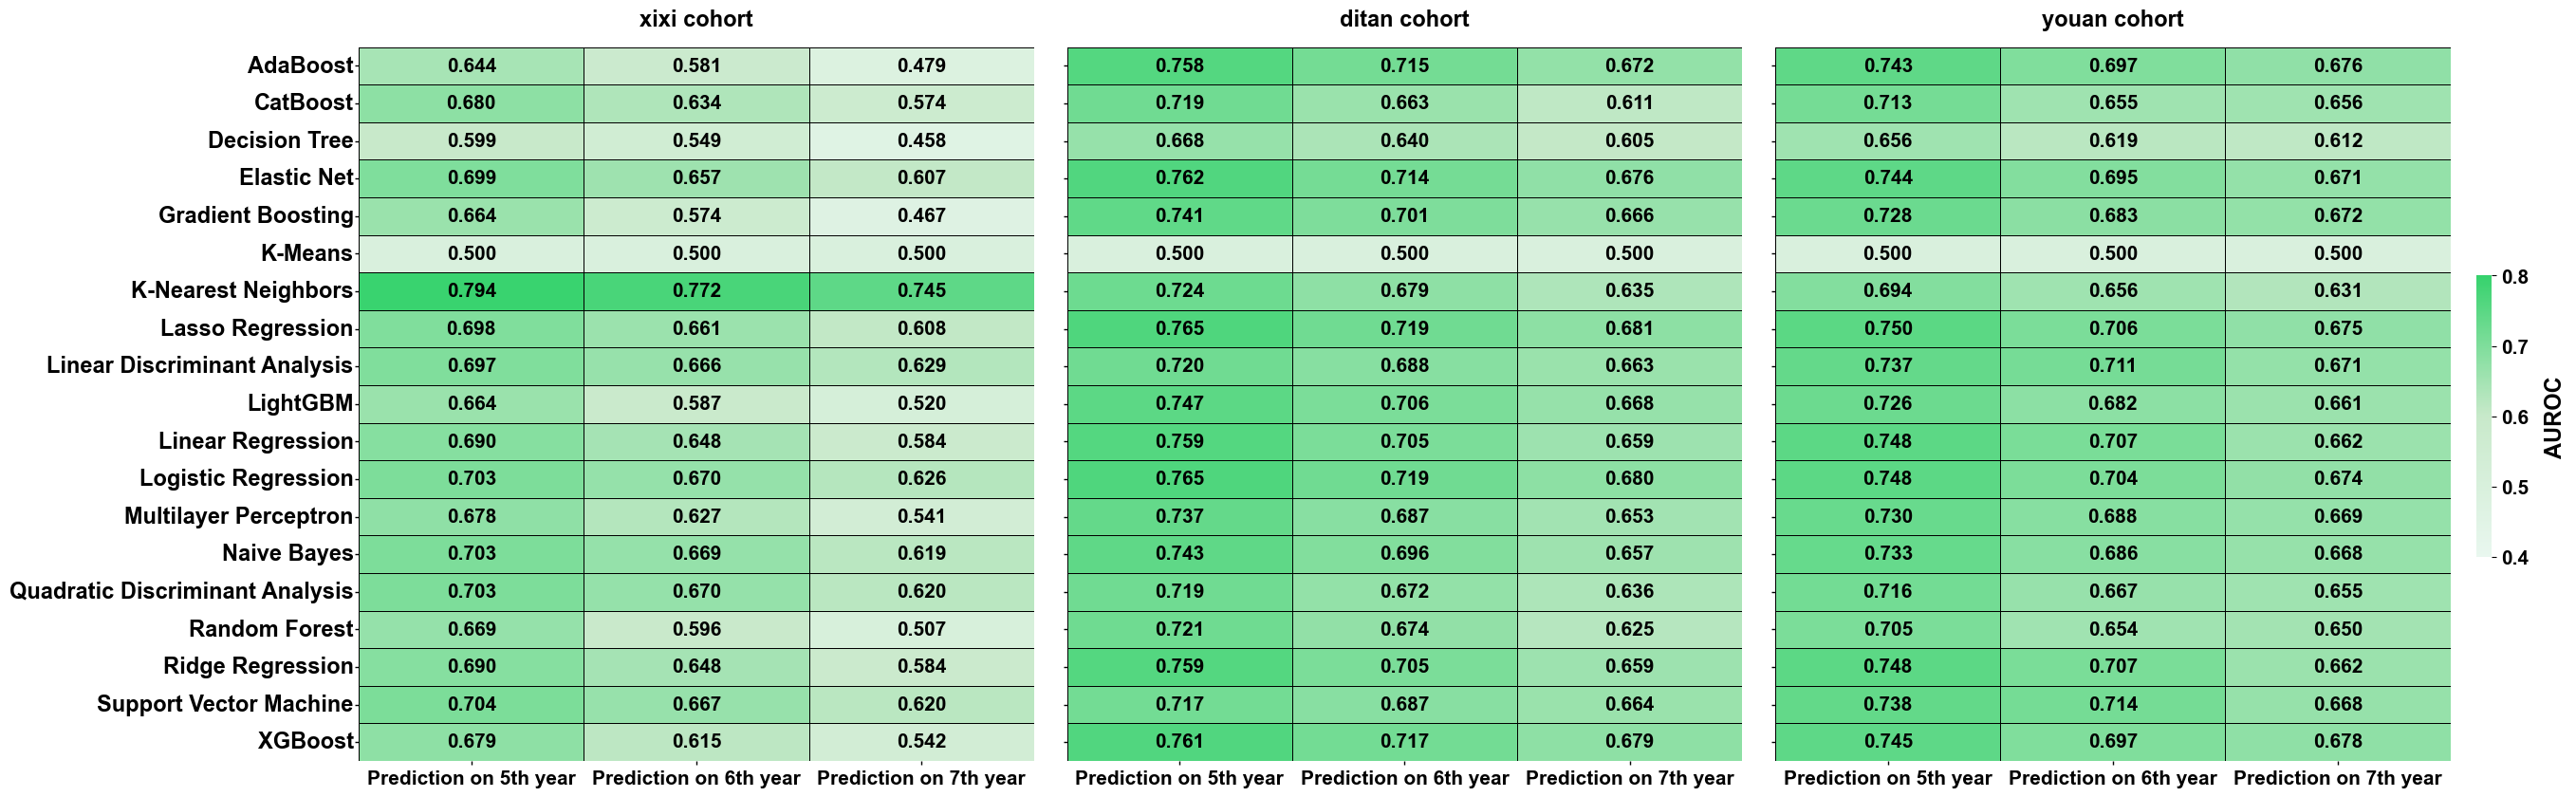

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

df = pd.read_csv('C:/path/AUC_summary.csv')

all_algorithms = [
    "AdaBoost", "CatBoost", "Decision Tree", "Elastic Net", "Gradient Boosting",
    "K-Means", "K-Nearest Neighbors", "Lasso Regression", "Linear Discriminant Analysis",
    "LightGBM", "Linear Regression", "Logistic Regression", "Multilayer Perceptron",
    "Naive Bayes", "Quadratic Discriminant Analysis", "Random Forest",
    "Ridge Regression", "Support Vector Machine", "XGBoost"
]
df['Time Point'] = df['Time Point'].astype(str)
cohorts = df['Cohort'].unique()
time_points = ['5', '6', '7']

cell_width = 3.9
cell_height = 0.45
fig_width = len(cohorts) * len(time_points) * cell_width
fig_height = len(all_algorithms) * cell_height

custom_cmap = LinearSegmentedColormap.from_list(
    'lancet_green', ['#e9f7ef', "#c8e9ca", "#36d26d"]
)

fig, axes = plt.subplots(
    1, len(cohorts),
    figsize=(fig_width, fig_height),
    sharey=True
)
if len(cohorts) == 1:
    axes = [axes]

xtick_font = {
    'fontsize': 15,
    'fontweight': 'bold',
    'fontname': 'Arial',
    'color': 'black'
}
ytick_font = {
    'fontsize': 17,
    'fontweight': 'bold',
    'fontname': 'Arial',
    'color': 'black'
}

n = len(cohorts)
gap = 0.01      
left = 0.23     
right = 0.858   
total_w = right - left
panel_width = (total_w - (n-1)*gap)/n
bottom = 0.07
height = 0.88

for idx, (ax, cohort) in enumerate(zip(axes, cohorts)):
    sub_df = df[df['Cohort'] == cohort]
    pivot = sub_df.pivot(index='File', columns='Time Point', values='AUC').reindex(index=all_algorithms, columns=time_points)
    mask = np.zeros_like(pivot, dtype=bool)
    annot_matrix = pivot.where(~pivot.isna(), '')

    hm = sns.heatmap(
        pivot,
        mask=mask,
        annot=annot_matrix,
        fmt=".3f",
        cmap=custom_cmap,
        cbar=ax == axes[-1],
        linewidths=0.6,
        linecolor='black',
        vmin=0.4, vmax=0.8,
        ax=ax,
        annot_kws={
            'size': 15,
            'weight': 'bold',
            'color': 'black',
            'fontname': 'Arial'
        },
        cbar_kws={
            'shrink': 0.45,
            'aspect': 18,
            'pad': 0.015,
            'label': 'AUC'
        }
    )
    ax.set_title(f"{cohort} cohort", fontsize=17, fontweight='bold', fontname='Arial', pad=16)
    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.set_xticklabels(
        [f"Prediction on {tp}th year" for tp in time_points],
        rotation=0,
        ha='center',
        **xtick_font
    )
    ax.set_yticklabels(
        all_algorithms,
        ha='right',
        **ytick_font
    )
    ax.tick_params(axis='y', length=3, width=1, pad=1) 
    for label in ax.get_yticklabels():
        label.set_horizontalalignment('right')
    ax.tick_params(axis='x', length=3, width=1)

    x0 = left + idx*(panel_width+gap)
    ax.set_position([x0, bottom, panel_width, height])

for ax_in_fig in fig.axes:
    if hasattr(ax_in_fig, "get_ylabel") and ax_in_fig.get_ylabel() == 'AUC':
        colorbar_ax = ax_in_fig
        colorbar_ax.set_ylabel('AUROC', fontsize=17, fontweight='bold', fontname='Arial', color='black', labelpad=12)
        colorbar_ax.tick_params(axis='y', labelsize=15, labelcolor='black')
        for label in colorbar_ax.get_yticklabels():
            label.set_fontname('Arial')
            label.set_fontsize(15)
            label.set_fontweight('bold')
            label.set_color('black')

plt.savefig("C:/path/auc_heatmap.svg", format="svg")
plt.savefig("C:/path/auc_heatmap.pdf", format="pdf")
plt.show()